### How Diffusion works
- Take a target domain (like images)
- Add Gaussian noise to it
- Learn noise generating process (predicting noise direction, given a label?)
- At run time, start with noise and reverse the process

This works in multiple domains: **images, sound, etc.**

Good article: https://theaisummer.com/diffusion-models/

### Understanding time steps

**why is timestep input important in diffusion models?** why can't we train networks to predict image in one time step from noise input? why do we have to break down in many small steps?

>The timestep input is crucial in diffusion models because it allows the model to learn the denoising process gradually and in a controlled manner. There are several reasons why breaking down the denoising process into many small steps is important:

>Stability and Tractability:

>Diffusion models aim to learn the reverse process of the diffusion process, which involves gradually removing noise from a noisy input to recover the original clean image.
**If we try to train a network to predict the clean image from pure noise in a single step, it would be an extremely challenging and unstable task**. The network would need to learn a highly complex and discontinuous mapping, which is difficult to optimize and can lead to poor results.
By breaking down the denoising process into many small steps, each step becomes more manageable and tractable. The network only needs to learn to remove a small amount of noise at each step, making the learning process more stable and easier to optimize.


>Gradual Refinement:

>By having multiple timesteps, the diffusion model can gradually refine the image, starting from a highly noisy state and progressively removing noise at each step.
**Each timestep allows the model to focus on different levels of detail and structure in the image. In the early timesteps, the model can capture high-level structure and coarse details, while in later timesteps, it can focus on finer details and textures.**
This gradual refinement process enables the model to generate high-quality images by iteratively improving the image quality over multiple steps.


>Conditional Generation:

>The timestep input allows for conditional generation in diffusion models.
By providing the desired timestep as an input to the model, we can control the level of denoising and generate images at different stages of the denoising process.
This enables applications like image interpolation, where we can generate intermediate images between two given images by varying the timestep input.


>Improved Sample Quality:

>Breaking down the denoising process into many small steps has been shown to improve the quality of the generated samples.
By allowing the model to make small, incremental changes at each step, it can better capture the underlying data distribution and generate more realistic and diverse samples.
**Attempting to generate the clean image from noise in a single step often leads to blurry, low-quality, or unrealistic samples.**


>Theoretical Foundation:

>Diffusion models have a strong theoretical foundation based on the diffusion process and its reverse process.
The mathematical formulation of diffusion models naturally involves a series of timesteps, where noise is gradually added to the data in the forward process and removed in the reverse process.
By incorporating timesteps into the model architecture, diffusion models align with the underlying theoretical principles and can leverage the properties of the diffusion process for effective generation.


### Let's try implementing it for a toy dataset like MNIST

Using claude

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

In [32]:
class DiffusionModel(nn.Module):
    def __init__(self, img_size, timesteps, num_classes):
        super().__init__()
        self.img_size = img_size
        self.timesteps = timesteps
        self.num_classes = num_classes
        self.net = nn.Sequential(
            nn.Linear(img_size * img_size + 1 + num_classes, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, img_size * img_size),
        )

    def forward(self, x, t, y):
        x = x.view(-1, self.img_size * self.img_size)
        t = t.unsqueeze(1)  # Add an extra dimension to t
        y = nn.functional.one_hot(y, num_classes=self.num_classes).float()
        x = torch.cat([x,t,y], dim=1)
        return self.net(x).view(-1,1,self.img_size, self.img_size)

In [98]:
transform = transforms.Compose([transforms.ToTensor()])
trainset = datasets.MNIST('data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)

In [99]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

In [100]:
model = DiffusionModel(img_size=28, timesteps=1000, num_classes=10).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

Data in trainloader[0]:
Data: 128
Labels: 128
1
tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         

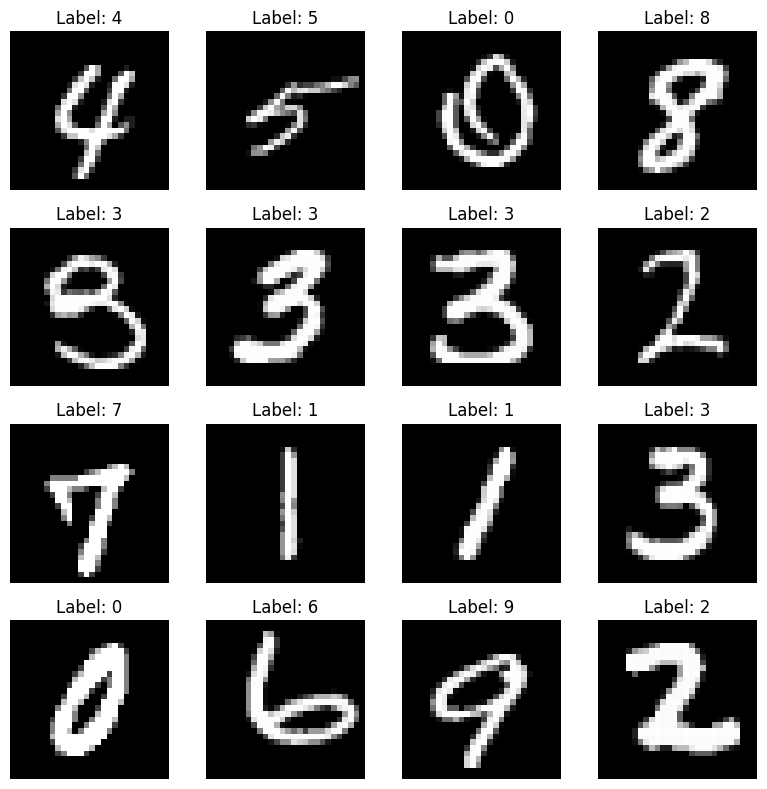

In [78]:
for epoch in range(1):
    i=0
    for data, labels in trainloader:
        data, labels = data.to(device), labels.to(device)
        # Print the contents of trainloader[0]
        if i == 0:
            print("Data in trainloader[0]:")
            print("Data:", len(data))
            print("Labels:", len(labels))
            print(len(data[0]))
            print(data[0])
            # Plot the first batch of images
            fig, axs = plt.subplots(4, 4, figsize=(8, 8))
            axs = axs.flatten()
            for j in range(16):
                img = data[j].squeeze().cpu().numpy()
                axs[j].imshow(img, cmap='gray')
                axs[j].set_title(f"Label: {labels[j].item()}")
                axs[j].axis('off')
            plt.tight_layout()
            plt.show()
            break
    

In [92]:
for epoch in range(1):
    i=0
    for data, labels in trainloader:
        
        ## data here is 128 batch size of each image and labels is 128 batch size of each label
        data, labels = data.to(device), labels.to(device)
        
        optimizer.zero_grad()

        # t here is random integer with values between 0 and 999, representing timesteps for each example in the batch
        t = torch.randint(0, 1000, (data.shape[0],), device=device)
        print(t)
        print(torch.sqrt(t.view(-1,1,1,1)/999))

        # generates random noise (mean 0, sd 1) tensor with the same shape as input data
        noise = torch.randn_like(data)
        print(noise[0])

        # adds noise to input data based on timesteps. Scales noise by  a factor calculated using the timesteps
        # In diffusion models, the noise is gradually added to the data over the course of the diffusion process. The amount of noise added at each timestep is typically proportional to the square root of the timestep value. This is derived from the continuous-time formulation of the diffusion process.
        noisy_data = data + noise * torch.sqrt(t.view(-1,1,1,1)/999)
        print(data[0])
        print(noisy_data[0])
        break

tensor([ 73, 934, 598, 755, 809, 260, 649, 655, 814,  59, 635, 444, 877, 692,
        722, 329,  62, 301, 692, 431, 803, 626, 883, 113, 401, 169, 508, 566,
        323, 503, 853, 175, 633, 873, 574, 184, 995, 459, 133, 376, 250, 162,
        271, 722, 339, 615, 945, 307, 334, 206, 717, 592, 868, 428, 221, 299,
        214, 966, 154, 292, 403,  26, 322, 124, 262,  90, 771, 111, 527, 444,
        913, 992, 280, 935,  62, 602,  72, 493, 296, 974, 105, 772, 197, 458,
        291, 940, 955, 236, 551, 121, 490, 565, 723, 968, 573, 104, 706, 401,
         67, 843, 912, 889, 368, 515, 134, 565, 135,  87, 424, 204, 654, 645,
        951, 406, 474, 623, 210,  80, 545,  43, 686, 801, 438, 563, 141, 807,
        414, 654], device='mps:0')
tensor([[[[0.2703]]],


        [[[0.9669]]],


        [[[0.7737]]],


        [[[0.8693]]],


        [[[0.8999]]],


        [[[0.5102]]],


        [[[0.8060]]],


        [[[0.8097]]],


        [[[0.9027]]],


        [[[0.2430]]],


        [[[0.7973]]],



in the training step,
noisy_data = data + noise * torch.sqrt(t.view(-1,1,1,1)/999)
why are we square rooting?

>In diffusion models, the noise is gradually added to the data over the course of the diffusion process. The amount of noise added at each timestep is typically proportional to the square root of the timestep value. This is derived from the continuous-time formulation of the diffusion process.

**can networks initially trained on 50 steps can be run at inference time at more or less number of steps? how does that work?**

Adjust step size accordingly.

>When you train a diffusion model with a specific number of timesteps (e.g., 1000), you can run the model at inference time with a different number of timesteps by adjusting the step size accordingly.
>

e.g. running in half number of time steps

`# Sampling loop
target_label = 5  # Generate images of the digit 5
num_inference_steps = 500

with torch.no_grad():
    x = torch.randn(1, 1, 28, 28).to(device)
    y = torch.tensor([target_label]).to(device)
    
    # Adjust the step size to skip every other step
    step_size = 2
    for t in range(999, -1, -step_size):
        z = torch.randn(1, 1, 28, 28).to(device) if t > 0 else torch.zeros(1, 1, 28, 28).to(device)
        x = x - (step_size / torch.sqrt(torch.tensor([t]))) * model(x, t, y)
        x = (1 / torch.sqrt(1 - (t / 999))) * (x - (t / 999) * model(x, t, y))
        x = x + torch.sqrt((t / 999) * step_size) * z

`

### Let's train the model

Epoch [1/100], i: 0, Loss: 4.2512
Epoch [1/100], i: 100, Loss: 1.0006
Epoch [1/100], i: 200, Loss: 0.9811
Epoch [1/100], i: 300, Loss: 0.9688
Epoch [1/100], i: 400, Loss: 0.9655


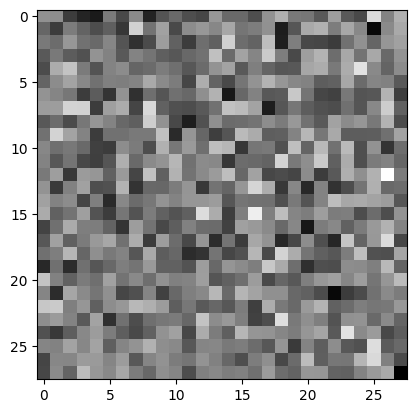

Epoch [2/100], i: 0, Loss: 0.9557
Epoch [2/100], i: 100, Loss: 0.9469
Epoch [2/100], i: 200, Loss: 0.9492
Epoch [2/100], i: 300, Loss: 0.9458
Epoch [2/100], i: 400, Loss: 0.9388
Epoch [3/100], i: 0, Loss: 0.9375
Epoch [3/100], i: 100, Loss: 0.9404
Epoch [3/100], i: 200, Loss: 0.9379
Epoch [3/100], i: 300, Loss: 0.9422
Epoch [3/100], i: 400, Loss: 0.9385
Epoch [4/100], i: 0, Loss: 0.9354
Epoch [4/100], i: 100, Loss: 0.9364
Epoch [4/100], i: 200, Loss: 0.9502
Epoch [4/100], i: 300, Loss: 0.9408
Epoch [4/100], i: 400, Loss: 0.9447
Epoch [5/100], i: 0, Loss: 0.9461
Epoch [5/100], i: 100, Loss: 0.9477
Epoch [5/100], i: 200, Loss: 0.9413
Epoch [5/100], i: 300, Loss: 0.9389
Epoch [5/100], i: 400, Loss: 0.9401
Epoch [6/100], i: 0, Loss: 0.9382
Epoch [6/100], i: 100, Loss: 0.9381
Epoch [6/100], i: 200, Loss: 0.9363
Epoch [6/100], i: 300, Loss: 0.9359
Epoch [6/100], i: 400, Loss: 0.9419


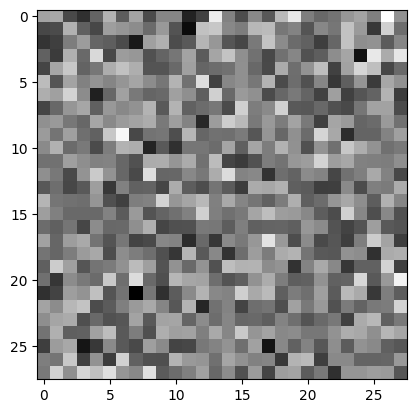

Epoch [7/100], i: 0, Loss: 0.9347
Epoch [7/100], i: 100, Loss: 0.9411
Epoch [7/100], i: 200, Loss: 0.9419
Epoch [7/100], i: 300, Loss: 0.9378
Epoch [7/100], i: 400, Loss: 0.9365
Epoch [8/100], i: 0, Loss: 0.9361
Epoch [8/100], i: 100, Loss: 0.9387
Epoch [8/100], i: 200, Loss: 0.9374
Epoch [8/100], i: 300, Loss: 0.9465
Epoch [8/100], i: 400, Loss: 0.9387
Epoch [9/100], i: 0, Loss: 0.9363
Epoch [9/100], i: 100, Loss: 0.9416
Epoch [9/100], i: 200, Loss: 0.9367
Epoch [9/100], i: 300, Loss: 0.9383
Epoch [9/100], i: 400, Loss: 0.9334
Epoch [10/100], i: 0, Loss: 0.9346
Epoch [10/100], i: 100, Loss: 0.9346
Epoch [10/100], i: 200, Loss: 0.9424
Epoch [10/100], i: 300, Loss: 0.9385
Epoch [10/100], i: 400, Loss: 0.9415
Epoch [11/100], i: 0, Loss: 0.9336
Epoch [11/100], i: 100, Loss: 0.9433
Epoch [11/100], i: 200, Loss: 0.9357
Epoch [11/100], i: 300, Loss: 0.9327
Epoch [11/100], i: 400, Loss: 0.9298


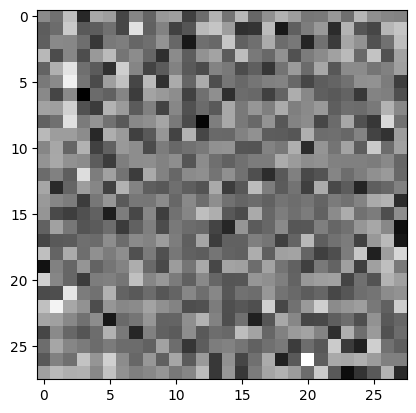

Epoch [12/100], i: 0, Loss: 0.9372
Epoch [12/100], i: 100, Loss: 0.9272
Epoch [12/100], i: 200, Loss: 0.9357
Epoch [12/100], i: 300, Loss: 0.9478
Epoch [12/100], i: 400, Loss: 0.9356
Epoch [13/100], i: 0, Loss: 0.9368
Epoch [13/100], i: 100, Loss: 0.9390
Epoch [13/100], i: 200, Loss: 0.9368
Epoch [13/100], i: 300, Loss: 0.9406
Epoch [13/100], i: 400, Loss: 0.9344
Epoch [14/100], i: 0, Loss: 0.9455
Epoch [14/100], i: 100, Loss: 0.9388
Epoch [14/100], i: 200, Loss: 0.9375
Epoch [14/100], i: 300, Loss: 0.9394
Epoch [14/100], i: 400, Loss: 0.9314
Epoch [15/100], i: 0, Loss: 0.9468
Epoch [15/100], i: 100, Loss: 0.9332
Epoch [15/100], i: 200, Loss: 0.9416
Epoch [15/100], i: 300, Loss: 0.9371
Epoch [15/100], i: 400, Loss: 0.9300
Epoch [16/100], i: 0, Loss: 0.9404
Epoch [16/100], i: 100, Loss: 0.9357
Epoch [16/100], i: 200, Loss: 0.9363
Epoch [16/100], i: 300, Loss: 0.9381
Epoch [16/100], i: 400, Loss: 0.9342


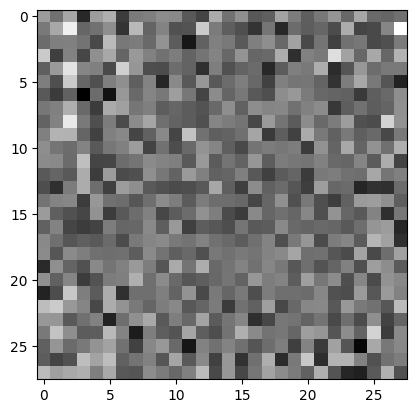

Epoch [17/100], i: 0, Loss: 0.9407
Epoch [17/100], i: 100, Loss: 0.9362
Epoch [17/100], i: 200, Loss: 0.9286
Epoch [17/100], i: 300, Loss: 0.9360
Epoch [17/100], i: 400, Loss: 0.9330
Epoch [18/100], i: 0, Loss: 0.9426
Epoch [18/100], i: 100, Loss: 0.9378
Epoch [18/100], i: 200, Loss: 0.9465
Epoch [18/100], i: 300, Loss: 0.9309
Epoch [18/100], i: 400, Loss: 0.9404
Epoch [19/100], i: 0, Loss: 0.9359
Epoch [19/100], i: 100, Loss: 0.9361
Epoch [19/100], i: 200, Loss: 0.9362
Epoch [19/100], i: 300, Loss: 0.9317
Epoch [19/100], i: 400, Loss: 0.9366
Epoch [20/100], i: 0, Loss: 0.9402
Epoch [20/100], i: 100, Loss: 0.9267
Epoch [20/100], i: 200, Loss: 0.9396
Epoch [20/100], i: 300, Loss: 0.9393
Epoch [20/100], i: 400, Loss: 0.9394
Epoch [21/100], i: 0, Loss: 0.9354
Epoch [21/100], i: 100, Loss: 0.9328
Epoch [21/100], i: 200, Loss: 0.9328
Epoch [21/100], i: 300, Loss: 0.9406
Epoch [21/100], i: 400, Loss: 0.9332


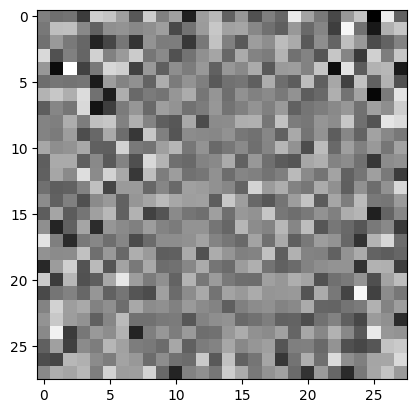

Epoch [22/100], i: 0, Loss: 0.9326
Epoch [22/100], i: 100, Loss: 0.9354
Epoch [22/100], i: 200, Loss: 0.9308
Epoch [22/100], i: 300, Loss: 0.9400
Epoch [22/100], i: 400, Loss: 0.9360
Epoch [23/100], i: 0, Loss: 0.9309
Epoch [23/100], i: 100, Loss: 0.9356
Epoch [23/100], i: 200, Loss: 0.9374
Epoch [23/100], i: 300, Loss: 0.9294
Epoch [23/100], i: 400, Loss: 0.9344
Epoch [24/100], i: 0, Loss: 0.9443
Epoch [24/100], i: 100, Loss: 0.9406
Epoch [24/100], i: 200, Loss: 0.9411
Epoch [24/100], i: 300, Loss: 0.9321
Epoch [24/100], i: 400, Loss: 0.9390
Epoch [25/100], i: 0, Loss: 0.9405
Epoch [25/100], i: 100, Loss: 0.9392
Epoch [25/100], i: 200, Loss: 0.9302
Epoch [25/100], i: 300, Loss: 0.9394
Epoch [25/100], i: 400, Loss: 0.9397
Epoch [26/100], i: 0, Loss: 0.9312
Epoch [26/100], i: 100, Loss: 0.9399
Epoch [26/100], i: 200, Loss: 0.9357
Epoch [26/100], i: 300, Loss: 0.9340
Epoch [26/100], i: 400, Loss: 0.9332


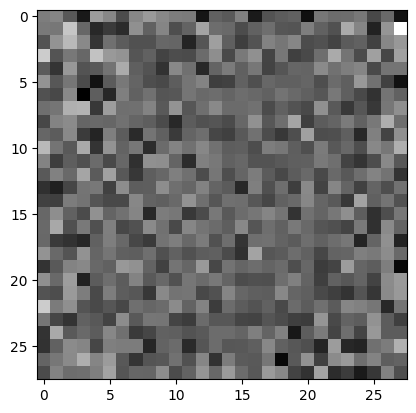

Epoch [27/100], i: 0, Loss: 0.9350
Epoch [27/100], i: 100, Loss: 0.9262
Epoch [27/100], i: 200, Loss: 0.9425
Epoch [27/100], i: 300, Loss: 0.9362
Epoch [27/100], i: 400, Loss: 0.9358
Epoch [28/100], i: 0, Loss: 0.9369
Epoch [28/100], i: 100, Loss: 0.9316
Epoch [28/100], i: 200, Loss: 0.9375
Epoch [28/100], i: 300, Loss: 0.9448
Epoch [28/100], i: 400, Loss: 0.9337
Epoch [29/100], i: 0, Loss: 0.9380
Epoch [29/100], i: 100, Loss: 0.9310
Epoch [29/100], i: 200, Loss: 0.9312
Epoch [29/100], i: 300, Loss: 0.9319
Epoch [29/100], i: 400, Loss: 0.9348
Epoch [30/100], i: 0, Loss: 0.9288
Epoch [30/100], i: 100, Loss: 0.9319
Epoch [30/100], i: 200, Loss: 0.9330
Epoch [30/100], i: 300, Loss: 0.9358
Epoch [30/100], i: 400, Loss: 0.9351
Epoch [31/100], i: 0, Loss: 0.9320
Epoch [31/100], i: 100, Loss: 0.9346
Epoch [31/100], i: 200, Loss: 0.9385
Epoch [31/100], i: 300, Loss: 0.9408
Epoch [31/100], i: 400, Loss: 0.9367


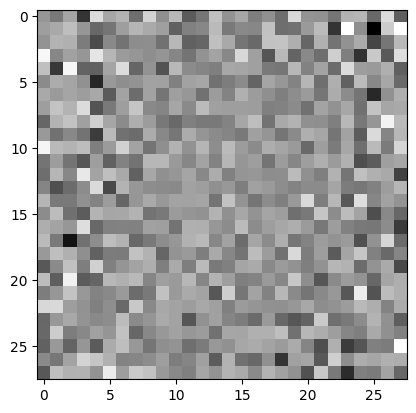

Epoch [32/100], i: 0, Loss: 0.9361
Epoch [32/100], i: 100, Loss: 0.9306
Epoch [32/100], i: 200, Loss: 0.9371
Epoch [32/100], i: 300, Loss: 0.9322
Epoch [32/100], i: 400, Loss: 0.9338
Epoch [33/100], i: 0, Loss: 0.9342
Epoch [33/100], i: 100, Loss: 0.9408
Epoch [33/100], i: 200, Loss: 0.9354
Epoch [33/100], i: 300, Loss: 0.9345
Epoch [33/100], i: 400, Loss: 0.9371
Epoch [34/100], i: 0, Loss: 0.9366
Epoch [34/100], i: 100, Loss: 0.9347
Epoch [34/100], i: 200, Loss: 0.9384
Epoch [34/100], i: 300, Loss: 0.9368
Epoch [34/100], i: 400, Loss: 0.9370
Epoch [35/100], i: 0, Loss: 0.9325
Epoch [35/100], i: 100, Loss: 0.9427
Epoch [35/100], i: 200, Loss: 0.9260
Epoch [35/100], i: 300, Loss: 0.9426
Epoch [35/100], i: 400, Loss: 0.9368
Epoch [36/100], i: 0, Loss: 0.9306
Epoch [36/100], i: 100, Loss: 0.9289
Epoch [36/100], i: 200, Loss: 0.9389
Epoch [36/100], i: 300, Loss: 0.9325
Epoch [36/100], i: 400, Loss: 0.9374


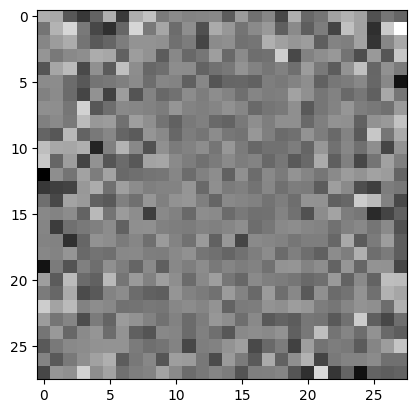

Epoch [37/100], i: 0, Loss: 0.9296
Epoch [37/100], i: 100, Loss: 0.9354
Epoch [37/100], i: 200, Loss: 0.9350
Epoch [37/100], i: 300, Loss: 0.9371
Epoch [37/100], i: 400, Loss: 0.9306
Epoch [38/100], i: 0, Loss: 0.9381
Epoch [38/100], i: 100, Loss: 0.9323
Epoch [38/100], i: 200, Loss: 0.9294
Epoch [38/100], i: 300, Loss: 0.9375
Epoch [38/100], i: 400, Loss: 0.9389
Epoch [39/100], i: 0, Loss: 0.9331
Epoch [39/100], i: 100, Loss: 0.9343
Epoch [39/100], i: 200, Loss: 0.9377
Epoch [39/100], i: 300, Loss: 0.9287
Epoch [39/100], i: 400, Loss: 0.9346
Epoch [40/100], i: 0, Loss: 0.9346
Epoch [40/100], i: 100, Loss: 0.9360
Epoch [40/100], i: 200, Loss: 0.9300
Epoch [40/100], i: 300, Loss: 0.9381
Epoch [40/100], i: 400, Loss: 0.9310
Epoch [41/100], i: 0, Loss: 0.9362
Epoch [41/100], i: 100, Loss: 0.9313
Epoch [41/100], i: 200, Loss: 0.9325
Epoch [41/100], i: 300, Loss: 0.9420
Epoch [41/100], i: 400, Loss: 0.9328


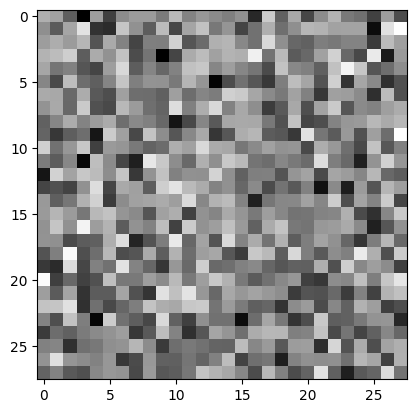

Epoch [42/100], i: 0, Loss: 0.9327
Epoch [42/100], i: 100, Loss: 0.9379
Epoch [42/100], i: 200, Loss: 0.9307
Epoch [42/100], i: 300, Loss: 0.9376
Epoch [42/100], i: 400, Loss: 0.9375
Epoch [43/100], i: 0, Loss: 0.9320
Epoch [43/100], i: 100, Loss: 0.9438
Epoch [43/100], i: 200, Loss: 0.9343
Epoch [43/100], i: 300, Loss: 0.9332
Epoch [43/100], i: 400, Loss: 0.9420
Epoch [44/100], i: 0, Loss: 0.9350
Epoch [44/100], i: 100, Loss: 0.9246
Epoch [44/100], i: 200, Loss: 0.9322
Epoch [44/100], i: 300, Loss: 0.9368
Epoch [44/100], i: 400, Loss: 0.9351
Epoch [45/100], i: 0, Loss: 0.9313
Epoch [45/100], i: 100, Loss: 0.9368
Epoch [45/100], i: 200, Loss: 0.9316
Epoch [45/100], i: 300, Loss: 0.9336
Epoch [45/100], i: 400, Loss: 0.9358
Epoch [46/100], i: 0, Loss: 0.9380
Epoch [46/100], i: 100, Loss: 0.9254
Epoch [46/100], i: 200, Loss: 0.9353
Epoch [46/100], i: 300, Loss: 0.9374
Epoch [46/100], i: 400, Loss: 0.9302


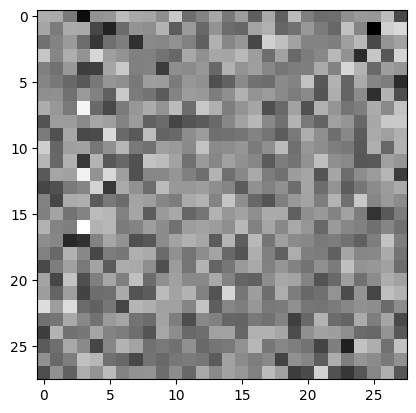

Epoch [47/100], i: 0, Loss: 0.9349
Epoch [47/100], i: 100, Loss: 0.9447
Epoch [47/100], i: 200, Loss: 0.9396
Epoch [47/100], i: 300, Loss: 0.9360
Epoch [47/100], i: 400, Loss: 0.9318
Epoch [48/100], i: 0, Loss: 0.9378
Epoch [48/100], i: 100, Loss: 0.9345
Epoch [48/100], i: 200, Loss: 0.9371
Epoch [48/100], i: 300, Loss: 0.9344
Epoch [48/100], i: 400, Loss: 0.9391
Epoch [49/100], i: 0, Loss: 0.9376
Epoch [49/100], i: 100, Loss: 0.9378
Epoch [49/100], i: 200, Loss: 0.9317
Epoch [49/100], i: 300, Loss: 0.9370
Epoch [49/100], i: 400, Loss: 0.9406
Epoch [50/100], i: 0, Loss: 0.9331
Epoch [50/100], i: 100, Loss: 0.9297
Epoch [50/100], i: 200, Loss: 0.9343
Epoch [50/100], i: 300, Loss: 0.9368
Epoch [50/100], i: 400, Loss: 0.9380
Epoch [51/100], i: 0, Loss: 0.9369
Epoch [51/100], i: 100, Loss: 0.9369
Epoch [51/100], i: 200, Loss: 0.9388
Epoch [51/100], i: 300, Loss: 0.9399
Epoch [51/100], i: 400, Loss: 0.9267


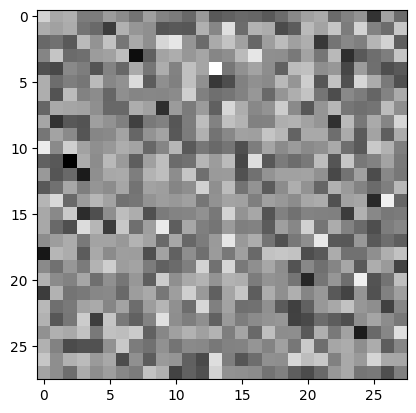

Epoch [52/100], i: 0, Loss: 0.9387
Epoch [52/100], i: 100, Loss: 0.9366
Epoch [52/100], i: 200, Loss: 0.9297
Epoch [52/100], i: 300, Loss: 0.9259
Epoch [52/100], i: 400, Loss: 0.9366
Epoch [53/100], i: 0, Loss: 0.9320
Epoch [53/100], i: 100, Loss: 0.9423
Epoch [53/100], i: 200, Loss: 0.9307
Epoch [53/100], i: 300, Loss: 0.9388
Epoch [53/100], i: 400, Loss: 0.9303
Epoch [54/100], i: 0, Loss: 0.9325
Epoch [54/100], i: 100, Loss: 0.9407
Epoch [54/100], i: 200, Loss: 0.9335
Epoch [54/100], i: 300, Loss: 0.9314
Epoch [54/100], i: 400, Loss: 0.9394
Epoch [55/100], i: 0, Loss: 0.9248
Epoch [55/100], i: 100, Loss: 0.9398
Epoch [55/100], i: 200, Loss: 0.9371
Epoch [55/100], i: 300, Loss: 0.9372
Epoch [55/100], i: 400, Loss: 0.9315
Epoch [56/100], i: 0, Loss: 0.9340
Epoch [56/100], i: 100, Loss: 0.9360
Epoch [56/100], i: 200, Loss: 0.9384
Epoch [56/100], i: 300, Loss: 0.9356
Epoch [56/100], i: 400, Loss: 0.9356


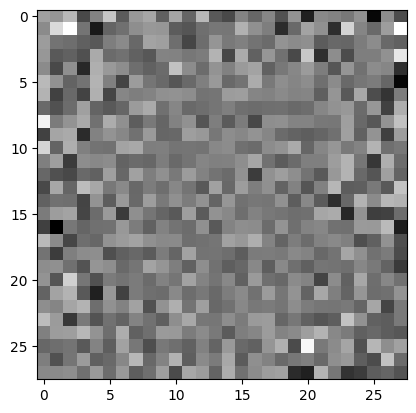

Epoch [57/100], i: 0, Loss: 0.9320
Epoch [57/100], i: 100, Loss: 0.9348
Epoch [57/100], i: 200, Loss: 0.9267
Epoch [57/100], i: 300, Loss: 0.9326
Epoch [57/100], i: 400, Loss: 0.9322
Epoch [58/100], i: 0, Loss: 0.9253
Epoch [58/100], i: 100, Loss: 0.9421
Epoch [58/100], i: 200, Loss: 0.9399
Epoch [58/100], i: 300, Loss: 0.9300
Epoch [58/100], i: 400, Loss: 0.9399
Epoch [59/100], i: 0, Loss: 0.9378
Epoch [59/100], i: 100, Loss: 0.9381
Epoch [59/100], i: 200, Loss: 0.9289
Epoch [59/100], i: 300, Loss: 0.9291
Epoch [59/100], i: 400, Loss: 0.9345
Epoch [60/100], i: 0, Loss: 0.9428
Epoch [60/100], i: 100, Loss: 0.9387
Epoch [60/100], i: 200, Loss: 0.9344
Epoch [60/100], i: 300, Loss: 0.9332
Epoch [60/100], i: 400, Loss: 0.9385
Epoch [61/100], i: 0, Loss: 0.9388
Epoch [61/100], i: 100, Loss: 0.9403
Epoch [61/100], i: 200, Loss: 0.9298
Epoch [61/100], i: 300, Loss: 0.9418
Epoch [61/100], i: 400, Loss: 0.9329


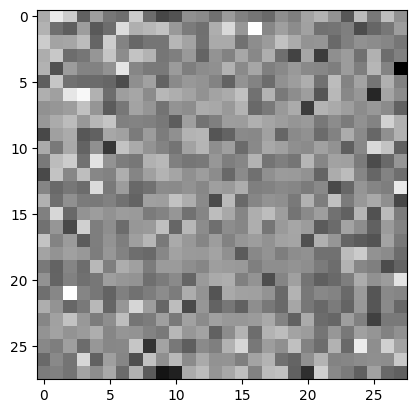

Epoch [62/100], i: 0, Loss: 0.9326
Epoch [62/100], i: 100, Loss: 0.9387
Epoch [62/100], i: 200, Loss: 0.9301
Epoch [62/100], i: 300, Loss: 0.9274
Epoch [62/100], i: 400, Loss: 0.9343
Epoch [63/100], i: 0, Loss: 0.9366
Epoch [63/100], i: 100, Loss: 0.9350
Epoch [63/100], i: 200, Loss: 0.9315
Epoch [63/100], i: 300, Loss: 0.9355
Epoch [63/100], i: 400, Loss: 0.9281
Epoch [64/100], i: 0, Loss: 0.9312
Epoch [64/100], i: 100, Loss: 0.9383
Epoch [64/100], i: 200, Loss: 0.9305
Epoch [64/100], i: 300, Loss: 0.9249
Epoch [64/100], i: 400, Loss: 0.9331
Epoch [65/100], i: 0, Loss: 0.9378
Epoch [65/100], i: 100, Loss: 0.9371
Epoch [65/100], i: 200, Loss: 0.9366
Epoch [65/100], i: 300, Loss: 0.9328
Epoch [65/100], i: 400, Loss: 0.9347
Epoch [66/100], i: 0, Loss: 0.9435
Epoch [66/100], i: 100, Loss: 0.9330
Epoch [66/100], i: 200, Loss: 0.9344
Epoch [66/100], i: 300, Loss: 0.9394
Epoch [66/100], i: 400, Loss: 0.9311


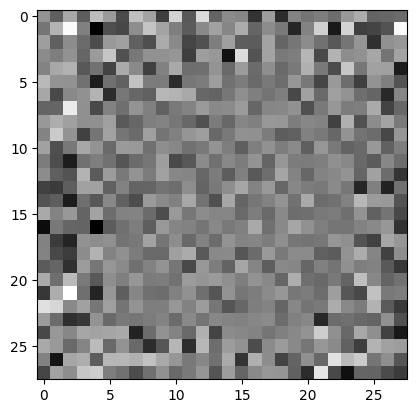

Epoch [67/100], i: 0, Loss: 0.9336
Epoch [67/100], i: 100, Loss: 0.9295
Epoch [67/100], i: 200, Loss: 0.9450
Epoch [67/100], i: 300, Loss: 0.9424
Epoch [67/100], i: 400, Loss: 0.9364
Epoch [68/100], i: 0, Loss: 0.9279
Epoch [68/100], i: 100, Loss: 0.9279
Epoch [68/100], i: 200, Loss: 0.9293
Epoch [68/100], i: 300, Loss: 0.9307
Epoch [68/100], i: 400, Loss: 0.9341
Epoch [69/100], i: 0, Loss: 0.9305
Epoch [69/100], i: 100, Loss: 0.9332
Epoch [69/100], i: 200, Loss: 0.9333
Epoch [69/100], i: 300, Loss: 0.9271
Epoch [69/100], i: 400, Loss: 0.9334
Epoch [70/100], i: 0, Loss: 0.9324
Epoch [70/100], i: 100, Loss: 0.9343
Epoch [70/100], i: 200, Loss: 0.9328
Epoch [70/100], i: 300, Loss: 0.9340
Epoch [70/100], i: 400, Loss: 0.9372
Epoch [71/100], i: 0, Loss: 0.9424
Epoch [71/100], i: 100, Loss: 0.9328
Epoch [71/100], i: 200, Loss: 0.9294
Epoch [71/100], i: 300, Loss: 0.9313
Epoch [71/100], i: 400, Loss: 0.9328


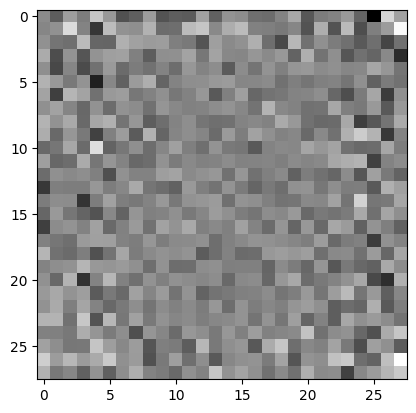

Epoch [72/100], i: 0, Loss: 0.9385
Epoch [72/100], i: 100, Loss: 0.9334
Epoch [72/100], i: 200, Loss: 0.9302
Epoch [72/100], i: 300, Loss: 0.9401
Epoch [72/100], i: 400, Loss: 0.9415
Epoch [73/100], i: 0, Loss: 0.9357
Epoch [73/100], i: 100, Loss: 0.9363
Epoch [73/100], i: 200, Loss: 0.9465
Epoch [73/100], i: 300, Loss: 0.9414
Epoch [73/100], i: 400, Loss: 0.9338
Epoch [74/100], i: 0, Loss: 0.9345
Epoch [74/100], i: 100, Loss: 0.9347
Epoch [74/100], i: 200, Loss: 0.9286
Epoch [74/100], i: 300, Loss: 0.9402
Epoch [74/100], i: 400, Loss: 0.9322
Epoch [75/100], i: 0, Loss: 0.9334
Epoch [75/100], i: 100, Loss: 0.9339
Epoch [75/100], i: 200, Loss: 0.9314
Epoch [75/100], i: 300, Loss: 0.9439
Epoch [75/100], i: 400, Loss: 0.9344
Epoch [76/100], i: 0, Loss: 0.9398
Epoch [76/100], i: 100, Loss: 0.9318
Epoch [76/100], i: 200, Loss: 0.9271
Epoch [76/100], i: 300, Loss: 0.9334
Epoch [76/100], i: 400, Loss: 0.9383


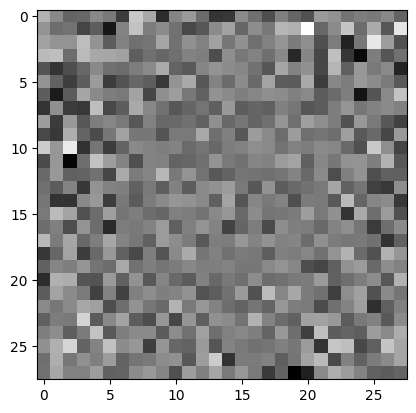

Epoch [77/100], i: 0, Loss: 0.9302
Epoch [77/100], i: 100, Loss: 0.9341
Epoch [77/100], i: 200, Loss: 0.9357
Epoch [77/100], i: 300, Loss: 0.9339
Epoch [77/100], i: 400, Loss: 0.9277
Epoch [78/100], i: 0, Loss: 0.9298
Epoch [78/100], i: 100, Loss: 0.9408
Epoch [78/100], i: 200, Loss: 0.9347
Epoch [78/100], i: 300, Loss: 0.9316
Epoch [78/100], i: 400, Loss: 0.9367
Epoch [79/100], i: 0, Loss: 0.9271
Epoch [79/100], i: 100, Loss: 0.9363
Epoch [79/100], i: 200, Loss: 0.9354
Epoch [79/100], i: 300, Loss: 0.9329
Epoch [79/100], i: 400, Loss: 0.9340
Epoch [80/100], i: 0, Loss: 0.9359
Epoch [80/100], i: 100, Loss: 0.9336
Epoch [80/100], i: 200, Loss: 0.9371
Epoch [80/100], i: 300, Loss: 0.9390
Epoch [80/100], i: 400, Loss: 0.9339
Epoch [81/100], i: 0, Loss: 0.9381
Epoch [81/100], i: 100, Loss: 0.9333
Epoch [81/100], i: 200, Loss: 0.9292
Epoch [81/100], i: 300, Loss: 0.9379
Epoch [81/100], i: 400, Loss: 0.9403


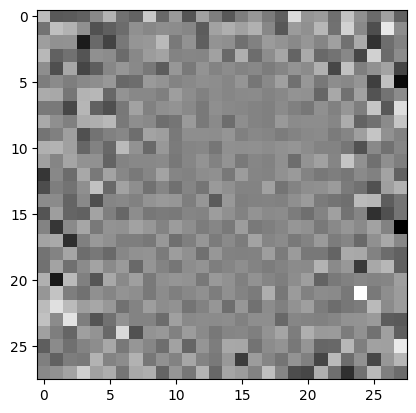

Epoch [82/100], i: 0, Loss: 0.9368
Epoch [82/100], i: 100, Loss: 0.9311
Epoch [82/100], i: 200, Loss: 0.9344
Epoch [82/100], i: 300, Loss: 0.9343
Epoch [82/100], i: 400, Loss: 0.9292
Epoch [83/100], i: 0, Loss: 0.9304
Epoch [83/100], i: 100, Loss: 0.9314
Epoch [83/100], i: 200, Loss: 0.9377
Epoch [83/100], i: 300, Loss: 0.9301
Epoch [83/100], i: 400, Loss: 0.9287
Epoch [84/100], i: 0, Loss: 0.9340
Epoch [84/100], i: 100, Loss: 0.9307
Epoch [84/100], i: 200, Loss: 0.9319
Epoch [84/100], i: 300, Loss: 0.9348
Epoch [84/100], i: 400, Loss: 0.9307
Epoch [85/100], i: 0, Loss: 0.9390
Epoch [85/100], i: 100, Loss: 0.9365
Epoch [85/100], i: 200, Loss: 0.9340
Epoch [85/100], i: 300, Loss: 0.9309
Epoch [85/100], i: 400, Loss: 0.9366
Epoch [86/100], i: 0, Loss: 0.9282
Epoch [86/100], i: 100, Loss: 0.9334
Epoch [86/100], i: 200, Loss: 0.9368
Epoch [86/100], i: 300, Loss: 0.9307
Epoch [86/100], i: 400, Loss: 0.9334


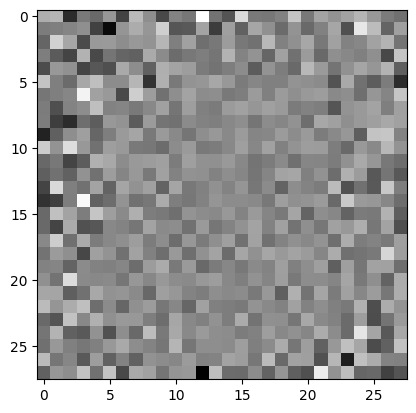

Epoch [87/100], i: 0, Loss: 0.9341
Epoch [87/100], i: 100, Loss: 0.9301
Epoch [87/100], i: 200, Loss: 0.9395
Epoch [87/100], i: 300, Loss: 0.9380
Epoch [87/100], i: 400, Loss: 0.9323
Epoch [88/100], i: 0, Loss: 0.9358
Epoch [88/100], i: 100, Loss: 0.9356
Epoch [88/100], i: 200, Loss: 0.9398
Epoch [88/100], i: 300, Loss: 0.9354
Epoch [88/100], i: 400, Loss: 0.9391
Epoch [89/100], i: 0, Loss: 0.9281
Epoch [89/100], i: 100, Loss: 0.9342
Epoch [89/100], i: 200, Loss: 0.9330
Epoch [89/100], i: 300, Loss: 0.9379
Epoch [89/100], i: 400, Loss: 0.9396
Epoch [90/100], i: 0, Loss: 0.9345
Epoch [90/100], i: 100, Loss: 0.9317
Epoch [90/100], i: 200, Loss: 0.9355
Epoch [90/100], i: 300, Loss: 0.9344
Epoch [90/100], i: 400, Loss: 0.9396
Epoch [91/100], i: 0, Loss: 0.9331
Epoch [91/100], i: 100, Loss: 0.9405
Epoch [91/100], i: 200, Loss: 0.9423
Epoch [91/100], i: 300, Loss: 0.9324
Epoch [91/100], i: 400, Loss: 0.9304


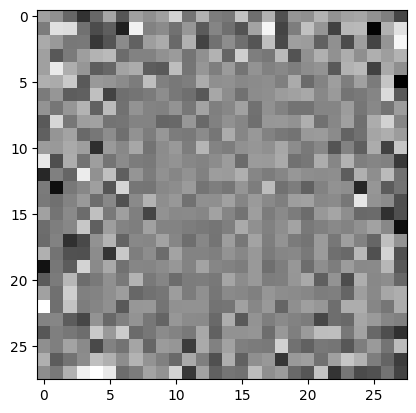

Epoch [92/100], i: 0, Loss: 0.9375
Epoch [92/100], i: 100, Loss: 0.9341
Epoch [92/100], i: 200, Loss: 0.9442
Epoch [92/100], i: 300, Loss: 0.9298
Epoch [92/100], i: 400, Loss: 0.9358
Epoch [93/100], i: 0, Loss: 0.9376
Epoch [93/100], i: 100, Loss: 0.9333
Epoch [93/100], i: 200, Loss: 0.9440
Epoch [93/100], i: 300, Loss: 0.9375
Epoch [93/100], i: 400, Loss: 0.9352
Epoch [94/100], i: 0, Loss: 0.9292
Epoch [94/100], i: 100, Loss: 0.9350
Epoch [94/100], i: 200, Loss: 0.9354
Epoch [94/100], i: 300, Loss: 0.9373
Epoch [94/100], i: 400, Loss: 0.9360
Epoch [95/100], i: 0, Loss: 0.9359
Epoch [95/100], i: 100, Loss: 0.9353
Epoch [95/100], i: 200, Loss: 0.9437
Epoch [95/100], i: 300, Loss: 0.9354
Epoch [95/100], i: 400, Loss: 0.9429
Epoch [96/100], i: 0, Loss: 0.9311
Epoch [96/100], i: 100, Loss: 0.9407
Epoch [96/100], i: 200, Loss: 0.9321
Epoch [96/100], i: 300, Loss: 0.9444
Epoch [96/100], i: 400, Loss: 0.9291


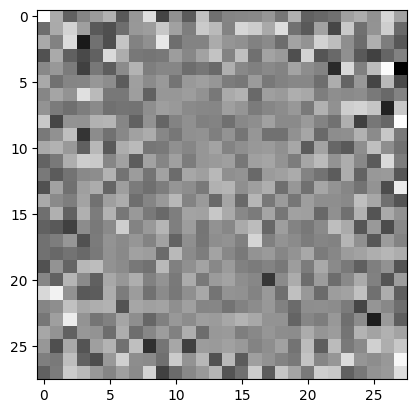

Epoch [97/100], i: 0, Loss: 0.9375
Epoch [97/100], i: 100, Loss: 0.9378
Epoch [97/100], i: 200, Loss: 0.9287
Epoch [97/100], i: 300, Loss: 0.9428
Epoch [97/100], i: 400, Loss: 0.9372
Epoch [98/100], i: 0, Loss: 0.9301
Epoch [98/100], i: 100, Loss: 0.9353
Epoch [98/100], i: 200, Loss: 0.9352
Epoch [98/100], i: 300, Loss: 0.9340
Epoch [98/100], i: 400, Loss: 0.9391
Epoch [99/100], i: 0, Loss: 0.9362
Epoch [99/100], i: 100, Loss: 0.9426
Epoch [99/100], i: 200, Loss: 0.9336
Epoch [99/100], i: 300, Loss: 0.9425
Epoch [99/100], i: 400, Loss: 0.9310
Epoch [100/100], i: 0, Loss: 0.9335
Epoch [100/100], i: 100, Loss: 0.9383
Epoch [100/100], i: 200, Loss: 0.9332
Epoch [100/100], i: 300, Loss: 0.9372
Epoch [100/100], i: 400, Loss: 0.9341


In [101]:
for epoch in range(100):
    i=0
    for data, labels in trainloader:
        
        ## data here is 128 batch size of each image and labels is 128 batch size of each label
        data, labels = data.to(device), labels.to(device)
        
        optimizer.zero_grad()

        # t here is random integer with values between 0 and 999, representing timesteps for each example in the batch
        t = torch.randint(0, 1000, (data.shape[0],), device=device)
       

        # generates random noise (mean 0, sd 1) tensor with the same shape as input data
        noise = torch.randn_like(data)

        # adds noise to input data based on timesteps. Scales noise by  a factor calculated using the timesteps
        # In diffusion models, the noise is gradually added to the data over the course of the diffusion process. The amount of noise added at each timestep is typically proportional to the square root of the timestep value. This is derived from the continuous-time formulation of the diffusion process.
        noisy_data = data + noise * torch.sqrt(t.view(-1,1,1,1)/999)
        
        predicted_noise = model(noisy_data, t, labels)
        loss = criterion(predicted_noise, noise)
        loss.backward()
        optimizer.step()
        if((i%100)==0):
            print(f"Epoch [{epoch+1}/100], i: {i}, Loss: {loss.item():.4f}")
        
        i+=1

    if(epoch%5==0):
        sample_image()
    

In [88]:
# sampling loop
def sample_image():
    target_label = 5
    
    with torch.no_grad():
        x = torch.randn(1,1,28,28).to(device)
        y = torch.tensor([target_label]).to(device)
        for t in range(999, -1, -1):
            z = torch.randn(1,1,28,28).to(device) if t > 0 else torch.zeros(1,1,28,28).to(device)
            t_tensor = torch.tensor([t]).to(device)
            predicted_noise = model(x,t_tensor,y)
            # simply remove the predicted noise
            x = x - predicted_noise

    import matplotlib.pyplot as plt
    plt.imshow(x.cpu().squeeze().numpy(), cmap="gray")
    plt.show()

        ## dont understand the following. is it needed?
        #x = x - (1/torch.sqrt(t_tensor)) * model(x,t_tensor,y)
        #x = (1/torch.sqrt(1-(t_tensor/999))) * (x - (t/999) * model(x,t_tensor,y))
        #x = x + torch.sqrt((t_tensor/999)) * z

In [85]:
x

tensor([[[[-1.0384e+02, -4.4782e+01,  3.4559e+01, -4.4652e-01,  9.2238e+01,
           -7.0420e+01, -1.1978e+02,  3.0336e+00,  7.9308e+01,  1.4340e+01,
           -3.0719e+01, -2.5602e+01, -5.1300e+01, -1.3671e+01,  1.1107e+01,
           -4.2985e+01, -3.7337e+01,  1.0904e+01, -2.1331e+01,  2.7999e+01,
           -9.3157e+00, -6.4620e+01,  1.4634e+01,  3.0676e+01, -2.2861e+01,
            1.4669e+00, -2.8569e+01, -6.8986e+00],
          [-1.0871e+02,  3.5722e+01, -1.8166e+01,  3.3139e+01, -8.1001e+00,
            4.7536e+01, -1.0266e+02,  9.1836e+00, -2.7170e+01, -3.9186e+01,
           -1.0122e+01,  1.0597e+01,  4.0726e+01, -3.7079e+01, -1.1417e+00,
           -1.1724e+00,  3.5812e+01,  1.2172e+01,  2.0073e+01, -3.6312e+01,
            5.0638e+01, -6.3250e+01, -8.7315e+00, -2.1879e+01, -2.1457e+01,
            9.1969e+01, -6.0167e+01, -4.1704e+01],
          [ 1.7909e-01,  1.9417e+01,  3.6314e+00,  3.1040e+01,  2.1939e+01,
            3.1866e+00,  1.4957e+02, -5.8016e+01,  4.1297e+01,

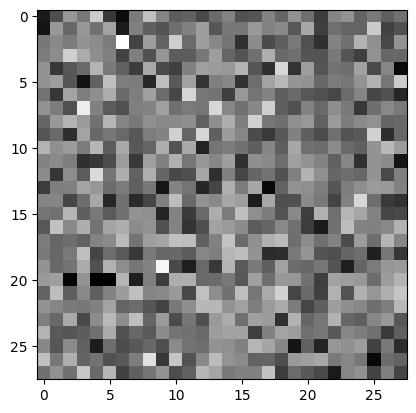

In [86]:
import matplotlib.pyplot as plt
plt.imshow(x.cpu().squeeze().numpy(), cmap="gray")
plt.show()

### Training loss doesn't seem to be going down

it is stuck at 0.93 something

Let's try to make the network bigger and add batch normalization

In [106]:
class DiffusionModel(nn.Module):
    def __init__(self, img_size, timesteps, num_classes):
        super().__init__()
        self.img_size = img_size
        self.timesteps = timesteps
        self.num_classes = num_classes
        self.net = nn.Sequential(
            nn.Linear(img_size * img_size + 1 + num_classes, 256),
            #nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 512),
            #nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            #nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            #nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 256),
            #nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, img_size * img_size),
        )

    def forward(self, x, t, y):
        x = x.view(-1, self.img_size * self.img_size)
        t = t.unsqueeze(1)  # Add an extra dimension to t
        y = nn.functional.one_hot(y, num_classes=self.num_classes).float()
        x = torch.cat([x,t,y], dim=1)
        return self.net(x).view(-1,1,self.img_size, self.img_size)

In [107]:
transform = transforms.Compose([transforms.ToTensor()])
trainset = datasets.MNIST('data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)

In [108]:
model = DiffusionModel(img_size=28, timesteps=1000, num_classes=10).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

Epoch [1/100], i: 0, Loss: 1.0193
Epoch [1/100], i: 100, Loss: 1.0006
Epoch [1/100], i: 200, Loss: 1.0005
Epoch [1/100], i: 300, Loss: 0.9923
Epoch [1/100], i: 400, Loss: 0.9922


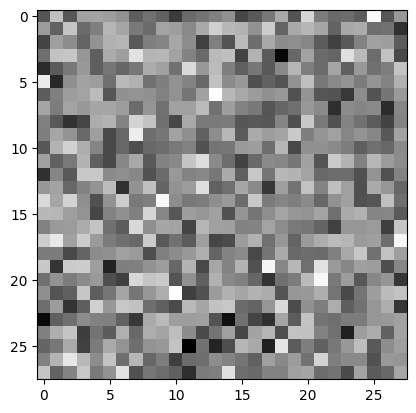

Epoch [2/100], i: 0, Loss: 0.9912
Epoch [2/100], i: 100, Loss: 0.9848
Epoch [2/100], i: 200, Loss: 0.9833
Epoch [2/100], i: 300, Loss: 0.9817
Epoch [2/100], i: 400, Loss: 0.9871
Epoch [3/100], i: 0, Loss: 0.9787
Epoch [3/100], i: 100, Loss: 0.9753
Epoch [3/100], i: 200, Loss: 0.9816
Epoch [3/100], i: 300, Loss: 0.9745
Epoch [3/100], i: 400, Loss: 0.9854
Epoch [4/100], i: 0, Loss: 0.9733
Epoch [4/100], i: 100, Loss: 0.9748
Epoch [4/100], i: 200, Loss: 0.9838
Epoch [4/100], i: 300, Loss: 0.9778
Epoch [4/100], i: 400, Loss: 0.9794
Epoch [5/100], i: 0, Loss: 0.9871
Epoch [5/100], i: 100, Loss: 0.9826
Epoch [5/100], i: 200, Loss: 0.9769
Epoch [5/100], i: 300, Loss: 0.9760
Epoch [5/100], i: 400, Loss: 0.9676
Epoch [6/100], i: 0, Loss: 0.9764
Epoch [6/100], i: 100, Loss: 0.9914
Epoch [6/100], i: 200, Loss: 0.9802
Epoch [6/100], i: 300, Loss: 0.9819
Epoch [6/100], i: 400, Loss: 0.9815


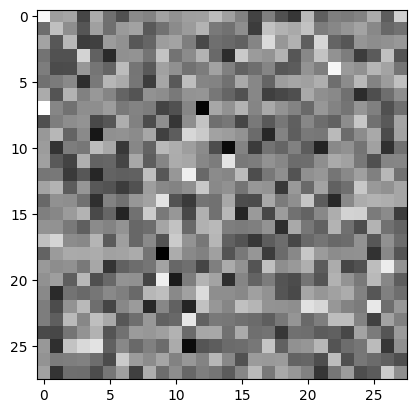

Epoch [7/100], i: 0, Loss: 0.9843
Epoch [7/100], i: 100, Loss: 0.9796
Epoch [7/100], i: 200, Loss: 0.9795
Epoch [7/100], i: 300, Loss: 0.9778
Epoch [7/100], i: 400, Loss: 0.9757
Epoch [8/100], i: 0, Loss: 0.9752
Epoch [8/100], i: 100, Loss: 0.9851
Epoch [8/100], i: 200, Loss: 0.9846
Epoch [8/100], i: 300, Loss: 0.9830
Epoch [8/100], i: 400, Loss: 0.9704
Epoch [9/100], i: 0, Loss: 0.9857
Epoch [9/100], i: 100, Loss: 0.9799
Epoch [9/100], i: 200, Loss: 0.9814
Epoch [9/100], i: 300, Loss: 0.9780
Epoch [9/100], i: 400, Loss: 0.9824
Epoch [10/100], i: 0, Loss: 0.9845
Epoch [10/100], i: 100, Loss: 0.9776
Epoch [10/100], i: 200, Loss: 0.9798
Epoch [10/100], i: 300, Loss: 0.9831
Epoch [10/100], i: 400, Loss: 0.9828
Epoch [11/100], i: 0, Loss: 0.9790
Epoch [11/100], i: 100, Loss: 0.9854
Epoch [11/100], i: 200, Loss: 0.9789
Epoch [11/100], i: 300, Loss: 0.9712
Epoch [11/100], i: 400, Loss: 0.9774


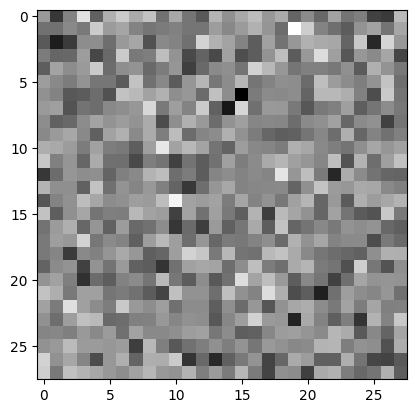

Epoch [12/100], i: 0, Loss: 0.9844
Epoch [12/100], i: 100, Loss: 0.9816
Epoch [12/100], i: 200, Loss: 0.9850
Epoch [12/100], i: 300, Loss: 0.9777
Epoch [12/100], i: 400, Loss: 0.9811
Epoch [13/100], i: 0, Loss: 0.9773
Epoch [13/100], i: 100, Loss: 0.9773
Epoch [13/100], i: 200, Loss: 0.9811
Epoch [13/100], i: 300, Loss: 0.9775
Epoch [13/100], i: 400, Loss: 0.9856
Epoch [14/100], i: 0, Loss: 0.9772
Epoch [14/100], i: 100, Loss: 0.9737
Epoch [14/100], i: 200, Loss: 0.9800
Epoch [14/100], i: 300, Loss: 0.9837
Epoch [14/100], i: 400, Loss: 0.9790
Epoch [15/100], i: 0, Loss: 0.9760
Epoch [15/100], i: 100, Loss: 0.9816
Epoch [15/100], i: 200, Loss: 0.9862
Epoch [15/100], i: 300, Loss: 0.9820
Epoch [15/100], i: 400, Loss: 0.9896
Epoch [16/100], i: 0, Loss: 0.9820
Epoch [16/100], i: 100, Loss: 0.9859
Epoch [16/100], i: 200, Loss: 0.9804
Epoch [16/100], i: 300, Loss: 0.9813
Epoch [16/100], i: 400, Loss: 0.9837


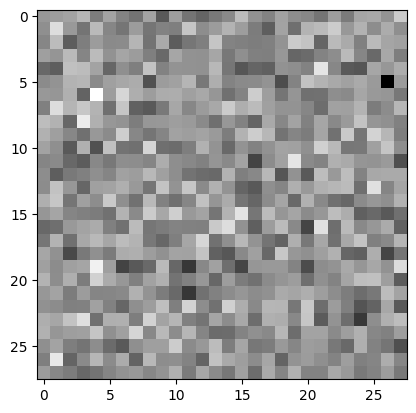

Epoch [17/100], i: 0, Loss: 0.9797
Epoch [17/100], i: 100, Loss: 0.9782
Epoch [17/100], i: 200, Loss: 0.9775


KeyboardInterrupt: 

In [109]:
for epoch in range(100):
    i=0
    for data, labels in trainloader:
        
        ## data here is 128 batch size of each image and labels is 128 batch size of each label
        data, labels = data.to(device), labels.to(device)
        
        optimizer.zero_grad()

        # t here is random integer with values between 0 and 999, representing timesteps for each example in the batch
        t = torch.randint(0, 1000, (data.shape[0],), device=device)
       

        # generates random noise (mean 0, sd 1) tensor with the same shape as input data
        noise = torch.randn_like(data)

        # adds noise to input data based on timesteps. Scales noise by  a factor calculated using the timesteps
        # In diffusion models, the noise is gradually added to the data over the course of the diffusion process. The amount of noise added at each timestep is typically proportional to the square root of the timestep value. This is derived from the continuous-time formulation of the diffusion process.
        noisy_data = data + noise * torch.sqrt(t.view(-1,1,1,1)/999)
        
        predicted_noise = model(noisy_data, t, labels)
        loss = criterion(predicted_noise, noise)
        loss.backward()
        optimizer.step()
        if((i%100)==0):
            print(f"Epoch [{epoch+1}/100], i: {i}, Loss: {loss.item():.4f}")
        
        i+=1

    if(epoch%5==0):
        sample_image()
    

### Loss is not coming down, let's add skip connections and batch norm

In [110]:
class DiffusionModel(nn.Module):
    def __init__(self, img_size, timesteps, num_classes):
        super().__init__()
        self.img_size = img_size
        self.timesteps = timesteps
        self.num_classes = num_classes
        
        self.encoder = nn.Sequential(
            nn.Linear(img_size * img_size + 1 + num_classes, 256),
            nn.BatchNorm1d(256),
            nn.ReLU()
        )
        
        self.residual_blocks = nn.ModuleList([
            nn.Sequential(
                nn.Linear(256, 256),
                nn.BatchNorm1d(256),
                nn.ReLU(),
                nn.Linear(256, 256),
                nn.BatchNorm1d(256),
                nn.ReLU()
            ) for _ in range(3)  # Number of residual blocks
        ])
        
        self.decoder = nn.Sequential(
            nn.Linear(256, img_size * img_size)
        )

    def forward(self, x, t, y):
        x = x.view(-1, self.img_size * self.img_size)
        t = t.unsqueeze(1)
        y = nn.functional.one_hot(y, num_classes=self.num_classes).float()
        
        x = torch.cat([x, t, y], dim=1)
        x = self.encoder(x)
        
        for block in self.residual_blocks:
            residual = x
            x = block(x)
            x = x + residual  # Skip connection
        
        x = self.decoder(x)
        return x.view(-1, 1, self.img_size, self.img_size)

In [117]:
# we need to update sample image for batch norm as it expects batch dimension and also generates in batches

import random

def sample_image_batchnorm(batch_size=1):
    with torch.no_grad():
        x = torch.randn(batch_size, 1, 28, 28).to(device)
        y = torch.randint(0, 10, (batch_size,)).to(device)  # Generate random target labels
        for t in range(999, -1, -1):
            z = torch.randn(batch_size, 1, 28, 28).to(device) if t > 0 else torch.zeros(batch_size, 1, 28, 28).to(device)
            t_tensor = torch.tensor([t]).expand(batch_size).to(device)
            # ^ this is the difference from previous one
            
            predicted_noise = model(x, t_tensor, y)
            x = x - predicted_noise

    import matplotlib.pyplot as plt
    fig, axs = plt.subplots(1, batch_size, figsize=(batch_size * 2, 2))
    for i in range(batch_size):
        axs[i].imshow(x[i].cpu().squeeze().numpy(), cmap="gray")
        axs[i].set_title(f"Digit: {y[i].item()}")
        axs[i].axis("off")
    plt.tight_layout()
    plt.show()

In [118]:
transform = transforms.Compose([transforms.ToTensor()])
trainset = datasets.MNIST('data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)
model = DiffusionModel(img_size=28, timesteps=1000, num_classes=10).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

In [121]:
def train():
    for epoch in range(100):
        i=0
        for data, labels in trainloader:
            
            ## data here is 128 batch size of each image and labels is 128 batch size of each label
            data, labels = data.to(device), labels.to(device)
            
            optimizer.zero_grad()
    
            # t here is random integer with values between 0 and 999, representing timesteps for each example in the batch
            t = torch.randint(0, 1000, (data.shape[0],), device=device)
           
    
            # generates random noise (mean 0, sd 1) tensor with the same shape as input data
            noise = torch.randn_like(data)
    
            # adds noise to input data based on timesteps. Scales noise by  a factor calculated using the timesteps
            # In diffusion models, the noise is gradually added to the data over the course of the diffusion process. The amount of noise added at each timestep is typically proportional to the square root of the timestep value. This is derived from the continuous-time formulation of the diffusion process.
            noisy_data = data + noise * torch.sqrt(t.view(-1,1,1,1)/999)
            
            predicted_noise = model(noisy_data, t, labels)
            loss = criterion(predicted_noise, noise)
            loss.backward()
            optimizer.step()
            if((i%100)==0):
                print(f"Epoch [{epoch+1}/100], i: {i}, Loss: {loss.item():.4f}")
            
            i+=1
    
        if(epoch%5==0):
            sample_image_batchnorm(batch_size=4)
    

### Model seems to be converging at 0.70, let's try more steps
- learning rate reduce (by 10 times)

In [122]:
transform = transforms.Compose([transforms.ToTensor()])
trainset = datasets.MNIST('data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)
model = DiffusionModel(img_size=28, timesteps=1000, num_classes=10).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

Epoch [1/100], i: 0, Loss: 2.3486
Epoch [1/100], i: 100, Loss: 1.0270
Epoch [1/100], i: 200, Loss: 1.0102
Epoch [1/100], i: 300, Loss: 0.9997
Epoch [1/100], i: 400, Loss: 0.9975


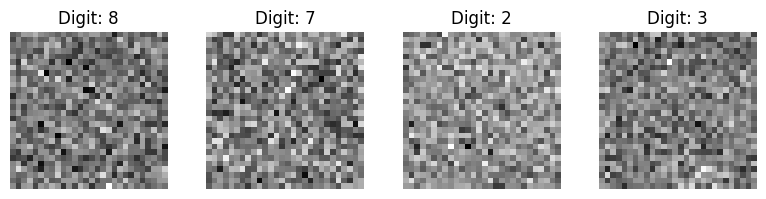

Epoch [2/100], i: 0, Loss: 0.9961
Epoch [2/100], i: 100, Loss: 0.9900
Epoch [2/100], i: 200, Loss: 0.9929
Epoch [2/100], i: 300, Loss: 0.9880
Epoch [2/100], i: 400, Loss: 0.9721
Epoch [3/100], i: 0, Loss: 0.9722
Epoch [3/100], i: 100, Loss: 0.9475
Epoch [3/100], i: 200, Loss: 0.9355
Epoch [3/100], i: 300, Loss: 0.9293
Epoch [3/100], i: 400, Loss: 0.9133
Epoch [4/100], i: 0, Loss: 0.8968
Epoch [4/100], i: 100, Loss: 0.8882
Epoch [4/100], i: 200, Loss: 0.8873
Epoch [4/100], i: 300, Loss: 0.8701
Epoch [4/100], i: 400, Loss: 0.8639
Epoch [5/100], i: 0, Loss: 0.8511
Epoch [5/100], i: 100, Loss: 0.8414
Epoch [5/100], i: 200, Loss: 0.8409
Epoch [5/100], i: 300, Loss: 0.8278
Epoch [5/100], i: 400, Loss: 0.8299
Epoch [6/100], i: 0, Loss: 0.8262
Epoch [6/100], i: 100, Loss: 0.8240
Epoch [6/100], i: 200, Loss: 0.8237
Epoch [6/100], i: 300, Loss: 0.8102
Epoch [6/100], i: 400, Loss: 0.8112


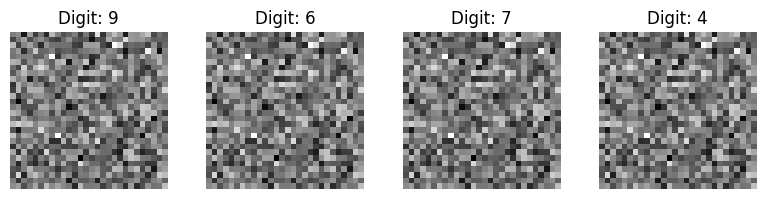

Epoch [7/100], i: 0, Loss: 0.8145
Epoch [7/100], i: 100, Loss: 0.8015
Epoch [7/100], i: 200, Loss: 0.8020
Epoch [7/100], i: 300, Loss: 0.8004
Epoch [7/100], i: 400, Loss: 0.7957
Epoch [8/100], i: 0, Loss: 0.7887
Epoch [8/100], i: 100, Loss: 0.7842
Epoch [8/100], i: 200, Loss: 0.7856
Epoch [8/100], i: 300, Loss: 0.7905
Epoch [8/100], i: 400, Loss: 0.7875
Epoch [9/100], i: 0, Loss: 0.7863
Epoch [9/100], i: 100, Loss: 0.7819
Epoch [9/100], i: 200, Loss: 0.7841
Epoch [9/100], i: 300, Loss: 0.7827
Epoch [9/100], i: 400, Loss: 0.7738
Epoch [10/100], i: 0, Loss: 0.7732
Epoch [10/100], i: 100, Loss: 0.7746
Epoch [10/100], i: 200, Loss: 0.7759
Epoch [10/100], i: 300, Loss: 0.7729
Epoch [10/100], i: 400, Loss: 0.7727
Epoch [11/100], i: 0, Loss: 0.7697
Epoch [11/100], i: 100, Loss: 0.7652
Epoch [11/100], i: 200, Loss: 0.7621
Epoch [11/100], i: 300, Loss: 0.7731
Epoch [11/100], i: 400, Loss: 0.7630


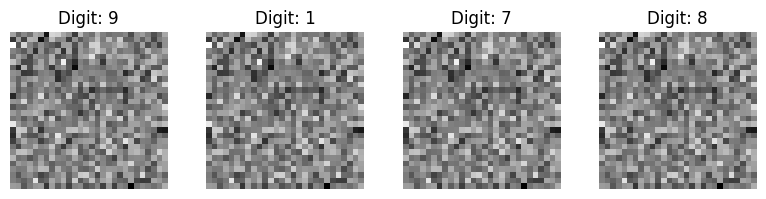

Epoch [12/100], i: 0, Loss: 0.7661
Epoch [12/100], i: 100, Loss: 0.7635
Epoch [12/100], i: 200, Loss: 0.7635
Epoch [12/100], i: 300, Loss: 0.7616
Epoch [12/100], i: 400, Loss: 0.7596
Epoch [13/100], i: 0, Loss: 0.7600
Epoch [13/100], i: 100, Loss: 0.7597
Epoch [13/100], i: 200, Loss: 0.7574
Epoch [13/100], i: 300, Loss: 0.7557
Epoch [13/100], i: 400, Loss: 0.7559
Epoch [14/100], i: 0, Loss: 0.7608
Epoch [14/100], i: 100, Loss: 0.7555
Epoch [14/100], i: 200, Loss: 0.7504
Epoch [14/100], i: 300, Loss: 0.7515
Epoch [14/100], i: 400, Loss: 0.7519
Epoch [15/100], i: 0, Loss: 0.7575
Epoch [15/100], i: 100, Loss: 0.7492
Epoch [15/100], i: 200, Loss: 0.7470
Epoch [15/100], i: 300, Loss: 0.7540
Epoch [15/100], i: 400, Loss: 0.7520
Epoch [16/100], i: 0, Loss: 0.7499
Epoch [16/100], i: 100, Loss: 0.7499
Epoch [16/100], i: 200, Loss: 0.7451
Epoch [16/100], i: 300, Loss: 0.7619
Epoch [16/100], i: 400, Loss: 0.7483


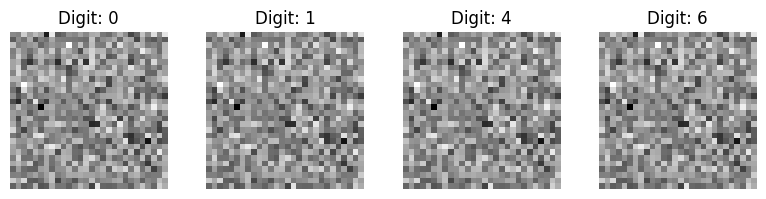

Epoch [17/100], i: 0, Loss: 0.7523
Epoch [17/100], i: 100, Loss: 0.7427
Epoch [17/100], i: 200, Loss: 0.7389
Epoch [17/100], i: 300, Loss: 0.7463
Epoch [17/100], i: 400, Loss: 0.7407
Epoch [18/100], i: 0, Loss: 0.7495
Epoch [18/100], i: 100, Loss: 0.7411
Epoch [18/100], i: 200, Loss: 0.7381
Epoch [18/100], i: 300, Loss: 0.7372
Epoch [18/100], i: 400, Loss: 0.7506
Epoch [19/100], i: 0, Loss: 0.7453
Epoch [19/100], i: 100, Loss: 0.7395
Epoch [19/100], i: 200, Loss: 0.7363
Epoch [19/100], i: 300, Loss: 0.7349
Epoch [19/100], i: 400, Loss: 0.7351
Epoch [20/100], i: 0, Loss: 0.7395
Epoch [20/100], i: 100, Loss: 0.7335
Epoch [20/100], i: 200, Loss: 0.7368
Epoch [20/100], i: 300, Loss: 0.7354
Epoch [20/100], i: 400, Loss: 0.7393
Epoch [21/100], i: 0, Loss: 0.7326


KeyboardInterrupt: 

In [123]:
train()

### Let's try an even larger model (and add residual connection from the first layer itself)

- learning rate 1e-3

In [125]:
class DiffusionModel(nn.Module):
    def __init__(self, img_size, timesteps, num_classes):
        super().__init__()
        self.img_size = img_size
        self.timesteps = timesteps
        self.num_classes = num_classes
        
        self.encoder = nn.Sequential(
            nn.Linear(img_size * img_size + 1 + num_classes, 256),
            nn.BatchNorm1d(256),
            nn.ReLU()
        )
        
        self.residual_blocks = nn.ModuleList([
            nn.Sequential(
                nn.Linear(256, 256),
                nn.BatchNorm1d(256),
                nn.ReLU(),
                nn.Linear(256, 256),
                nn.BatchNorm1d(256),
                nn.ReLU()
            ) for _ in range(10)  # Number of residual blocks (changed to 10)
        ])
        
        self.decoder = nn.Sequential(
            nn.Linear(256, img_size * img_size)
        )

    def forward(self, x, t, y):
        x_orig = x.view(-1, self.img_size * self.img_size) ## for residual connection
        t = t.unsqueeze(1)
        y = nn.functional.one_hot(y, num_classes=self.num_classes).float()
        
        x = torch.cat([x_orig, t, y], dim=1)
        x = self.encoder(x)
        
        for block in self.residual_blocks:
            residual = x
            x = block(x)
            x = x + residual  # Skip connection within residual blocks
        
        x = self.decoder(x)
        x = x + x_orig  # Residual connection from pixel values
        
        return x.view(-1, 1, self.img_size, self.img_size)

In [126]:
transform = transforms.Compose([transforms.ToTensor()])
trainset = datasets.MNIST('data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)
model = DiffusionModel(img_size=28, timesteps=1000, num_classes=10).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

Epoch [1/100], i: 0, Loss: 8.3096
Epoch [1/100], i: 100, Loss: 0.2257
Epoch [1/100], i: 200, Loss: 0.2496
Epoch [1/100], i: 300, Loss: 0.2517
Epoch [1/100], i: 400, Loss: 0.2651


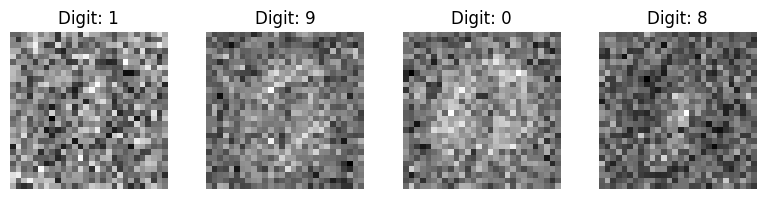

Epoch [2/100], i: 0, Loss: 0.2444
Epoch [2/100], i: 100, Loss: 0.2176
Epoch [2/100], i: 200, Loss: 0.2202
Epoch [2/100], i: 300, Loss: 0.2007
Epoch [2/100], i: 400, Loss: 0.2214
Epoch [3/100], i: 0, Loss: 0.2133
Epoch [3/100], i: 100, Loss: 0.2342
Epoch [3/100], i: 200, Loss: 0.2240
Epoch [3/100], i: 300, Loss: 0.2042
Epoch [3/100], i: 400, Loss: 0.2064
Epoch [4/100], i: 0, Loss: 0.1888
Epoch [4/100], i: 100, Loss: 0.1995
Epoch [4/100], i: 200, Loss: 0.1969
Epoch [4/100], i: 300, Loss: 0.1940
Epoch [4/100], i: 400, Loss: 0.1947
Epoch [5/100], i: 0, Loss: 0.1803
Epoch [5/100], i: 100, Loss: 0.1981
Epoch [5/100], i: 200, Loss: 0.2047
Epoch [5/100], i: 300, Loss: 0.1816
Epoch [5/100], i: 400, Loss: 0.1907
Epoch [6/100], i: 0, Loss: 0.2047
Epoch [6/100], i: 100, Loss: 0.2053
Epoch [6/100], i: 200, Loss: 0.2086
Epoch [6/100], i: 300, Loss: 0.2327
Epoch [6/100], i: 400, Loss: 0.2054


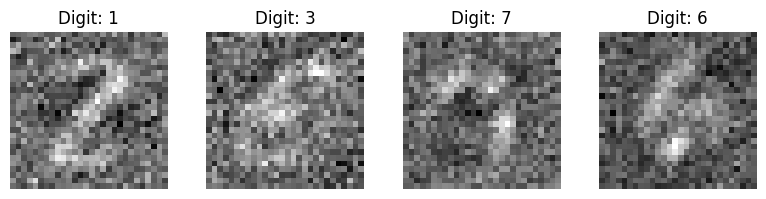

Epoch [7/100], i: 0, Loss: 0.1879
Epoch [7/100], i: 100, Loss: 0.1969
Epoch [7/100], i: 200, Loss: 0.2025
Epoch [7/100], i: 300, Loss: 0.1754
Epoch [7/100], i: 400, Loss: 0.2000
Epoch [8/100], i: 0, Loss: 0.2036
Epoch [8/100], i: 100, Loss: 0.1831
Epoch [8/100], i: 200, Loss: 0.1959
Epoch [8/100], i: 300, Loss: 0.1645
Epoch [8/100], i: 400, Loss: 0.1684
Epoch [9/100], i: 0, Loss: 0.1598
Epoch [9/100], i: 100, Loss: 0.1908
Epoch [9/100], i: 200, Loss: 0.1948
Epoch [9/100], i: 300, Loss: 0.1768
Epoch [9/100], i: 400, Loss: 0.1759
Epoch [10/100], i: 0, Loss: 0.1682
Epoch [10/100], i: 100, Loss: 0.1450
Epoch [10/100], i: 200, Loss: 0.1554
Epoch [10/100], i: 300, Loss: 0.1596
Epoch [10/100], i: 400, Loss: 0.1772
Epoch [11/100], i: 0, Loss: 0.2018
Epoch [11/100], i: 100, Loss: 0.1880
Epoch [11/100], i: 200, Loss: 0.1722
Epoch [11/100], i: 300, Loss: 0.2074
Epoch [11/100], i: 400, Loss: 0.2055


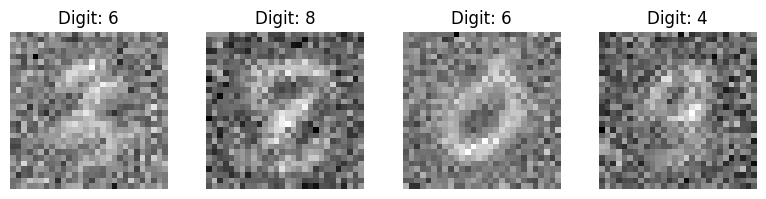

Epoch [12/100], i: 0, Loss: 0.1764
Epoch [12/100], i: 100, Loss: 0.1715
Epoch [12/100], i: 200, Loss: 0.1856
Epoch [12/100], i: 300, Loss: 0.1663
Epoch [12/100], i: 400, Loss: 0.2105
Epoch [13/100], i: 0, Loss: 0.1781
Epoch [13/100], i: 100, Loss: 0.1763
Epoch [13/100], i: 200, Loss: 0.2311
Epoch [13/100], i: 300, Loss: 0.1828
Epoch [13/100], i: 400, Loss: 0.2009
Epoch [14/100], i: 0, Loss: 0.1772
Epoch [14/100], i: 100, Loss: 0.1897
Epoch [14/100], i: 200, Loss: 0.1964
Epoch [14/100], i: 300, Loss: 0.1336
Epoch [14/100], i: 400, Loss: 0.1859
Epoch [15/100], i: 0, Loss: 0.2070
Epoch [15/100], i: 100, Loss: 0.1717
Epoch [15/100], i: 200, Loss: 0.1725
Epoch [15/100], i: 300, Loss: 0.1997
Epoch [15/100], i: 400, Loss: 0.1743
Epoch [16/100], i: 0, Loss: 0.1860
Epoch [16/100], i: 100, Loss: 0.1979
Epoch [16/100], i: 200, Loss: 0.1889
Epoch [16/100], i: 300, Loss: 0.1529
Epoch [16/100], i: 400, Loss: 0.2071


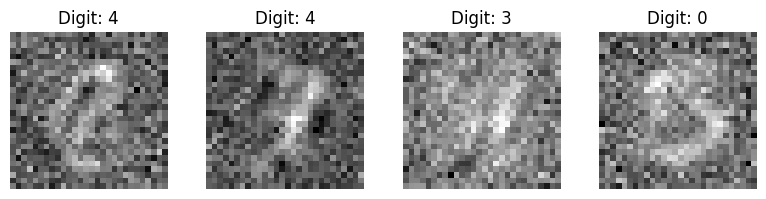

Epoch [17/100], i: 0, Loss: 0.2114


KeyboardInterrupt: 

In [127]:
train()

### Now we are generating somewhat number looking images, let's do two changes
- Give model more capacity (wider layers)
- Increase denoising steps by 10x

In [129]:
class DiffusionModel(nn.Module):
    def __init__(self, img_size, timesteps, num_classes):
        super().__init__()
        self.img_size = img_size
        self.timesteps = timesteps
        self.num_classes = num_classes
        
        self.encoder = nn.Sequential(
            nn.Linear(img_size * img_size + 1 + num_classes, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU()
        )
        
        self.residual_blocks = nn.ModuleList([
            nn.Sequential(
                nn.Linear(1024, 1024),
                nn.BatchNorm1d(1024),
                nn.ReLU(),
                nn.Linear(1024, 1024),
                nn.BatchNorm1d(1024),
                nn.ReLU()
            ) for _ in range(10)  # Number of residual blocks (changed to 10)
        ])
        
        self.decoder = nn.Sequential(
            nn.Linear(1024, img_size * img_size)
        )

    def forward(self, x, t, y):
        x_orig = x.view(-1, self.img_size * self.img_size) ## for residual connection
        t = t.unsqueeze(1)
        y = nn.functional.one_hot(y, num_classes=self.num_classes).float()
        
        x = torch.cat([x_orig, t, y], dim=1)
        x = self.encoder(x)
        
        for block in self.residual_blocks:
            residual = x
            x = block(x)
            x = x + residual  # Skip connection within residual blocks
        
        x = self.decoder(x)
        x = x + x_orig  # Residual connection from pixel values
        
        return x.view(-1, 1, self.img_size, self.img_size)

In [130]:
# we need to update sample image for batch norm as it expects batch dimension and also generates in batches

import random

def sample_image_batchnorm(batch_size=1):
    with torch.no_grad():
        x = torch.randn(batch_size, 1, 28, 28).to(device)
        y = torch.randint(0, 10, (batch_size,)).to(device)  # Generate random target labels
        for t in range(9999, -1, -1):
            z = torch.randn(batch_size, 1, 28, 28).to(device) if t > 0 else torch.zeros(batch_size, 1, 28, 28).to(device)
            t_tensor = torch.tensor([t]).expand(batch_size).to(device)
            # ^ this is the difference from previous one
            
            predicted_noise = model(x, t_tensor, y)
            x = x - predicted_noise

    import matplotlib.pyplot as plt
    fig, axs = plt.subplots(1, batch_size, figsize=(batch_size * 2, 2))
    for i in range(batch_size):
        axs[i].imshow(x[i].cpu().squeeze().numpy(), cmap="gray")
        axs[i].set_title(f"Digit: {y[i].item()}")
        axs[i].axis("off")
    plt.tight_layout()
    plt.show()

In [131]:
transform = transforms.Compose([transforms.ToTensor()])
trainset = datasets.MNIST('data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)
model = DiffusionModel(img_size=28, timesteps=10000, num_classes=10).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

Epoch [1/100], i: 0, Loss: 7.8964
Epoch [1/100], i: 100, Loss: 0.2368
Epoch [1/100], i: 200, Loss: 0.2349
Epoch [1/100], i: 300, Loss: 0.2222
Epoch [1/100], i: 400, Loss: 0.2205


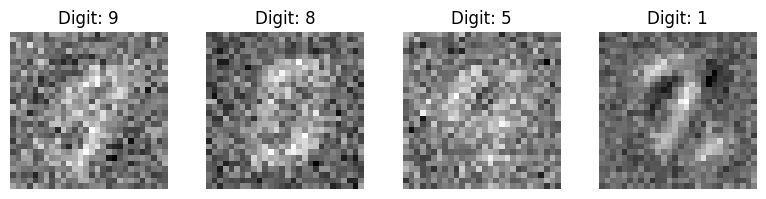

Epoch [2/100], i: 0, Loss: 0.2016
Epoch [2/100], i: 100, Loss: 0.2136
Epoch [2/100], i: 200, Loss: 0.1916
Epoch [2/100], i: 300, Loss: 0.1809
Epoch [2/100], i: 400, Loss: 0.1924
Epoch [3/100], i: 0, Loss: 0.1934
Epoch [3/100], i: 100, Loss: 0.2164
Epoch [3/100], i: 200, Loss: 0.1869
Epoch [3/100], i: 300, Loss: 0.2086
Epoch [3/100], i: 400, Loss: 0.1747
Epoch [4/100], i: 0, Loss: 0.1594
Epoch [4/100], i: 100, Loss: 0.1816
Epoch [4/100], i: 200, Loss: 0.1549
Epoch [4/100], i: 300, Loss: 0.1776
Epoch [4/100], i: 400, Loss: 0.1949
Epoch [5/100], i: 0, Loss: 0.1647
Epoch [5/100], i: 100, Loss: 0.1637
Epoch [5/100], i: 200, Loss: 0.1774
Epoch [5/100], i: 300, Loss: 0.1944
Epoch [5/100], i: 400, Loss: 0.1698
Epoch [6/100], i: 0, Loss: 0.1844
Epoch [6/100], i: 100, Loss: 0.1577
Epoch [6/100], i: 200, Loss: 0.2004
Epoch [6/100], i: 300, Loss: 0.1649
Epoch [6/100], i: 400, Loss: 0.1591


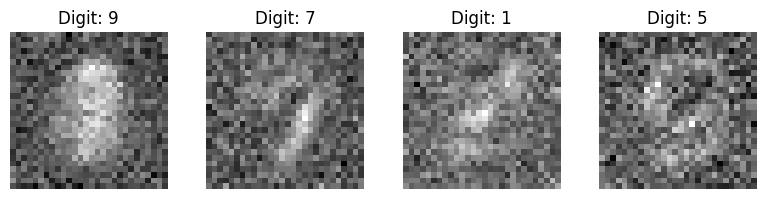

Epoch [7/100], i: 0, Loss: 0.1519
Epoch [7/100], i: 100, Loss: 0.1516
Epoch [7/100], i: 200, Loss: 0.1897
Epoch [7/100], i: 300, Loss: 0.1524
Epoch [7/100], i: 400, Loss: 0.1652
Epoch [8/100], i: 0, Loss: 0.1570
Epoch [8/100], i: 100, Loss: 0.1844
Epoch [8/100], i: 200, Loss: 0.1565
Epoch [8/100], i: 300, Loss: 0.1658
Epoch [8/100], i: 400, Loss: 0.1590
Epoch [9/100], i: 0, Loss: 0.1683
Epoch [9/100], i: 100, Loss: 0.1640
Epoch [9/100], i: 200, Loss: 0.1369
Epoch [9/100], i: 300, Loss: 0.1774
Epoch [9/100], i: 400, Loss: 0.1508
Epoch [10/100], i: 0, Loss: 0.1454
Epoch [10/100], i: 100, Loss: 0.1623
Epoch [10/100], i: 200, Loss: 0.1601
Epoch [10/100], i: 300, Loss: 0.1503
Epoch [10/100], i: 400, Loss: 0.1547
Epoch [11/100], i: 0, Loss: 0.1778
Epoch [11/100], i: 100, Loss: 0.1722
Epoch [11/100], i: 200, Loss: 0.1837
Epoch [11/100], i: 300, Loss: 0.1551
Epoch [11/100], i: 400, Loss: 0.1398


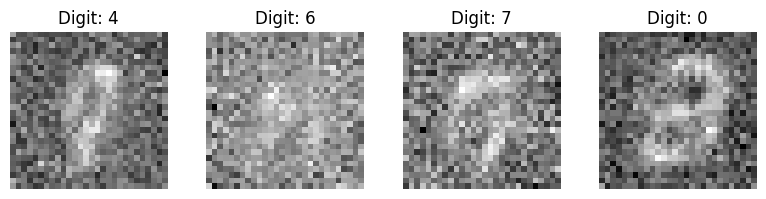

Epoch [12/100], i: 0, Loss: 0.2002
Epoch [12/100], i: 100, Loss: 0.1529
Epoch [12/100], i: 200, Loss: 0.1925
Epoch [12/100], i: 300, Loss: 0.1817
Epoch [12/100], i: 400, Loss: 0.1549
Epoch [13/100], i: 0, Loss: 0.1719
Epoch [13/100], i: 100, Loss: 0.1653
Epoch [13/100], i: 200, Loss: 0.1362
Epoch [13/100], i: 300, Loss: 0.1681
Epoch [13/100], i: 400, Loss: 0.1682
Epoch [14/100], i: 0, Loss: 0.1376
Epoch [14/100], i: 100, Loss: 0.1403
Epoch [14/100], i: 200, Loss: 0.1530
Epoch [14/100], i: 300, Loss: 0.1511
Epoch [14/100], i: 400, Loss: 0.1556
Epoch [15/100], i: 0, Loss: 0.1627
Epoch [15/100], i: 100, Loss: 0.1438
Epoch [15/100], i: 200, Loss: 0.1673
Epoch [15/100], i: 300, Loss: 0.1540
Epoch [15/100], i: 400, Loss: 0.1533
Epoch [16/100], i: 0, Loss: 0.1376
Epoch [16/100], i: 100, Loss: 0.1597
Epoch [16/100], i: 200, Loss: 0.1453
Epoch [16/100], i: 300, Loss: 0.1607
Epoch [16/100], i: 400, Loss: 0.1455


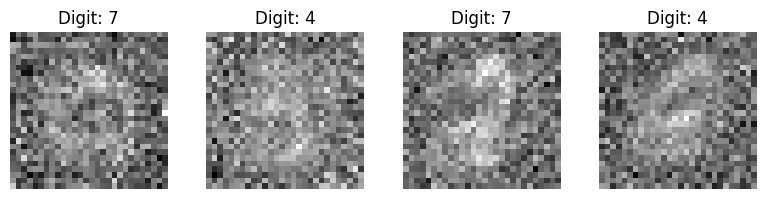

Epoch [17/100], i: 0, Loss: 0.1363
Epoch [17/100], i: 100, Loss: 0.1868
Epoch [17/100], i: 200, Loss: 0.1354
Epoch [17/100], i: 300, Loss: 0.1686
Epoch [17/100], i: 400, Loss: 0.1462
Epoch [18/100], i: 0, Loss: 0.1397
Epoch [18/100], i: 100, Loss: 0.1352
Epoch [18/100], i: 200, Loss: 0.1459
Epoch [18/100], i: 300, Loss: 0.1501
Epoch [18/100], i: 400, Loss: 0.1514
Epoch [19/100], i: 0, Loss: 0.1453
Epoch [19/100], i: 100, Loss: 0.1358
Epoch [19/100], i: 200, Loss: 0.1587
Epoch [19/100], i: 300, Loss: 0.1166
Epoch [19/100], i: 400, Loss: 0.1398
Epoch [20/100], i: 0, Loss: 0.1434
Epoch [20/100], i: 100, Loss: 0.1293
Epoch [20/100], i: 200, Loss: 0.1821
Epoch [20/100], i: 300, Loss: 0.1678
Epoch [20/100], i: 400, Loss: 0.1575
Epoch [21/100], i: 0, Loss: 0.1583
Epoch [21/100], i: 100, Loss: 0.1418
Epoch [21/100], i: 200, Loss: 0.1453
Epoch [21/100], i: 300, Loss: 0.1405
Epoch [21/100], i: 400, Loss: 0.1621


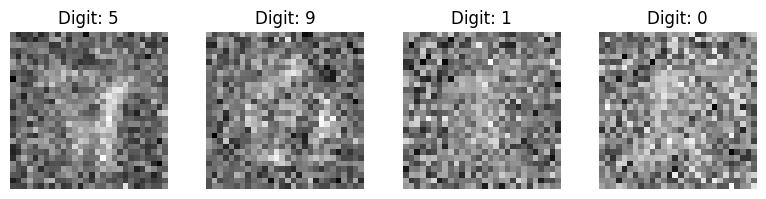

Epoch [22/100], i: 0, Loss: 0.1434
Epoch [22/100], i: 100, Loss: 0.1341
Epoch [22/100], i: 200, Loss: 0.1449
Epoch [22/100], i: 300, Loss: 0.1344
Epoch [22/100], i: 400, Loss: 0.1322
Epoch [23/100], i: 0, Loss: 0.1202
Epoch [23/100], i: 100, Loss: 0.1457
Epoch [23/100], i: 200, Loss: 0.1387
Epoch [23/100], i: 300, Loss: 0.1375
Epoch [23/100], i: 400, Loss: 0.1587
Epoch [24/100], i: 0, Loss: 0.1349
Epoch [24/100], i: 100, Loss: 0.1351
Epoch [24/100], i: 200, Loss: 0.1873
Epoch [24/100], i: 300, Loss: 0.1821
Epoch [24/100], i: 400, Loss: 0.1888
Epoch [25/100], i: 0, Loss: 0.1732
Epoch [25/100], i: 100, Loss: 0.1567
Epoch [25/100], i: 200, Loss: 0.1590
Epoch [25/100], i: 300, Loss: 0.1633
Epoch [25/100], i: 400, Loss: 0.1719
Epoch [26/100], i: 0, Loss: 0.1410
Epoch [26/100], i: 100, Loss: 0.1634
Epoch [26/100], i: 200, Loss: 0.1572
Epoch [26/100], i: 300, Loss: 0.1315
Epoch [26/100], i: 400, Loss: 0.1420


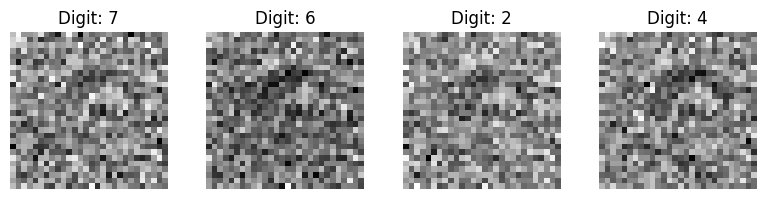

Epoch [27/100], i: 0, Loss: 0.1493
Epoch [27/100], i: 100, Loss: 0.1346
Epoch [27/100], i: 200, Loss: 0.1430
Epoch [27/100], i: 300, Loss: 0.1431
Epoch [27/100], i: 400, Loss: 0.1356
Epoch [28/100], i: 0, Loss: 0.1327
Epoch [28/100], i: 100, Loss: 0.1254
Epoch [28/100], i: 200, Loss: 0.1543
Epoch [28/100], i: 300, Loss: 0.1442
Epoch [28/100], i: 400, Loss: 0.1424
Epoch [29/100], i: 0, Loss: 0.1465
Epoch [29/100], i: 100, Loss: 0.1437
Epoch [29/100], i: 200, Loss: 0.1438
Epoch [29/100], i: 300, Loss: 0.1219
Epoch [29/100], i: 400, Loss: 0.1357
Epoch [30/100], i: 0, Loss: 0.1223
Epoch [30/100], i: 100, Loss: 0.1363
Epoch [30/100], i: 200, Loss: 0.1314
Epoch [30/100], i: 300, Loss: 0.1205
Epoch [30/100], i: 400, Loss: 0.1361
Epoch [31/100], i: 0, Loss: 0.1447
Epoch [31/100], i: 100, Loss: 0.1416
Epoch [31/100], i: 200, Loss: 0.1309
Epoch [31/100], i: 300, Loss: 0.1495
Epoch [31/100], i: 400, Loss: 0.1316


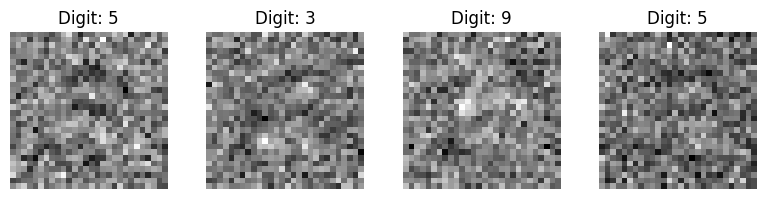

Epoch [32/100], i: 0, Loss: 0.1314
Epoch [32/100], i: 100, Loss: 0.1453
Epoch [32/100], i: 200, Loss: 0.1387
Epoch [32/100], i: 300, Loss: 0.1275
Epoch [32/100], i: 400, Loss: 0.1489
Epoch [33/100], i: 0, Loss: 0.1193
Epoch [33/100], i: 100, Loss: 0.1149
Epoch [33/100], i: 200, Loss: 0.1233
Epoch [33/100], i: 300, Loss: 0.1410
Epoch [33/100], i: 400, Loss: 0.1468
Epoch [34/100], i: 0, Loss: 0.1494
Epoch [34/100], i: 100, Loss: 0.1188
Epoch [34/100], i: 200, Loss: 0.1536
Epoch [34/100], i: 300, Loss: 0.1408
Epoch [34/100], i: 400, Loss: 0.1338
Epoch [35/100], i: 0, Loss: 0.1521
Epoch [35/100], i: 100, Loss: 0.1204
Epoch [35/100], i: 200, Loss: 0.1560
Epoch [35/100], i: 300, Loss: 0.1400
Epoch [35/100], i: 400, Loss: 0.1249
Epoch [36/100], i: 0, Loss: 0.1256
Epoch [36/100], i: 100, Loss: 0.1558
Epoch [36/100], i: 200, Loss: 0.1447
Epoch [36/100], i: 300, Loss: 0.1320
Epoch [36/100], i: 400, Loss: 0.1200


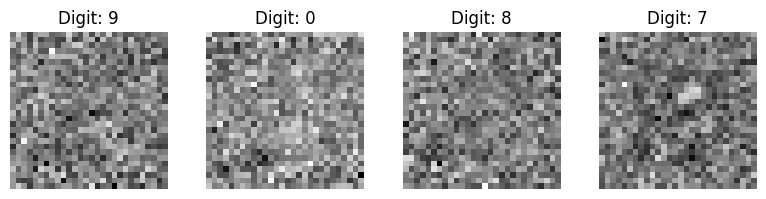

Epoch [37/100], i: 0, Loss: 0.1521
Epoch [37/100], i: 100, Loss: 0.1297
Epoch [37/100], i: 200, Loss: 0.1408
Epoch [37/100], i: 300, Loss: 0.1231
Epoch [37/100], i: 400, Loss: 0.1494
Epoch [38/100], i: 0, Loss: 0.1194
Epoch [38/100], i: 100, Loss: 0.1236
Epoch [38/100], i: 200, Loss: 0.1312
Epoch [38/100], i: 300, Loss: 0.1118
Epoch [38/100], i: 400, Loss: 0.1143
Epoch [39/100], i: 0, Loss: 0.1327
Epoch [39/100], i: 100, Loss: 0.1394
Epoch [39/100], i: 200, Loss: 0.1302
Epoch [39/100], i: 300, Loss: 0.1288
Epoch [39/100], i: 400, Loss: 0.1451
Epoch [40/100], i: 0, Loss: 0.1586
Epoch [40/100], i: 100, Loss: 0.1424
Epoch [40/100], i: 200, Loss: 0.1871
Epoch [40/100], i: 300, Loss: 0.1486
Epoch [40/100], i: 400, Loss: 0.1929
Epoch [41/100], i: 0, Loss: 0.1840
Epoch [41/100], i: 100, Loss: 0.1375
Epoch [41/100], i: 200, Loss: 0.1674
Epoch [41/100], i: 300, Loss: 0.1634
Epoch [41/100], i: 400, Loss: 0.1524


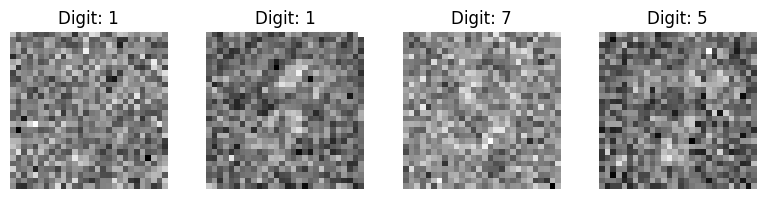

Epoch [42/100], i: 0, Loss: 0.1491
Epoch [42/100], i: 100, Loss: 0.1438
Epoch [42/100], i: 200, Loss: 0.1480
Epoch [42/100], i: 300, Loss: 0.1196
Epoch [42/100], i: 400, Loss: 0.1675
Epoch [43/100], i: 0, Loss: 0.1549
Epoch [43/100], i: 100, Loss: 0.2281
Epoch [43/100], i: 200, Loss: 0.1706
Epoch [43/100], i: 300, Loss: 0.1891
Epoch [43/100], i: 400, Loss: 0.1875
Epoch [44/100], i: 0, Loss: 0.1760
Epoch [44/100], i: 100, Loss: 0.1646
Epoch [44/100], i: 200, Loss: 0.1525
Epoch [44/100], i: 300, Loss: 0.1578
Epoch [44/100], i: 400, Loss: 0.1519
Epoch [45/100], i: 0, Loss: 0.1656
Epoch [45/100], i: 100, Loss: 0.1554
Epoch [45/100], i: 200, Loss: 0.1748
Epoch [45/100], i: 300, Loss: 0.1439
Epoch [45/100], i: 400, Loss: 0.1704
Epoch [46/100], i: 0, Loss: 0.1820
Epoch [46/100], i: 100, Loss: 0.1313
Epoch [46/100], i: 200, Loss: 0.1600
Epoch [46/100], i: 300, Loss: 0.1640
Epoch [46/100], i: 400, Loss: 0.1770


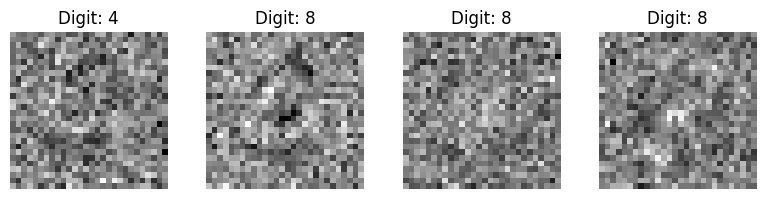

Epoch [47/100], i: 0, Loss: 0.1442
Epoch [47/100], i: 100, Loss: 0.1295
Epoch [47/100], i: 200, Loss: 0.1747
Epoch [47/100], i: 300, Loss: 0.1660
Epoch [47/100], i: 400, Loss: 0.1341
Epoch [48/100], i: 0, Loss: 0.1389
Epoch [48/100], i: 100, Loss: 0.1622
Epoch [48/100], i: 200, Loss: 0.1633
Epoch [48/100], i: 300, Loss: 0.1452
Epoch [48/100], i: 400, Loss: 0.1803
Epoch [49/100], i: 0, Loss: 0.1519
Epoch [49/100], i: 100, Loss: 0.1504
Epoch [49/100], i: 200, Loss: 0.1579
Epoch [49/100], i: 300, Loss: 0.1605
Epoch [49/100], i: 400, Loss: 0.1551
Epoch [50/100], i: 0, Loss: 0.1454
Epoch [50/100], i: 100, Loss: 0.1377
Epoch [50/100], i: 200, Loss: 0.1627
Epoch [50/100], i: 300, Loss: 0.1367
Epoch [50/100], i: 400, Loss: 0.1405
Epoch [51/100], i: 0, Loss: 0.1403
Epoch [51/100], i: 100, Loss: 0.1499
Epoch [51/100], i: 200, Loss: 0.1583
Epoch [51/100], i: 300, Loss: 0.1338
Epoch [51/100], i: 400, Loss: 0.1523


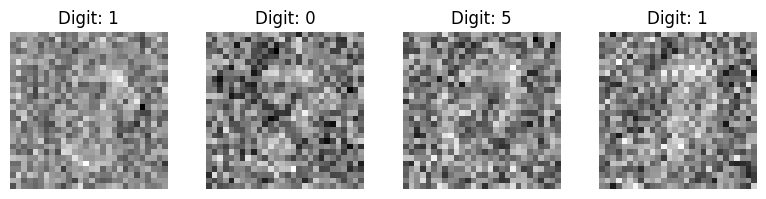

Epoch [52/100], i: 0, Loss: 0.1676
Epoch [52/100], i: 100, Loss: 0.1362
Epoch [52/100], i: 200, Loss: 0.1526
Epoch [52/100], i: 300, Loss: 0.1533
Epoch [52/100], i: 400, Loss: 0.1248
Epoch [53/100], i: 0, Loss: 0.1434
Epoch [53/100], i: 100, Loss: 0.1710
Epoch [53/100], i: 200, Loss: 0.1342
Epoch [53/100], i: 300, Loss: 0.1465
Epoch [53/100], i: 400, Loss: 0.1522
Epoch [54/100], i: 0, Loss: 0.1391
Epoch [54/100], i: 100, Loss: 0.1362
Epoch [54/100], i: 200, Loss: 0.1312
Epoch [54/100], i: 300, Loss: 0.1539
Epoch [54/100], i: 400, Loss: 0.1323
Epoch [55/100], i: 0, Loss: 0.1994
Epoch [55/100], i: 100, Loss: 0.1734
Epoch [55/100], i: 200, Loss: 0.1280
Epoch [55/100], i: 300, Loss: 0.1362
Epoch [55/100], i: 400, Loss: 0.1331
Epoch [56/100], i: 0, Loss: 0.1273
Epoch [56/100], i: 100, Loss: 0.1420
Epoch [56/100], i: 200, Loss: 0.1486
Epoch [56/100], i: 300, Loss: 0.1329
Epoch [56/100], i: 400, Loss: 0.1283


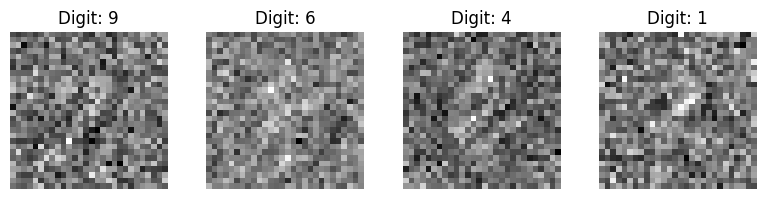

Epoch [57/100], i: 0, Loss: 0.1570
Epoch [57/100], i: 100, Loss: 0.1275
Epoch [57/100], i: 200, Loss: 0.1490
Epoch [57/100], i: 300, Loss: 0.1565
Epoch [57/100], i: 400, Loss: 0.1643
Epoch [58/100], i: 0, Loss: 0.1405
Epoch [58/100], i: 100, Loss: 0.1390
Epoch [58/100], i: 200, Loss: 0.1517
Epoch [58/100], i: 300, Loss: 0.1439
Epoch [58/100], i: 400, Loss: 0.1268
Epoch [59/100], i: 0, Loss: 0.1406
Epoch [59/100], i: 100, Loss: 0.1115
Epoch [59/100], i: 200, Loss: 0.1572
Epoch [59/100], i: 300, Loss: 0.1460
Epoch [59/100], i: 400, Loss: 0.1521
Epoch [60/100], i: 0, Loss: 0.1181
Epoch [60/100], i: 100, Loss: 0.1225
Epoch [60/100], i: 200, Loss: 0.1284
Epoch [60/100], i: 300, Loss: 0.1127
Epoch [60/100], i: 400, Loss: 0.1263
Epoch [61/100], i: 0, Loss: 0.1185
Epoch [61/100], i: 100, Loss: 0.1467
Epoch [61/100], i: 200, Loss: 0.1354
Epoch [61/100], i: 300, Loss: 0.1127
Epoch [61/100], i: 400, Loss: 0.1123


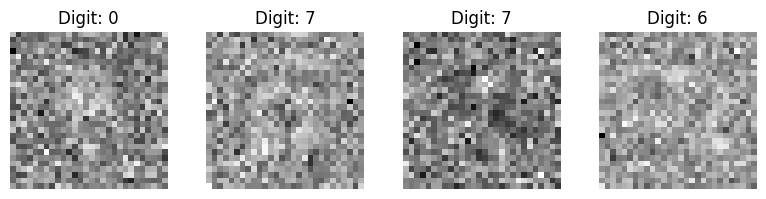

Epoch [62/100], i: 0, Loss: 0.1450
Epoch [62/100], i: 100, Loss: 0.1186
Epoch [62/100], i: 200, Loss: 0.1091
Epoch [62/100], i: 300, Loss: 0.1331
Epoch [62/100], i: 400, Loss: 0.1219
Epoch [63/100], i: 0, Loss: 0.1394
Epoch [63/100], i: 100, Loss: 0.1509
Epoch [63/100], i: 200, Loss: 0.1375
Epoch [63/100], i: 300, Loss: 0.1447
Epoch [63/100], i: 400, Loss: 0.1868
Epoch [64/100], i: 0, Loss: 0.1539
Epoch [64/100], i: 100, Loss: 0.1551
Epoch [64/100], i: 200, Loss: 0.1481
Epoch [64/100], i: 300, Loss: 0.1306
Epoch [64/100], i: 400, Loss: 0.1219
Epoch [65/100], i: 0, Loss: 0.1227
Epoch [65/100], i: 100, Loss: 0.1349
Epoch [65/100], i: 200, Loss: 0.1071
Epoch [65/100], i: 300, Loss: 0.1416
Epoch [65/100], i: 400, Loss: 0.1258
Epoch [66/100], i: 0, Loss: 0.1312
Epoch [66/100], i: 100, Loss: 0.1315
Epoch [66/100], i: 200, Loss: 0.1200
Epoch [66/100], i: 300, Loss: 0.1283
Epoch [66/100], i: 400, Loss: 0.1394


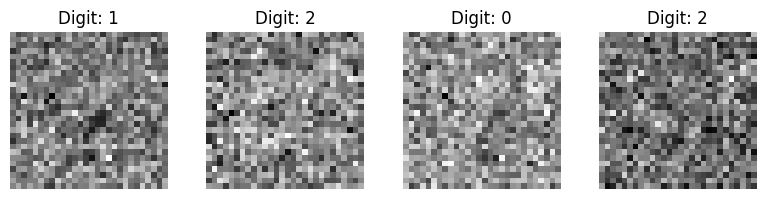

Epoch [67/100], i: 0, Loss: 0.1147
Epoch [67/100], i: 100, Loss: 0.1437
Epoch [67/100], i: 200, Loss: 0.1132
Epoch [67/100], i: 300, Loss: 0.1261
Epoch [67/100], i: 400, Loss: 0.1227
Epoch [68/100], i: 0, Loss: 0.1145
Epoch [68/100], i: 100, Loss: 0.1331
Epoch [68/100], i: 200, Loss: 0.1406
Epoch [68/100], i: 300, Loss: 0.1272
Epoch [68/100], i: 400, Loss: 0.1159
Epoch [69/100], i: 0, Loss: 0.1234
Epoch [69/100], i: 100, Loss: 0.1406
Epoch [69/100], i: 200, Loss: 0.1284
Epoch [69/100], i: 300, Loss: 0.1015
Epoch [69/100], i: 400, Loss: 0.1453
Epoch [70/100], i: 0, Loss: 0.1394
Epoch [70/100], i: 100, Loss: 0.1468
Epoch [70/100], i: 200, Loss: 0.1199
Epoch [70/100], i: 300, Loss: 0.1200
Epoch [70/100], i: 400, Loss: 0.1465
Epoch [71/100], i: 0, Loss: 0.1422
Epoch [71/100], i: 100, Loss: 0.1444
Epoch [71/100], i: 200, Loss: 0.1441
Epoch [71/100], i: 300, Loss: 0.1507
Epoch [71/100], i: 400, Loss: 0.1355


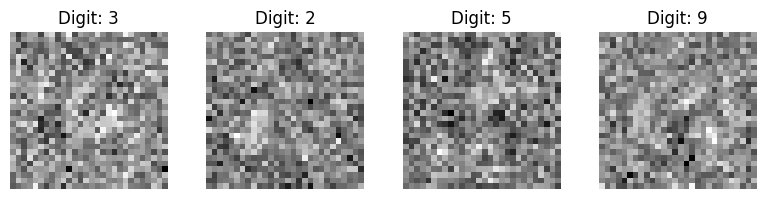

Epoch [72/100], i: 0, Loss: 0.1231
Epoch [72/100], i: 100, Loss: 0.1638
Epoch [72/100], i: 200, Loss: 0.1234
Epoch [72/100], i: 300, Loss: 0.1404
Epoch [72/100], i: 400, Loss: 0.1531
Epoch [73/100], i: 0, Loss: 0.1366
Epoch [73/100], i: 100, Loss: 0.1523
Epoch [73/100], i: 200, Loss: 0.1327
Epoch [73/100], i: 300, Loss: 0.1423
Epoch [73/100], i: 400, Loss: 0.1331
Epoch [74/100], i: 0, Loss: 0.1341
Epoch [74/100], i: 100, Loss: 0.1380
Epoch [74/100], i: 200, Loss: 0.1477
Epoch [74/100], i: 300, Loss: 0.1063
Epoch [74/100], i: 400, Loss: 0.1290
Epoch [75/100], i: 0, Loss: 0.1143
Epoch [75/100], i: 100, Loss: 0.1364
Epoch [75/100], i: 200, Loss: 0.1327
Epoch [75/100], i: 300, Loss: 0.1211
Epoch [75/100], i: 400, Loss: 0.1234
Epoch [76/100], i: 0, Loss: 0.1501
Epoch [76/100], i: 100, Loss: 0.1321
Epoch [76/100], i: 200, Loss: 0.1225
Epoch [76/100], i: 300, Loss: 0.1871
Epoch [76/100], i: 400, Loss: 0.1668


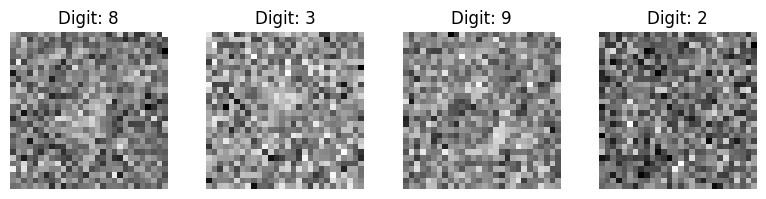

Epoch [77/100], i: 0, Loss: 0.1355
Epoch [77/100], i: 100, Loss: 0.1510
Epoch [77/100], i: 200, Loss: 0.1366
Epoch [77/100], i: 300, Loss: 0.1584
Epoch [77/100], i: 400, Loss: 0.1356
Epoch [78/100], i: 0, Loss: 0.1554
Epoch [78/100], i: 100, Loss: 0.1561
Epoch [78/100], i: 200, Loss: 0.1349
Epoch [78/100], i: 300, Loss: 0.1428
Epoch [78/100], i: 400, Loss: 0.1788
Epoch [79/100], i: 0, Loss: 0.1330
Epoch [79/100], i: 100, Loss: 0.1370
Epoch [79/100], i: 200, Loss: 0.1454
Epoch [79/100], i: 300, Loss: 0.1460
Epoch [79/100], i: 400, Loss: 0.1276
Epoch [80/100], i: 0, Loss: 0.1299
Epoch [80/100], i: 100, Loss: 0.1398
Epoch [80/100], i: 200, Loss: 0.1144
Epoch [80/100], i: 300, Loss: 0.1244
Epoch [80/100], i: 400, Loss: 0.1372
Epoch [81/100], i: 0, Loss: 0.1300
Epoch [81/100], i: 100, Loss: 0.1446
Epoch [81/100], i: 200, Loss: 0.1297
Epoch [81/100], i: 300, Loss: 0.1346
Epoch [81/100], i: 400, Loss: 0.1368


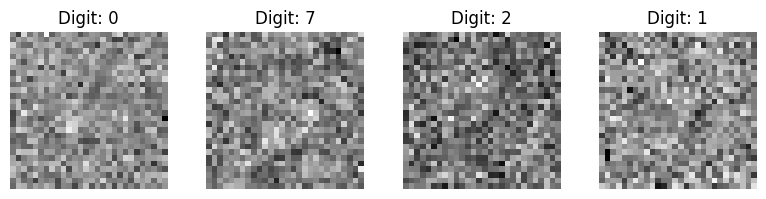

Epoch [82/100], i: 0, Loss: 0.1462
Epoch [82/100], i: 100, Loss: 0.1120
Epoch [82/100], i: 200, Loss: 0.1143
Epoch [82/100], i: 300, Loss: 0.1122
Epoch [82/100], i: 400, Loss: 0.1406
Epoch [83/100], i: 0, Loss: 0.1416
Epoch [83/100], i: 100, Loss: 0.1146
Epoch [83/100], i: 200, Loss: 0.1229
Epoch [83/100], i: 300, Loss: 0.1346
Epoch [83/100], i: 400, Loss: 0.1419
Epoch [84/100], i: 0, Loss: 0.1230
Epoch [84/100], i: 100, Loss: 0.1373
Epoch [84/100], i: 200, Loss: 0.1308
Epoch [84/100], i: 300, Loss: 0.1211
Epoch [84/100], i: 400, Loss: 0.1270
Epoch [85/100], i: 0, Loss: 0.1165
Epoch [85/100], i: 100, Loss: 0.1095
Epoch [85/100], i: 200, Loss: 0.1221
Epoch [85/100], i: 300, Loss: 0.1179
Epoch [85/100], i: 400, Loss: 0.1219
Epoch [86/100], i: 0, Loss: 0.1104
Epoch [86/100], i: 100, Loss: 0.1178
Epoch [86/100], i: 200, Loss: 0.1279
Epoch [86/100], i: 300, Loss: 0.1051
Epoch [86/100], i: 400, Loss: 0.1181


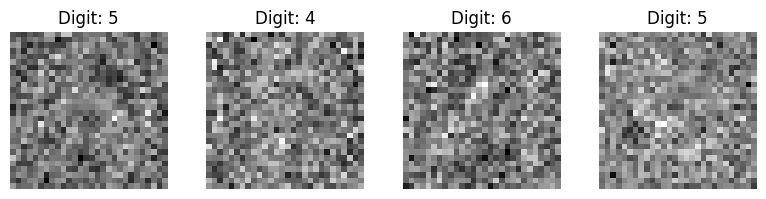

Epoch [87/100], i: 0, Loss: 0.1309
Epoch [87/100], i: 100, Loss: 0.1240
Epoch [87/100], i: 200, Loss: 0.1226
Epoch [87/100], i: 300, Loss: 0.1110
Epoch [87/100], i: 400, Loss: 0.1103
Epoch [88/100], i: 0, Loss: 0.1109
Epoch [88/100], i: 100, Loss: 0.1256
Epoch [88/100], i: 200, Loss: 0.1189
Epoch [88/100], i: 300, Loss: 0.1110
Epoch [88/100], i: 400, Loss: 0.1298
Epoch [89/100], i: 0, Loss: 0.1118
Epoch [89/100], i: 100, Loss: 0.1286
Epoch [89/100], i: 200, Loss: 0.1483
Epoch [89/100], i: 300, Loss: 0.1267
Epoch [89/100], i: 400, Loss: 0.1172
Epoch [90/100], i: 0, Loss: 0.1306
Epoch [90/100], i: 100, Loss: 0.1147
Epoch [90/100], i: 200, Loss: 0.1260
Epoch [90/100], i: 300, Loss: 0.1525
Epoch [90/100], i: 400, Loss: 0.1058
Epoch [91/100], i: 0, Loss: 0.1303
Epoch [91/100], i: 100, Loss: 0.1267
Epoch [91/100], i: 200, Loss: 0.1475
Epoch [91/100], i: 300, Loss: 0.1203
Epoch [91/100], i: 400, Loss: 0.1049


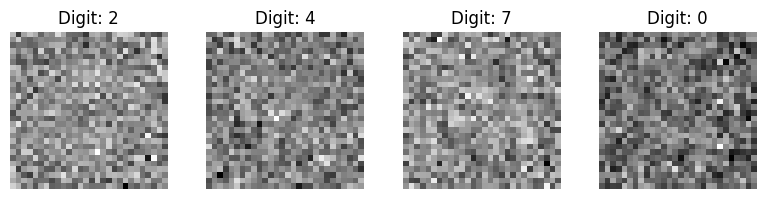

Epoch [92/100], i: 0, Loss: 0.1121
Epoch [92/100], i: 100, Loss: 0.1194
Epoch [92/100], i: 200, Loss: 0.1268
Epoch [92/100], i: 300, Loss: 0.1084
Epoch [92/100], i: 400, Loss: 0.1070
Epoch [93/100], i: 0, Loss: 0.1094
Epoch [93/100], i: 100, Loss: 0.1162
Epoch [93/100], i: 200, Loss: 0.1083
Epoch [93/100], i: 300, Loss: 0.1226
Epoch [93/100], i: 400, Loss: 0.1217
Epoch [94/100], i: 0, Loss: 0.1140
Epoch [94/100], i: 100, Loss: 0.1143
Epoch [94/100], i: 200, Loss: 0.1072
Epoch [94/100], i: 300, Loss: 0.1057
Epoch [94/100], i: 400, Loss: 0.1244
Epoch [95/100], i: 0, Loss: 0.1310
Epoch [95/100], i: 100, Loss: 0.1013
Epoch [95/100], i: 200, Loss: 0.1162
Epoch [95/100], i: 300, Loss: 0.1234
Epoch [95/100], i: 400, Loss: 0.1100
Epoch [96/100], i: 0, Loss: 0.1162
Epoch [96/100], i: 100, Loss: 0.1063
Epoch [96/100], i: 200, Loss: 0.1052
Epoch [96/100], i: 300, Loss: 0.1150
Epoch [96/100], i: 400, Loss: 0.1239


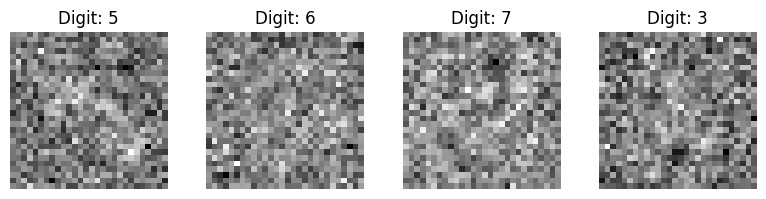

Epoch [97/100], i: 0, Loss: 0.1203
Epoch [97/100], i: 100, Loss: 0.1116
Epoch [97/100], i: 200, Loss: 0.1140
Epoch [97/100], i: 300, Loss: 0.1180
Epoch [97/100], i: 400, Loss: 0.1138
Epoch [98/100], i: 0, Loss: 0.0967
Epoch [98/100], i: 100, Loss: 0.1496
Epoch [98/100], i: 200, Loss: 0.1080
Epoch [98/100], i: 300, Loss: 0.1281
Epoch [98/100], i: 400, Loss: 0.1126
Epoch [99/100], i: 0, Loss: 0.1167
Epoch [99/100], i: 100, Loss: 0.1099
Epoch [99/100], i: 200, Loss: 0.1280
Epoch [99/100], i: 300, Loss: 0.1046
Epoch [99/100], i: 400, Loss: 0.1083
Epoch [100/100], i: 0, Loss: 0.1027
Epoch [100/100], i: 100, Loss: 0.1089
Epoch [100/100], i: 200, Loss: 0.1233
Epoch [100/100], i: 300, Loss: 0.1162
Epoch [100/100], i: 400, Loss: 0.1124


In [132]:
train()

### Generated images are not good

It probably is happening due to batch norm (as I'm training on batch size of 128 but generating on a batch of 4)
- add layernorm
- add regularizer
- 999 steps again (not 10)

In [133]:
class DiffusionModel(nn.Module):
    def __init__(self, img_size, timesteps, num_classes):
        super().__init__()
        self.img_size = img_size
        self.timesteps = timesteps
        self.num_classes = num_classes
        
        self.encoder = nn.Sequential(
            nn.Linear(img_size * img_size + 1 + num_classes, 1024),
            nn.LayerNorm(1024),
            nn.ReLU()
        )
        
        self.residual_blocks = nn.ModuleList([
            nn.Sequential(
                nn.Linear(1024, 1024),
                nn.LayerNorm(1024),
                nn.ReLU(),
                nn.Linear(1024, 1024),
                nn.LayerNorm(1024),
                nn.ReLU()
            ) for _ in range(10)  # Number of residual blocks (changed to 10)
        ])
        
        self.decoder = nn.Sequential(
            nn.Linear(1024, img_size * img_size)
        )

    def forward(self, x, t, y):
        x_orig = x.view(-1, self.img_size * self.img_size)  # for residual connection
        t = t.unsqueeze(1)
        y = nn.functional.one_hot(y, num_classes=self.num_classes).float()
        
        x = torch.cat([x_orig, t, y], dim=1)
        x = self.encoder(x)
        
        for block in self.residual_blocks:
            residual = x
            x = block(x)
            x = x + residual  # Skip connection within residual blocks
        
        x = self.decoder(x)
        x = x + x_orig  # Residual connection from pixel values
        
        return x.view(-1, 1, self.img_size, self.img_size)

In [134]:
import random
#removed batch norm
def sample_image_multiple(num_samples=1):
    with torch.no_grad():
        x = torch.randn(num_samples, 1, 28, 28).to(device)
        y = torch.randint(0, 10, (num_samples,)).to(device)  # Generate random target labels
        
        for t in range(999, -1, -1):
            z = torch.randn(num_samples, 1, 28, 28).to(device) if t > 0 else torch.zeros(num_samples, 1, 28, 28).to(device)
            t_tensor = torch.tensor([t]).expand(num_samples).to(device)
            
            predicted_noise = model(x, t_tensor, y)
            x = x - predicted_noise

    generated_samples = x.cpu().squeeze().numpy()
    
    import matplotlib.pyplot as plt
    fig, axs = plt.subplots(1, num_samples, figsize=(num_samples * 2, 2))
    
    for i in range(num_samples):
        if num_samples == 1:
            axs.imshow(generated_samples[i], cmap="gray")
            axs.set_title(f"Digit: {y[i].item()}")
            axs.axis("off")
        else:
            axs[i].imshow(generated_samples[i], cmap="gray")
            axs[i].set_title(f"Digit: {y[i].item()}")
            axs[i].axis("off")
    
    plt.tight_layout()
    plt.show()

In [135]:
def train():
    for epoch in range(100):
        i=0
        for data, labels in trainloader:
            
            ## data here is 128 batch size of each image and labels is 128 batch size of each label
            data, labels = data.to(device), labels.to(device)
            
            optimizer.zero_grad()
    
            # t here is random integer with values between 0 and 999, representing timesteps for each example in the batch
            t = torch.randint(0, 1000, (data.shape[0],), device=device)
           
    
            # generates random noise (mean 0, sd 1) tensor with the same shape as input data
            noise = torch.randn_like(data)
    
            # adds noise to input data based on timesteps. Scales noise by  a factor calculated using the timesteps
            # In diffusion models, the noise is gradually added to the data over the course of the diffusion process. The amount of noise added at each timestep is typically proportional to the square root of the timestep value. This is derived from the continuous-time formulation of the diffusion process.
            noisy_data = data + noise * torch.sqrt(t.view(-1,1,1,1)/999)
            
            predicted_noise = model(noisy_data, t, labels)
            loss = criterion(predicted_noise, noise)
            loss.backward()
            optimizer.step()
            if((i%100)==0):
                print(f"Epoch [{epoch+1}/100], i: {i}, Loss: {loss.item():.4f}")
            
            i+=1
    
        if(epoch%5==0):
            sample_image_multiple(num_samples=4)
    

In [138]:
transform = transforms.Compose([transforms.ToTensor()])
trainset = datasets.MNIST('data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)
model = DiffusionModel(img_size=28, timesteps=1000, num_classes=10).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
criterion = nn.MSELoss()

Epoch [1/100], i: 0, Loss: 8.1348
Epoch [1/100], i: 100, Loss: 0.2480
Epoch [1/100], i: 200, Loss: 0.1999
Epoch [1/100], i: 300, Loss: 0.1965
Epoch [1/100], i: 400, Loss: 0.1644


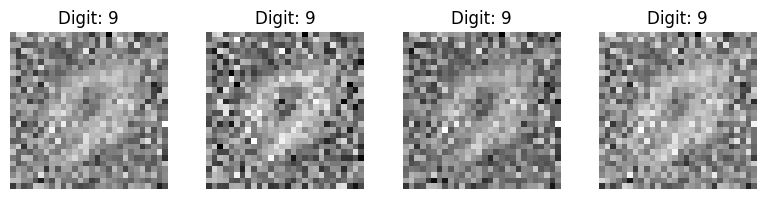

Epoch [2/100], i: 0, Loss: 0.1562
Epoch [2/100], i: 100, Loss: 0.1469
Epoch [2/100], i: 200, Loss: 0.1645
Epoch [2/100], i: 300, Loss: 0.1630
Epoch [2/100], i: 400, Loss: 0.1480
Epoch [3/100], i: 0, Loss: 0.1274
Epoch [3/100], i: 100, Loss: 0.1472
Epoch [3/100], i: 200, Loss: 0.1387
Epoch [3/100], i: 300, Loss: 0.1331
Epoch [3/100], i: 400, Loss: 0.1579
Epoch [4/100], i: 0, Loss: 0.1360
Epoch [4/100], i: 100, Loss: 0.1176
Epoch [4/100], i: 200, Loss: 0.1285
Epoch [4/100], i: 300, Loss: 0.1310
Epoch [4/100], i: 400, Loss: 0.1449
Epoch [5/100], i: 0, Loss: 0.1257
Epoch [5/100], i: 100, Loss: 0.1037
Epoch [5/100], i: 200, Loss: 0.0990
Epoch [5/100], i: 300, Loss: 0.1072
Epoch [5/100], i: 400, Loss: 0.1240
Epoch [6/100], i: 0, Loss: 0.1070
Epoch [6/100], i: 100, Loss: 0.1270
Epoch [6/100], i: 200, Loss: 0.1367
Epoch [6/100], i: 300, Loss: 0.1156
Epoch [6/100], i: 400, Loss: 0.1136


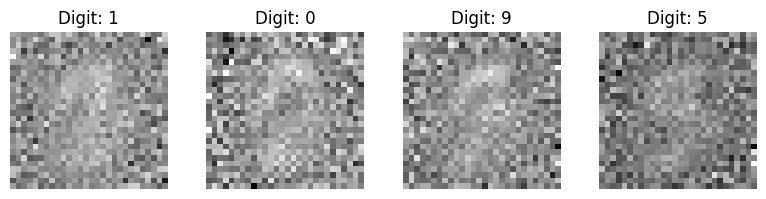

Epoch [7/100], i: 0, Loss: 0.1045
Epoch [7/100], i: 100, Loss: 0.1249
Epoch [7/100], i: 200, Loss: 0.1185
Epoch [7/100], i: 300, Loss: 0.1162
Epoch [7/100], i: 400, Loss: 0.1028
Epoch [8/100], i: 0, Loss: 0.1024
Epoch [8/100], i: 100, Loss: 0.1017
Epoch [8/100], i: 200, Loss: 0.0989
Epoch [8/100], i: 300, Loss: 0.0983
Epoch [8/100], i: 400, Loss: 0.0950
Epoch [9/100], i: 0, Loss: 0.1066
Epoch [9/100], i: 100, Loss: 0.0914
Epoch [9/100], i: 200, Loss: 0.0949
Epoch [9/100], i: 300, Loss: 0.1141
Epoch [9/100], i: 400, Loss: 0.0896
Epoch [10/100], i: 0, Loss: 0.1027
Epoch [10/100], i: 100, Loss: 0.0952
Epoch [10/100], i: 200, Loss: 0.0928
Epoch [10/100], i: 300, Loss: 0.0982
Epoch [10/100], i: 400, Loss: 0.1006
Epoch [11/100], i: 0, Loss: 0.1034
Epoch [11/100], i: 100, Loss: 0.0930
Epoch [11/100], i: 200, Loss: 0.0894
Epoch [11/100], i: 300, Loss: 0.1025
Epoch [11/100], i: 400, Loss: 0.1148


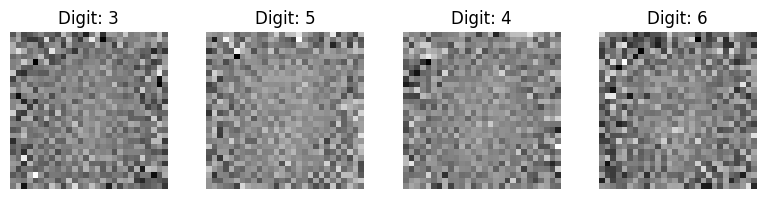

Epoch [12/100], i: 0, Loss: 0.1002
Epoch [12/100], i: 100, Loss: 0.0879
Epoch [12/100], i: 200, Loss: 0.1005
Epoch [12/100], i: 300, Loss: 0.0957
Epoch [12/100], i: 400, Loss: 0.0993
Epoch [13/100], i: 0, Loss: 0.0980
Epoch [13/100], i: 100, Loss: 0.1032
Epoch [13/100], i: 200, Loss: 0.0920
Epoch [13/100], i: 300, Loss: 0.0849
Epoch [13/100], i: 400, Loss: 0.0894
Epoch [14/100], i: 0, Loss: 0.0916
Epoch [14/100], i: 100, Loss: 0.1022
Epoch [14/100], i: 200, Loss: 0.0923
Epoch [14/100], i: 300, Loss: 0.0965
Epoch [14/100], i: 400, Loss: 0.1004
Epoch [15/100], i: 0, Loss: 0.0974
Epoch [15/100], i: 100, Loss: 0.0941
Epoch [15/100], i: 200, Loss: 0.0968
Epoch [15/100], i: 300, Loss: 0.0880
Epoch [15/100], i: 400, Loss: 0.0979
Epoch [16/100], i: 0, Loss: 0.1002
Epoch [16/100], i: 100, Loss: 0.0949
Epoch [16/100], i: 200, Loss: 0.0778
Epoch [16/100], i: 300, Loss: 0.0807
Epoch [16/100], i: 400, Loss: 0.0946


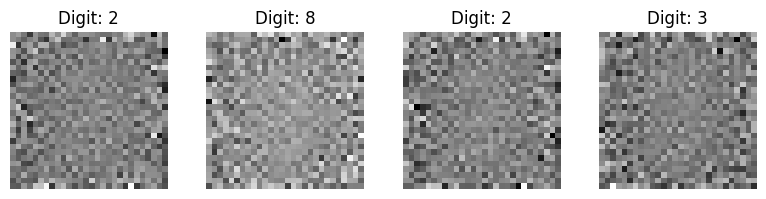

Epoch [17/100], i: 0, Loss: 0.0983
Epoch [17/100], i: 100, Loss: 0.0962
Epoch [17/100], i: 200, Loss: 0.0910
Epoch [17/100], i: 300, Loss: 0.0963
Epoch [17/100], i: 400, Loss: 0.0969
Epoch [18/100], i: 0, Loss: 0.0872
Epoch [18/100], i: 100, Loss: 0.1026
Epoch [18/100], i: 200, Loss: 0.0970
Epoch [18/100], i: 300, Loss: 0.0901
Epoch [18/100], i: 400, Loss: 0.0948
Epoch [19/100], i: 0, Loss: 0.1044
Epoch [19/100], i: 100, Loss: 0.0907
Epoch [19/100], i: 200, Loss: 0.0929
Epoch [19/100], i: 300, Loss: 0.0874
Epoch [19/100], i: 400, Loss: 0.0816
Epoch [20/100], i: 0, Loss: 0.0768
Epoch [20/100], i: 100, Loss: 0.0888
Epoch [20/100], i: 200, Loss: 0.0900
Epoch [20/100], i: 300, Loss: 0.0843
Epoch [20/100], i: 400, Loss: 0.0914
Epoch [21/100], i: 0, Loss: 0.0825
Epoch [21/100], i: 100, Loss: 0.0963
Epoch [21/100], i: 200, Loss: 0.0985
Epoch [21/100], i: 300, Loss: 0.0845
Epoch [21/100], i: 400, Loss: 0.0943


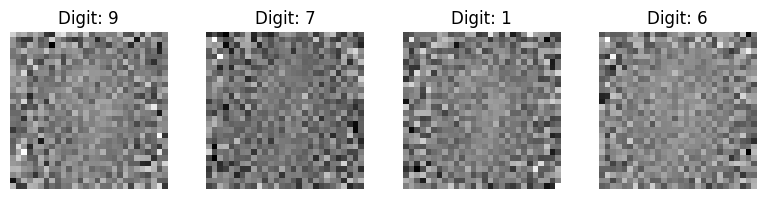

Epoch [22/100], i: 0, Loss: 0.0963
Epoch [22/100], i: 100, Loss: 0.0989
Epoch [22/100], i: 200, Loss: 0.0794
Epoch [22/100], i: 300, Loss: 0.0927
Epoch [22/100], i: 400, Loss: 0.0957
Epoch [23/100], i: 0, Loss: 0.0906
Epoch [23/100], i: 100, Loss: 0.0920
Epoch [23/100], i: 200, Loss: 0.1010
Epoch [23/100], i: 300, Loss: 0.0827
Epoch [23/100], i: 400, Loss: 0.0860
Epoch [24/100], i: 0, Loss: 0.0883
Epoch [24/100], i: 100, Loss: 0.0875
Epoch [24/100], i: 200, Loss: 0.0701
Epoch [24/100], i: 300, Loss: 0.0858
Epoch [24/100], i: 400, Loss: 0.0910
Epoch [25/100], i: 0, Loss: 0.0855
Epoch [25/100], i: 100, Loss: 0.0921
Epoch [25/100], i: 200, Loss: 0.0799
Epoch [25/100], i: 300, Loss: 0.0985
Epoch [25/100], i: 400, Loss: 0.0926
Epoch [26/100], i: 0, Loss: 0.0736
Epoch [26/100], i: 100, Loss: 0.0945
Epoch [26/100], i: 200, Loss: 0.0884
Epoch [26/100], i: 300, Loss: 0.0844
Epoch [26/100], i: 400, Loss: 0.0825


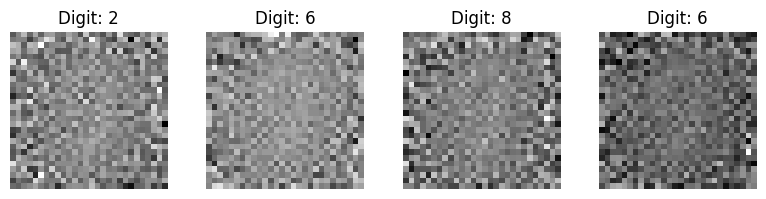

Epoch [27/100], i: 0, Loss: 0.0891
Epoch [27/100], i: 100, Loss: 0.0866
Epoch [27/100], i: 200, Loss: 0.0836
Epoch [27/100], i: 300, Loss: 0.0912
Epoch [27/100], i: 400, Loss: 0.0891
Epoch [28/100], i: 0, Loss: 0.0926
Epoch [28/100], i: 100, Loss: 0.1010
Epoch [28/100], i: 200, Loss: 0.0864
Epoch [28/100], i: 300, Loss: 0.0926
Epoch [28/100], i: 400, Loss: 0.0765
Epoch [29/100], i: 0, Loss: 0.1040
Epoch [29/100], i: 100, Loss: 0.0827
Epoch [29/100], i: 200, Loss: 0.0799
Epoch [29/100], i: 300, Loss: 0.0929
Epoch [29/100], i: 400, Loss: 0.0884
Epoch [30/100], i: 0, Loss: 0.1109
Epoch [30/100], i: 100, Loss: 0.0906
Epoch [30/100], i: 200, Loss: 0.0851
Epoch [30/100], i: 300, Loss: 0.0907
Epoch [30/100], i: 400, Loss: 0.0798
Epoch [31/100], i: 0, Loss: 0.0869
Epoch [31/100], i: 100, Loss: 0.0824
Epoch [31/100], i: 200, Loss: 0.0760
Epoch [31/100], i: 300, Loss: 0.1087
Epoch [31/100], i: 400, Loss: 0.0828


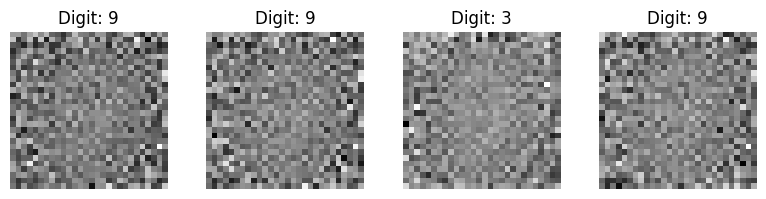

Epoch [32/100], i: 0, Loss: 0.0885
Epoch [32/100], i: 100, Loss: 0.0877
Epoch [32/100], i: 200, Loss: 0.0840
Epoch [32/100], i: 300, Loss: 0.0737
Epoch [32/100], i: 400, Loss: 0.0905
Epoch [33/100], i: 0, Loss: 0.0895
Epoch [33/100], i: 100, Loss: 0.0858
Epoch [33/100], i: 200, Loss: 0.0872
Epoch [33/100], i: 300, Loss: 0.1033
Epoch [33/100], i: 400, Loss: 0.0965
Epoch [34/100], i: 0, Loss: 0.0915
Epoch [34/100], i: 100, Loss: 0.0758
Epoch [34/100], i: 200, Loss: 0.0820
Epoch [34/100], i: 300, Loss: 0.0894
Epoch [34/100], i: 400, Loss: 0.0855
Epoch [35/100], i: 0, Loss: 0.0943
Epoch [35/100], i: 100, Loss: 0.0895
Epoch [35/100], i: 200, Loss: 0.0789
Epoch [35/100], i: 300, Loss: 0.0859
Epoch [35/100], i: 400, Loss: 0.0936
Epoch [36/100], i: 0, Loss: 0.0902
Epoch [36/100], i: 100, Loss: 0.0842
Epoch [36/100], i: 200, Loss: 0.0771
Epoch [36/100], i: 300, Loss: 0.1098
Epoch [36/100], i: 400, Loss: 0.0869


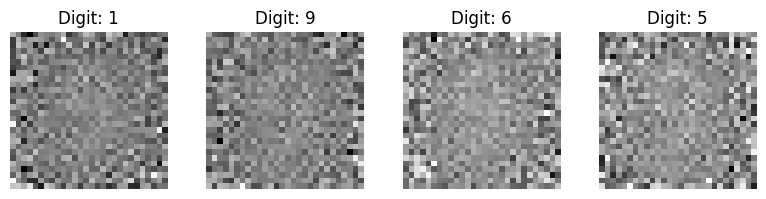

Epoch [37/100], i: 0, Loss: 0.0819
Epoch [37/100], i: 100, Loss: 0.0758
Epoch [37/100], i: 200, Loss: 0.0895
Epoch [37/100], i: 300, Loss: 0.1031
Epoch [37/100], i: 400, Loss: 0.0770
Epoch [38/100], i: 0, Loss: 0.0937
Epoch [38/100], i: 100, Loss: 0.0766
Epoch [38/100], i: 200, Loss: 0.0867
Epoch [38/100], i: 300, Loss: 0.0880
Epoch [38/100], i: 400, Loss: 0.0938
Epoch [39/100], i: 0, Loss: 0.0855
Epoch [39/100], i: 100, Loss: 0.0894
Epoch [39/100], i: 200, Loss: 0.0809
Epoch [39/100], i: 300, Loss: 0.0852
Epoch [39/100], i: 400, Loss: 0.0880
Epoch [40/100], i: 0, Loss: 0.0949
Epoch [40/100], i: 100, Loss: 0.0866
Epoch [40/100], i: 200, Loss: 0.0902
Epoch [40/100], i: 300, Loss: 0.0775
Epoch [40/100], i: 400, Loss: 0.0981
Epoch [41/100], i: 0, Loss: 0.0816
Epoch [41/100], i: 100, Loss: 0.0980
Epoch [41/100], i: 200, Loss: 0.0821
Epoch [41/100], i: 300, Loss: 0.0893
Epoch [41/100], i: 400, Loss: 0.0811


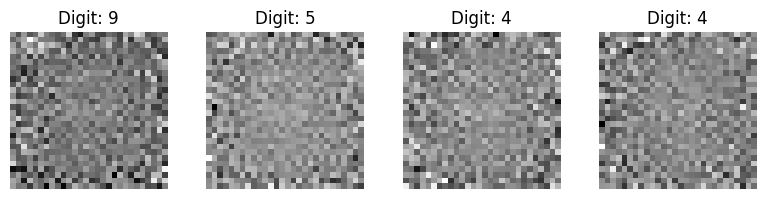

Epoch [42/100], i: 0, Loss: 0.0864
Epoch [42/100], i: 100, Loss: 0.0871
Epoch [42/100], i: 200, Loss: 0.0784
Epoch [42/100], i: 300, Loss: 0.0826
Epoch [42/100], i: 400, Loss: 0.0945
Epoch [43/100], i: 0, Loss: 0.0768
Epoch [43/100], i: 100, Loss: 0.0795
Epoch [43/100], i: 200, Loss: 0.0823
Epoch [43/100], i: 300, Loss: 0.0851
Epoch [43/100], i: 400, Loss: 0.0947
Epoch [44/100], i: 0, Loss: 0.0807
Epoch [44/100], i: 100, Loss: 0.0965
Epoch [44/100], i: 200, Loss: 0.0991
Epoch [44/100], i: 300, Loss: 0.0757
Epoch [44/100], i: 400, Loss: 0.0875
Epoch [45/100], i: 0, Loss: 0.1018
Epoch [45/100], i: 100, Loss: 0.0910
Epoch [45/100], i: 200, Loss: 0.0886
Epoch [45/100], i: 300, Loss: 0.0893
Epoch [45/100], i: 400, Loss: 0.0760
Epoch [46/100], i: 0, Loss: 0.0765
Epoch [46/100], i: 100, Loss: 0.0997
Epoch [46/100], i: 200, Loss: 0.0869
Epoch [46/100], i: 300, Loss: 0.0862
Epoch [46/100], i: 400, Loss: 0.0896


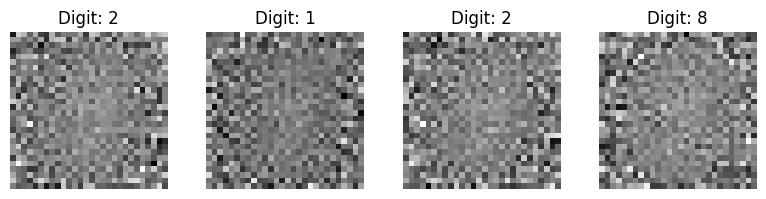

Epoch [47/100], i: 0, Loss: 0.0954
Epoch [47/100], i: 100, Loss: 0.0754
Epoch [47/100], i: 200, Loss: 0.0893
Epoch [47/100], i: 300, Loss: 0.0777
Epoch [47/100], i: 400, Loss: 0.0855
Epoch [48/100], i: 0, Loss: 0.0810
Epoch [48/100], i: 100, Loss: 0.0749
Epoch [48/100], i: 200, Loss: 0.0907
Epoch [48/100], i: 300, Loss: 0.0771
Epoch [48/100], i: 400, Loss: 0.0831
Epoch [49/100], i: 0, Loss: 0.0802
Epoch [49/100], i: 100, Loss: 0.0734
Epoch [49/100], i: 200, Loss: 0.0949
Epoch [49/100], i: 300, Loss: 0.0933
Epoch [49/100], i: 400, Loss: 0.0941
Epoch [50/100], i: 0, Loss: 0.0997
Epoch [50/100], i: 100, Loss: 0.0945
Epoch [50/100], i: 200, Loss: 0.0806
Epoch [50/100], i: 300, Loss: 0.0732
Epoch [50/100], i: 400, Loss: 0.0764
Epoch [51/100], i: 0, Loss: 0.0858
Epoch [51/100], i: 100, Loss: 0.0746
Epoch [51/100], i: 200, Loss: 0.0752
Epoch [51/100], i: 300, Loss: 0.0748
Epoch [51/100], i: 400, Loss: 0.0830


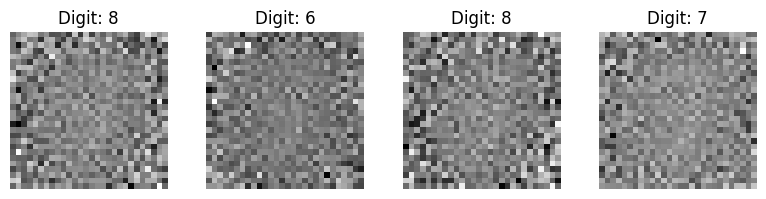

Epoch [52/100], i: 0, Loss: 0.0899
Epoch [52/100], i: 100, Loss: 0.0836
Epoch [52/100], i: 200, Loss: 0.1122
Epoch [52/100], i: 300, Loss: 0.1031
Epoch [52/100], i: 400, Loss: 0.0896
Epoch [53/100], i: 0, Loss: 0.0729
Epoch [53/100], i: 100, Loss: 0.0810
Epoch [53/100], i: 200, Loss: 0.0791
Epoch [53/100], i: 300, Loss: 0.0858
Epoch [53/100], i: 400, Loss: 0.0768
Epoch [54/100], i: 0, Loss: 0.0784
Epoch [54/100], i: 100, Loss: 0.0915
Epoch [54/100], i: 200, Loss: 0.0833
Epoch [54/100], i: 300, Loss: 0.0769
Epoch [54/100], i: 400, Loss: 0.0835
Epoch [55/100], i: 0, Loss: 0.0916
Epoch [55/100], i: 100, Loss: 0.0880
Epoch [55/100], i: 200, Loss: 0.0773
Epoch [55/100], i: 300, Loss: 0.0829
Epoch [55/100], i: 400, Loss: 0.1069
Epoch [56/100], i: 0, Loss: 0.0956
Epoch [56/100], i: 100, Loss: 0.0911
Epoch [56/100], i: 200, Loss: 0.0826
Epoch [56/100], i: 300, Loss: 0.0920
Epoch [56/100], i: 400, Loss: 0.0914


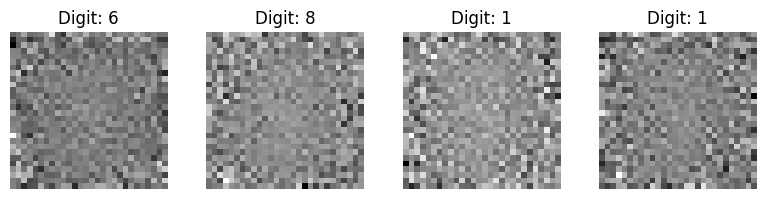

Epoch [57/100], i: 0, Loss: 0.0880
Epoch [57/100], i: 100, Loss: 0.0816
Epoch [57/100], i: 200, Loss: 0.0780
Epoch [57/100], i: 300, Loss: 0.0825
Epoch [57/100], i: 400, Loss: 0.0793
Epoch [58/100], i: 0, Loss: 0.0813
Epoch [58/100], i: 100, Loss: 0.0981
Epoch [58/100], i: 200, Loss: 0.0795
Epoch [58/100], i: 300, Loss: 0.0857
Epoch [58/100], i: 400, Loss: 0.0921
Epoch [59/100], i: 0, Loss: 0.0714
Epoch [59/100], i: 100, Loss: 0.0871
Epoch [59/100], i: 200, Loss: 0.0820
Epoch [59/100], i: 300, Loss: 0.0789
Epoch [59/100], i: 400, Loss: 0.1032
Epoch [60/100], i: 0, Loss: 0.0706
Epoch [60/100], i: 100, Loss: 0.0858
Epoch [60/100], i: 200, Loss: 0.0783
Epoch [60/100], i: 300, Loss: 0.0906
Epoch [60/100], i: 400, Loss: 0.0714
Epoch [61/100], i: 0, Loss: 0.0843
Epoch [61/100], i: 100, Loss: 0.0811
Epoch [61/100], i: 200, Loss: 0.0864
Epoch [61/100], i: 300, Loss: 0.0859
Epoch [61/100], i: 400, Loss: 0.0859


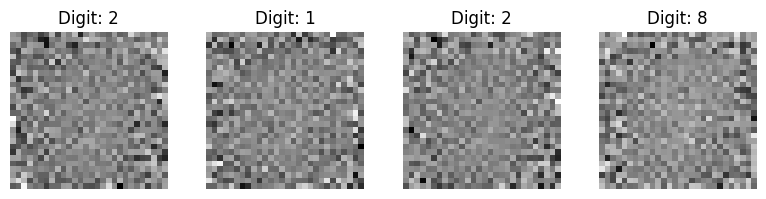

Epoch [62/100], i: 0, Loss: 0.0944
Epoch [62/100], i: 100, Loss: 0.0687
Epoch [62/100], i: 200, Loss: 0.0877
Epoch [62/100], i: 300, Loss: 0.0810
Epoch [62/100], i: 400, Loss: 0.0894
Epoch [63/100], i: 0, Loss: 0.0841
Epoch [63/100], i: 100, Loss: 0.0915
Epoch [63/100], i: 200, Loss: 0.0926
Epoch [63/100], i: 300, Loss: 0.0746
Epoch [63/100], i: 400, Loss: 0.0951
Epoch [64/100], i: 0, Loss: 0.0923
Epoch [64/100], i: 100, Loss: 0.0909
Epoch [64/100], i: 200, Loss: 0.0818
Epoch [64/100], i: 300, Loss: 0.0766
Epoch [64/100], i: 400, Loss: 0.0828
Epoch [65/100], i: 0, Loss: 0.0934
Epoch [65/100], i: 100, Loss: 0.0777
Epoch [65/100], i: 200, Loss: 0.0902
Epoch [65/100], i: 300, Loss: 0.0826
Epoch [65/100], i: 400, Loss: 0.0853
Epoch [66/100], i: 0, Loss: 0.0762
Epoch [66/100], i: 100, Loss: 0.0856
Epoch [66/100], i: 200, Loss: 0.0822
Epoch [66/100], i: 300, Loss: 0.0820
Epoch [66/100], i: 400, Loss: 0.0881


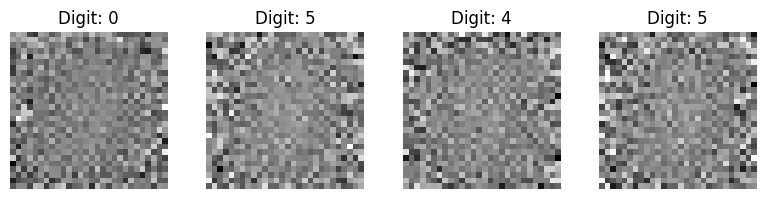

Epoch [67/100], i: 0, Loss: 0.0713
Epoch [67/100], i: 100, Loss: 0.0915
Epoch [67/100], i: 200, Loss: 0.0790
Epoch [67/100], i: 300, Loss: 0.0864
Epoch [67/100], i: 400, Loss: 0.0856
Epoch [68/100], i: 0, Loss: 0.0822
Epoch [68/100], i: 100, Loss: 0.0818
Epoch [68/100], i: 200, Loss: 0.0832
Epoch [68/100], i: 300, Loss: 0.0724
Epoch [68/100], i: 400, Loss: 0.0791
Epoch [69/100], i: 0, Loss: 0.0887
Epoch [69/100], i: 100, Loss: 0.0891
Epoch [69/100], i: 200, Loss: 0.0946
Epoch [69/100], i: 300, Loss: 0.0801
Epoch [69/100], i: 400, Loss: 0.0859
Epoch [70/100], i: 0, Loss: 0.0802
Epoch [70/100], i: 100, Loss: 0.0739
Epoch [70/100], i: 200, Loss: 0.0726
Epoch [70/100], i: 300, Loss: 0.0804
Epoch [70/100], i: 400, Loss: 0.0836
Epoch [71/100], i: 0, Loss: 0.0861
Epoch [71/100], i: 100, Loss: 0.0814
Epoch [71/100], i: 200, Loss: 0.0967
Epoch [71/100], i: 300, Loss: 0.0983
Epoch [71/100], i: 400, Loss: 0.0813


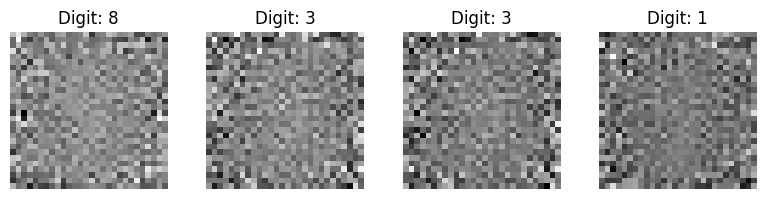

Epoch [72/100], i: 0, Loss: 0.0804
Epoch [72/100], i: 100, Loss: 0.0828
Epoch [72/100], i: 200, Loss: 0.0896
Epoch [72/100], i: 300, Loss: 0.0716
Epoch [72/100], i: 400, Loss: 0.0814
Epoch [73/100], i: 0, Loss: 0.0880
Epoch [73/100], i: 100, Loss: 0.0900
Epoch [73/100], i: 200, Loss: 0.0825
Epoch [73/100], i: 300, Loss: 0.0819
Epoch [73/100], i: 400, Loss: 0.0993
Epoch [74/100], i: 0, Loss: 0.0889
Epoch [74/100], i: 100, Loss: 0.0801
Epoch [74/100], i: 200, Loss: 0.0984
Epoch [74/100], i: 300, Loss: 0.0879
Epoch [74/100], i: 400, Loss: 0.0875
Epoch [75/100], i: 0, Loss: 0.0768
Epoch [75/100], i: 100, Loss: 0.1034
Epoch [75/100], i: 200, Loss: 0.0782
Epoch [75/100], i: 300, Loss: 0.0924
Epoch [75/100], i: 400, Loss: 0.0798
Epoch [76/100], i: 0, Loss: 0.0844
Epoch [76/100], i: 100, Loss: 0.1078
Epoch [76/100], i: 200, Loss: 0.0854
Epoch [76/100], i: 300, Loss: 0.0760
Epoch [76/100], i: 400, Loss: 0.0776


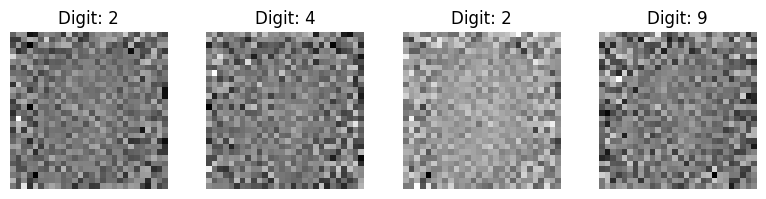

Epoch [77/100], i: 0, Loss: 0.0802
Epoch [77/100], i: 100, Loss: 0.0811
Epoch [77/100], i: 200, Loss: 0.0845
Epoch [77/100], i: 300, Loss: 0.0765
Epoch [77/100], i: 400, Loss: 0.0739
Epoch [78/100], i: 0, Loss: 0.0741
Epoch [78/100], i: 100, Loss: 0.0935
Epoch [78/100], i: 200, Loss: 0.0717
Epoch [78/100], i: 300, Loss: 0.0775
Epoch [78/100], i: 400, Loss: 0.0896
Epoch [79/100], i: 0, Loss: 0.0828
Epoch [79/100], i: 100, Loss: 0.0871
Epoch [79/100], i: 200, Loss: 0.0782
Epoch [79/100], i: 300, Loss: 0.0858
Epoch [79/100], i: 400, Loss: 0.0890
Epoch [80/100], i: 0, Loss: 0.0846
Epoch [80/100], i: 100, Loss: 0.0776
Epoch [80/100], i: 200, Loss: 0.0708
Epoch [80/100], i: 300, Loss: 0.0774
Epoch [80/100], i: 400, Loss: 0.0911
Epoch [81/100], i: 0, Loss: 0.0817
Epoch [81/100], i: 100, Loss: 0.0842
Epoch [81/100], i: 200, Loss: 0.0988
Epoch [81/100], i: 300, Loss: 0.1002
Epoch [81/100], i: 400, Loss: 0.0735


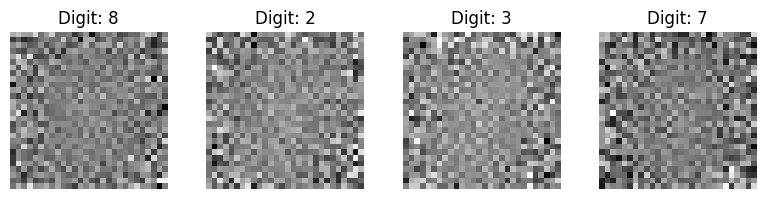

Epoch [82/100], i: 0, Loss: 0.0857
Epoch [82/100], i: 100, Loss: 0.0921
Epoch [82/100], i: 200, Loss: 0.0772
Epoch [82/100], i: 300, Loss: 0.0821
Epoch [82/100], i: 400, Loss: 0.0843
Epoch [83/100], i: 0, Loss: 0.0825
Epoch [83/100], i: 100, Loss: 0.0758
Epoch [83/100], i: 200, Loss: 0.0807
Epoch [83/100], i: 300, Loss: 0.0714
Epoch [83/100], i: 400, Loss: 0.0923
Epoch [84/100], i: 0, Loss: 0.0871
Epoch [84/100], i: 100, Loss: 0.0841
Epoch [84/100], i: 200, Loss: 0.0780
Epoch [84/100], i: 300, Loss: 0.0939
Epoch [84/100], i: 400, Loss: 0.0743
Epoch [85/100], i: 0, Loss: 0.0846
Epoch [85/100], i: 100, Loss: 0.0826
Epoch [85/100], i: 200, Loss: 0.0929
Epoch [85/100], i: 300, Loss: 0.0786
Epoch [85/100], i: 400, Loss: 0.0720
Epoch [86/100], i: 0, Loss: 0.0857
Epoch [86/100], i: 100, Loss: 0.0792
Epoch [86/100], i: 200, Loss: 0.0869
Epoch [86/100], i: 300, Loss: 0.0972
Epoch [86/100], i: 400, Loss: 0.0862


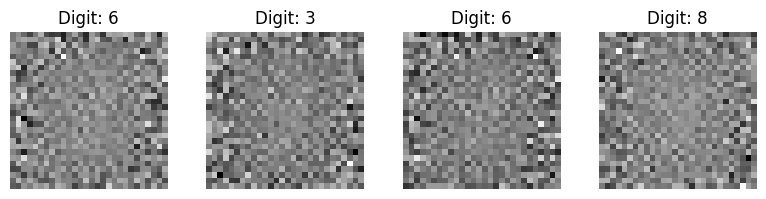

Epoch [87/100], i: 0, Loss: 0.0767
Epoch [87/100], i: 100, Loss: 0.0863
Epoch [87/100], i: 200, Loss: 0.0857
Epoch [87/100], i: 300, Loss: 0.0778
Epoch [87/100], i: 400, Loss: 0.0976
Epoch [88/100], i: 0, Loss: 0.0788
Epoch [88/100], i: 100, Loss: 0.0900
Epoch [88/100], i: 200, Loss: 0.0918
Epoch [88/100], i: 300, Loss: 0.0785
Epoch [88/100], i: 400, Loss: 0.0888
Epoch [89/100], i: 0, Loss: 0.0804
Epoch [89/100], i: 100, Loss: 0.0938
Epoch [89/100], i: 200, Loss: 0.0762
Epoch [89/100], i: 300, Loss: 0.0864
Epoch [89/100], i: 400, Loss: 0.0833
Epoch [90/100], i: 0, Loss: 0.0814
Epoch [90/100], i: 100, Loss: 0.0847
Epoch [90/100], i: 200, Loss: 0.0935
Epoch [90/100], i: 300, Loss: 0.0767
Epoch [90/100], i: 400, Loss: 0.0985
Epoch [91/100], i: 0, Loss: 0.0936
Epoch [91/100], i: 100, Loss: 0.0880
Epoch [91/100], i: 200, Loss: 0.0866
Epoch [91/100], i: 300, Loss: 0.0825
Epoch [91/100], i: 400, Loss: 0.0928


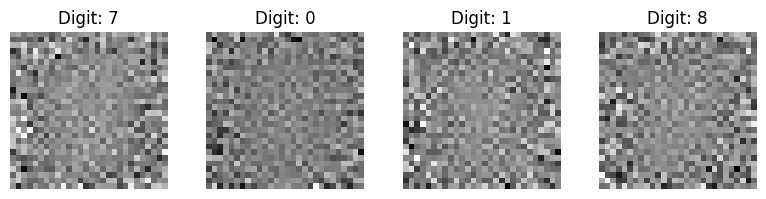

Epoch [92/100], i: 0, Loss: 0.0884
Epoch [92/100], i: 100, Loss: 0.0867
Epoch [92/100], i: 200, Loss: 0.0846
Epoch [92/100], i: 300, Loss: 0.0856
Epoch [92/100], i: 400, Loss: 0.0813
Epoch [93/100], i: 0, Loss: 0.0758
Epoch [93/100], i: 100, Loss: 0.0726
Epoch [93/100], i: 200, Loss: 0.0718
Epoch [93/100], i: 300, Loss: 0.0860
Epoch [93/100], i: 400, Loss: 0.0839
Epoch [94/100], i: 0, Loss: 0.0867
Epoch [94/100], i: 100, Loss: 0.0791
Epoch [94/100], i: 200, Loss: 0.0929
Epoch [94/100], i: 300, Loss: 0.0952
Epoch [94/100], i: 400, Loss: 0.0816
Epoch [95/100], i: 0, Loss: 0.0840
Epoch [95/100], i: 100, Loss: 0.0913
Epoch [95/100], i: 200, Loss: 0.0800
Epoch [95/100], i: 300, Loss: 0.0718
Epoch [95/100], i: 400, Loss: 0.0817
Epoch [96/100], i: 0, Loss: 0.0737
Epoch [96/100], i: 100, Loss: 0.0804
Epoch [96/100], i: 200, Loss: 0.0862
Epoch [96/100], i: 300, Loss: 0.0856
Epoch [96/100], i: 400, Loss: 0.0965


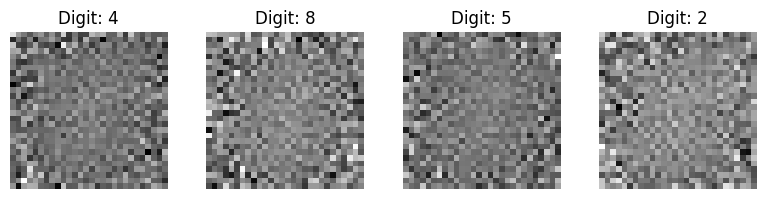

Epoch [97/100], i: 0, Loss: 0.0953
Epoch [97/100], i: 100, Loss: 0.0773
Epoch [97/100], i: 200, Loss: 0.0814
Epoch [97/100], i: 300, Loss: 0.0789
Epoch [97/100], i: 400, Loss: 0.0833
Epoch [98/100], i: 0, Loss: 0.0877
Epoch [98/100], i: 100, Loss: 0.0905
Epoch [98/100], i: 200, Loss: 0.0733
Epoch [98/100], i: 300, Loss: 0.0949
Epoch [98/100], i: 400, Loss: 0.0749
Epoch [99/100], i: 0, Loss: 0.0824
Epoch [99/100], i: 100, Loss: 0.0640
Epoch [99/100], i: 200, Loss: 0.0678
Epoch [99/100], i: 300, Loss: 0.0886
Epoch [99/100], i: 400, Loss: 0.0742
Epoch [100/100], i: 0, Loss: 0.0953
Epoch [100/100], i: 100, Loss: 0.0819
Epoch [100/100], i: 200, Loss: 0.0933
Epoch [100/100], i: 300, Loss: 0.0763
Epoch [100/100], i: 400, Loss: 0.0752


In [139]:
train()

### What worked
- Trying lots of things and printing results in between
- Skip connections (gradients need to flow)
- Deeper and wider network (more parameters)
- Layernorm
- Batchnorm (should have worked if inference had same batch number as training)
- Regularizing weights
- Training for longer (loss does come down even after flattning)

### What didn't work
- Inference on diffusion (am I doing it right?)

### Reading some articles now

- https://theaisummer.com/diffusion-models/
- https://www.chenyang.co/diffusion.html


My understanding
- We need to predict the noise level (and not noised image/artifact)
- Noise level is not uniformly sampled (a schedule like log-linear ensures denoising happens in big steps earlier in process and then smaller and smaller steps later)

#### TLDR

so here's what i understand

noisy_image = image + noise_level * noise

noise_level is taken from a schedule like log_linear that can range from 0.1 to 1 (in 1000 steps or so). 

noise is sampled from Gaussian (0,1)

we need in noisy_image and noise_level into a network and minimize loss of predicted noise and actual noise that was added

Furthermore, it is important to keep noisy_image within the domain of image (so that in case of MNIST all values remain in 0-1, which can be done by clipping)

during inference, the process runs in reverse

- you start with noisy image
- you start with highest value of noise level
- predict noise
- subtract it

do it over all values of noise level (in reverse order, largest to smallest)

**Let's try implementing it**

In [141]:
class DiffusionModel(nn.Module):
    def __init__(self, img_size, timesteps, num_classes):
        super().__init__()
        self.img_size = img_size
        self.timesteps = timesteps
        self.num_classes = num_classes
        
        self.encoder = nn.Sequential(
            nn.Linear(img_size * img_size + 1 + num_classes, 1024),
            nn.LayerNorm(1024),
            nn.ReLU()
        )
        
        self.residual_blocks = nn.ModuleList([
            nn.Sequential(
                nn.Linear(1024, 1024),
                nn.LayerNorm(1024),
                nn.ReLU(),
                nn.Linear(1024, 1024),
                nn.LayerNorm(1024),
                nn.ReLU()
            ) for _ in range(10)  # Number of residual blocks (changed to 10)
        ])
        
        self.decoder = nn.Sequential(
            nn.Linear(1024, img_size * img_size)
        )

    def forward(self, x, t, y):
        x_orig = x.view(-1, self.img_size * self.img_size)  # for residual connection
        t = t.unsqueeze(1)
        y = nn.functional.one_hot(y, num_classes=self.num_classes).float()
        
        x = torch.cat([x_orig, t, y], dim=1)
        x = self.encoder(x)
        
        for block in self.residual_blocks:
            residual = x
            x = block(x)
            x = x + residual  # Skip connection within residual blocks
        
        x = self.decoder(x)
        x = x + x_orig  # Residual connection from pixel values
        
        return x.view(-1, 1, self.img_size, self.img_size)

In [142]:
import numpy as np

def log_linear_schedule(min_sigma, max_sigma, num_steps):
    log_min_sigma = np.log(min_sigma)
    log_max_sigma = np.log(max_sigma)
    noise_levels = np.exp(np.linspace(log_min_sigma, log_max_sigma, num_steps))
    return noise_levels

In [143]:
min_sigma = 0.01
max_sigma = 1.0
num_steps = 1000

noise_schedule = log_linear_schedule(min_sigma, max_sigma, num_steps)

In [144]:
noise_schedule

array([0.01      , 0.0100462 , 0.01009262, 0.01013925, 0.0101861 ,
       0.01023317, 0.01028045, 0.01032795, 0.01037567, 0.01042361,
       0.01047177, 0.01052015, 0.01056876, 0.01061759, 0.01066665,
       0.01071593, 0.01076545, 0.01081519, 0.01086516, 0.01091536,
       0.01096579, 0.01101646, 0.01106736, 0.0111185 , 0.01116987,
       0.01122148, 0.01127333, 0.01132541, 0.01137774, 0.01143031,
       0.01148312, 0.01153618, 0.01158948, 0.01164303, 0.01169683,
       0.01175087, 0.01180517, 0.01185971, 0.01191451, 0.01196956,
       0.01202486, 0.01208042, 0.01213624, 0.01219231, 0.01224865,
       0.01230524, 0.0123621 , 0.01241921, 0.0124766 , 0.01253424,
       0.01259216, 0.01265034, 0.01270879, 0.01276751, 0.0128265 ,
       0.01288576, 0.0129453 , 0.01300511, 0.0130652 , 0.01312557,
       0.01318621, 0.01324714, 0.01330835, 0.01336984, 0.01343161,
       0.01349367, 0.01355602, 0.01361865, 0.01368158, 0.01374479,
       0.0138083 , 0.0138721 , 0.01393619, 0.01400058, 0.01406

In [148]:
import torch

def log_linear_schedule(min_sigma, max_sigma, num_steps):
    log_min_sigma = torch.log(torch.tensor(min_sigma))
    log_max_sigma = torch.log(torch.tensor(max_sigma))
    noise_levels = torch.exp(torch.linspace(log_min_sigma, log_max_sigma, num_steps))
    return noise_levels

# Set the device (e.g., 'cuda' or 'cpu')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

min_sigma = 0.1
max_sigma = 1.0
num_steps = 1000

# Generate the log-linear noise schedule
noise_schedule = log_linear_schedule(min_sigma, max_sigma, num_steps)

# Convert the noise schedule to a PyTorch tensor
noise_schedule_tensor = noise_schedule.to(device)

# Randomly generate timesteps for each example in the batch
t = torch.randint(0, num_steps, (data.shape[0],), device=device)

# Retrieve the corresponding noise levels for each example in the batch
noise_levels = noise_schedule_tensor[t]

In [149]:
noise_levels, t

(tensor([0.8451, 0.2261, 0.7887, 0.3737, 0.2561, 0.1133, 0.2700, 0.4739, 0.9616,
         0.3115, 0.9908, 0.5778, 0.2184, 0.5392, 0.1672, 0.4739, 0.3080, 0.6135,
         0.6050, 0.1365, 0.7242, 0.5633, 0.3072, 0.7514, 0.1343, 0.5995, 0.1069,
         0.2585, 0.6604, 0.6023, 0.1295, 0.2468, 0.6394, 0.2006, 0.2272, 0.5055,
         0.1929, 0.1446, 0.3905, 0.5281, 0.2651, 0.3151, 0.6092, 0.3798, 0.2526,
         0.9528, 0.1723, 0.1130, 0.8127, 0.4894, 0.1087, 0.2010, 0.2808, 0.2627,
         0.1974, 0.3308, 0.3781, 0.5858, 0.8278, 0.5543, 0.1699, 0.3878, 0.8809,
         0.2934, 0.1942, 0.4578, 0.2357, 0.7077, 0.7887, 0.3037, 0.7077, 0.3285,
         0.6681, 0.1956, 0.9506, 0.7360, 0.1084, 0.4883, 0.1420, 0.8648, 0.9506,
         0.9795, 0.4136, 0.2927, 0.8850, 0.9795, 0.1487, 0.1684, 0.1974, 0.2110,
         0.1739, 0.7887, 0.1747, 0.4474, 0.3686, 0.7905, 0.7689, 0.4351, 0.1695,
         0.3181, 1.0000, 0.2446, 0.1808, 0.1872, 0.5269, 0.9705, 0.4794, 0.1403,
         0.6350, 0.4252, 0.1

### Let's visualize how noisy images look

torch.Size([128, 1, 28, 28])
torch.Size([128])
torch.Size([128, 1, 1, 1])
torch.Size([128, 1, 28, 28])


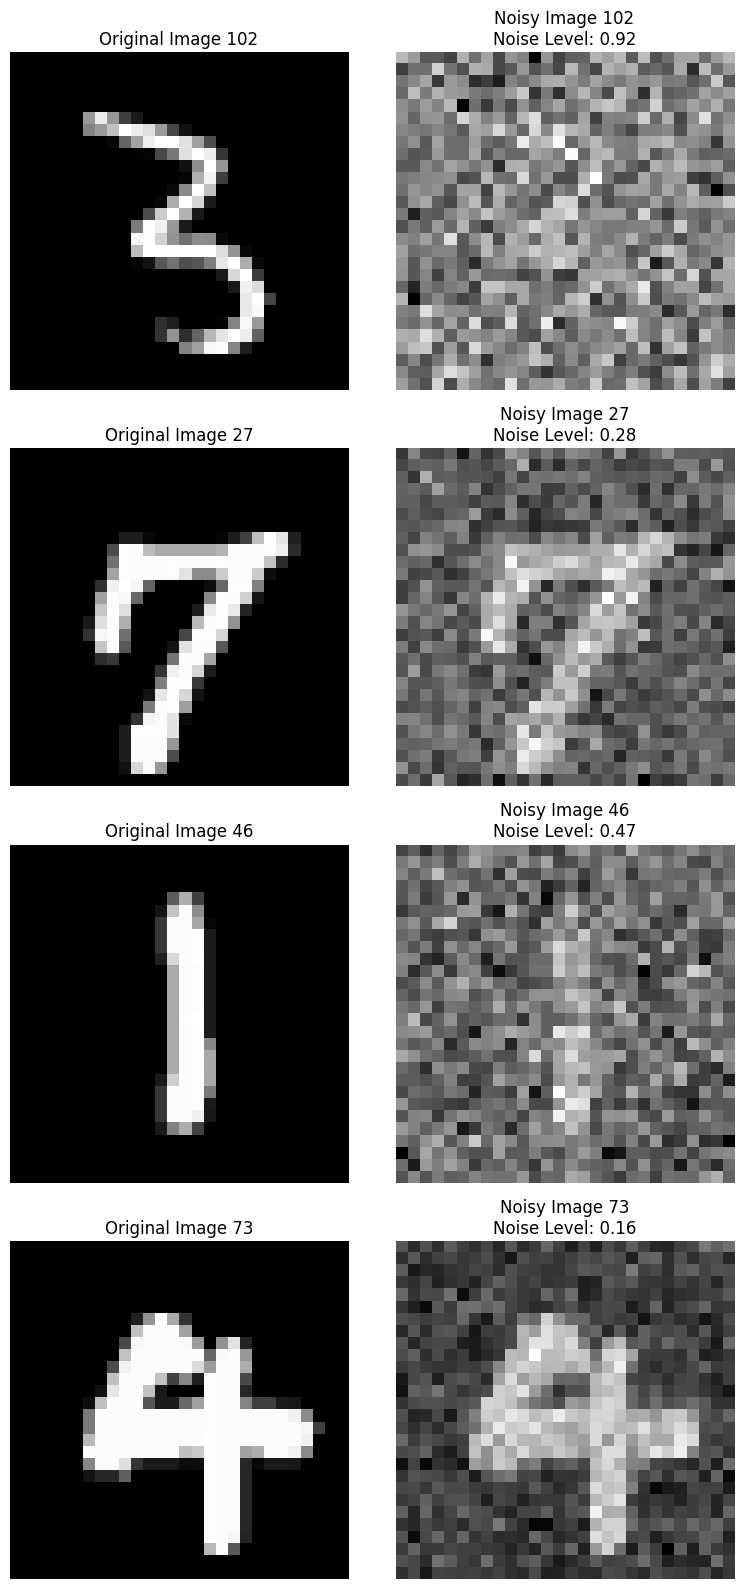

In [162]:

for epoch in range(1):
    i = 0
    for data, labels in trainloader:
        ## data here is 128 batch size of each image and labels is 128 batch size of each label
        data, labels = data.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        # t here is random integer with values between 0 and 999, representing timesteps for each example in the batch
        t = torch.randint(0, 1000, (data.shape[0],), device=device)
        
        # generates random noise (mean 0, sd 1) tensor with the same shape as input data
        noise = torch.randn_like(data)
        print(noise.shape)

        # Generate the log-linear noise schedule
        noise_schedule = log_linear_schedule(min_sigma, max_sigma, num_steps)
        
        # Convert the noise schedule to a PyTorch tensor
        noise_schedule_tensor = noise_schedule.to(device)
        
        # Randomly generate timesteps for each example in the batch
        t = torch.randint(0, num_steps, (data.shape[0],), device=device)
        
        # Retrieve the corresponding noise levels for each example in the batch
        noise_levels = noise_schedule_tensor[t]

        # Reshape noise_levels to match the shape of noise
        noise_levels_reshaped = noise_levels.view(-1, 1, 1, 1)
        
        print(noise_levels.shape)
        print(noise_levels_reshaped.shape)
        print(data.shape)
        
        
        # adds noise to input data based on timesteps. Scales noise by a factor calculated using the timesteps
        noisy_data = data + noise * noise_levels_reshaped
        
        # Visualize original and noisy images for a few random samples
        if i % 1 == 0:  # Adjust the frequency of visualization as needed
            num_samples = 4  # Number of samples to visualize
            indices = np.random.choice(data.shape[0], num_samples, replace=False)
            
            fig, axes = plt.subplots(num_samples, 2, figsize=(8, num_samples*4))
            for j, idx in enumerate(indices):
                original_img = data[idx].cpu().numpy().transpose(1, 2, 0)
                noisy_img = noisy_data[idx].cpu().numpy().transpose(1, 2, 0)
                noise_level = noise_levels_reshaped[idx].item()  # Get the noise level for the current sample and convert to scalar
                
                axes[j, 0].imshow(original_img, cmap='gray')
                axes[j, 0].set_title(f"Original Image {idx}")
                axes[j, 0].axis('off')
                
                axes[j, 1].imshow(noisy_img, cmap='gray')
                axes[j, 1].set_title(f"Noisy Image {idx}\nNoise Level: {noise_level:.2f}")
                axes[j, 1].axis('off')
            
            plt.tight_layout()
            plt.show()
            break
        
        i += 1
            
            # Rest of your training code...

In [163]:
noisy_idx = 102
noisy_data[noisy_idx].shape

torch.Size([1, 28, 28])

In [164]:
noisy_data[noisy_idx]

tensor([[[ 1.2444e+00,  5.9031e-01, -9.4058e-01, -9.0934e-01, -1.4011e+00,
           1.0811e+00, -3.9108e-01,  7.8565e-01, -1.3235e+00,  4.2751e-01,
           3.2906e-03, -2.8834e+00,  4.4461e-01, -1.4098e+00, -7.6294e-01,
          -6.8231e-01,  1.1121e+00,  7.2003e-01,  1.2751e+00, -8.3459e-01,
           1.3448e+00, -1.0832e+00, -3.9374e-01,  7.3650e-01,  8.2484e-01,
          -3.9854e-01,  6.0943e-01,  1.2428e+00],
         [-1.4859e+00, -3.6684e-01, -3.9420e-01,  1.7633e+00, -3.1746e-01,
          -1.1132e+00,  1.0564e+00,  9.2600e-01, -1.3407e+00, -9.3933e-01,
           4.8518e-01, -1.0552e+00, -3.8522e-01, -1.3002e+00,  1.2068e+00,
          -3.3597e-01, -1.3393e+00,  1.0958e+00,  7.1119e-01,  1.0408e+00,
          -8.4856e-01, -5.7077e-01, -9.6095e-01,  8.8495e-01, -1.9500e+00,
           1.2903e+00, -4.4000e-01,  5.3373e-01],
         [-3.0472e-01,  1.4827e-01,  8.1161e-01, -1.6663e+00,  5.7532e-01,
           2.0646e-01, -1.9214e+00, -1.5758e+00, -2.2766e+00,  2.7941e-02,


In [165]:
## let's see if it goes beyond 0 or 1

min_value = torch.min(noisy_data[noisy_idx]).item()
max_value = torch.max(noisy_data[noisy_idx]).item()
print(min_value, max_value)

-2.9297444820404053 2.845409870147705


### How does implot interpret values beyond 0-1

It normailizes by min and max, so doesnt matter if it is in 0-1 or 1-255

#### Also, it doesn't matter in the training also as network will learn appropriate scaling as and when required and since in inference we start with noise generated

Here's how the initial noisy image is typically generated at inference time:

Random noise sampling:

Generate a random noise tensor with the same shape as the desired output image.
The noise is usually sampled from a standard Gaussian distribution with mean 0 and variance 1.
This random noise tensor serves as the initial noisy image.


Scaling the noise:

Multiply the random noise tensor by the maximum noise level (σ_max) used during training.
This scaling ensures that the initial noisy image has the same noise level as the maximum noise level encountered during training.

`def generate_initial_noisy_image(shape, device):
    noise = torch.randn(shape, device=device)
    noisy_image = noise * noise_levels_reshaped[-1]  # Scale by the maximum noise level
    return noisy_image
`

In [166]:
import random
import matplotlib.pyplot as plt
import torch

def sample_image_multiple(num_samples=1, noise_schedule=None):
    with torch.no_grad():
        # Generate initial noisy image with the maximum noise level
        max_noise_level = noise_schedule[-1]
        x = torch.randn(num_samples, 1, 28, 28).to(device) * max_noise_level
        
        y = torch.randint(0, 10, (num_samples,)).to(device) # Generate random target labels
        
        for t in range(len(noise_schedule) - 1, -1, -1):
            noise_level = noise_schedule[t]
            t_tensor = torch.tensor([t]).expand(num_samples).to(device)
            
            predicted_noise = model(x, t_tensor, y)
            x = x - noise_level * predicted_noise
        
        generated_samples = x.cpu().squeeze().numpy()
    
    fig, axs = plt.subplots(1, num_samples, figsize=(num_samples * 2, 2))
    
    for i in range(num_samples):
        if num_samples == 1:
            axs.imshow(generated_samples[i], cmap="gray")
            axs.set_title(f"Digit: {y[i].item()}")
            axs.axis("off")
        else:
            axs[i].imshow(generated_samples[i], cmap="gray")
            axs[i].set_title(f"Digit: {y[i].item()}")
            axs[i].axis("off")
    
    plt.tight_layout()
    plt.show()

In [168]:
import torch

min_sigma = 0.1
max_sigma = 1.0
num_steps = 1000

# Generate the log-linear noise schedule
noise_schedule = log_linear_schedule(min_sigma, max_sigma, num_steps)

# Convert the noise schedule to a PyTorch tensor
noise_schedule_tensor = noise_schedule.to(device)

def train():
    for epoch in range(100):
        i = 0
        for data, labels in trainloader:
            ## data here is 128 batch size of each image and labels is 128 batch size of each label
            data, labels = data.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            # Randomly generate timesteps for each example in the batch
            t = torch.randint(0, num_steps, (data.shape[0],), device=device)
            
            # Retrieve the corresponding noise levels for each example in the batch
            noise_levels = noise_schedule_tensor[t].view(-1, 1, 1, 1)  # Reshape noise levels to match the batch dimensions
            
            # generates random noise (mean 0, sd 1) tensor with the same shape as input data
            noise = torch.randn_like(data)
            
            # adds noise to input data based on timesteps. Scales noise by a factor calculated using the timesteps
            noisy_data = data + noise * noise_levels
            
            predicted_noise = model(noisy_data, t, labels)
            loss = criterion(predicted_noise, noise)
            
            loss.backward()
            optimizer.step()
            
            if (i % 100) == 0:
                print(f"Epoch [{epoch+1}/100], i: {i}, Loss: {loss.item():.4f}")
            
            i += 1
        
        if epoch % 5 == 0:
            sample_image_multiple(num_samples=4, noise_schedule=noise_schedule_tensor.cpu().numpy())

In [170]:
transform = transforms.Compose([transforms.ToTensor()])
trainset = datasets.MNIST('data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)
model = DiffusionModel(img_size=28, timesteps=1000, num_classes=10).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
criterion = nn.MSELoss()

Epoch [1/100], i: 0, Loss: 7.8439
Epoch [1/100], i: 100, Loss: 0.5298
Epoch [1/100], i: 200, Loss: 0.5172
Epoch [1/100], i: 300, Loss: 0.4929
Epoch [1/100], i: 400, Loss: 0.3971


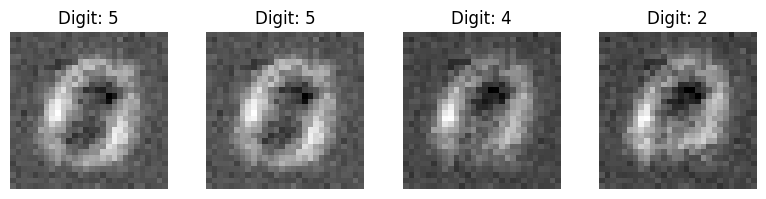

Epoch [2/100], i: 0, Loss: 0.3441
Epoch [2/100], i: 100, Loss: 0.3377
Epoch [2/100], i: 200, Loss: 0.3236
Epoch [2/100], i: 300, Loss: 0.3270
Epoch [2/100], i: 400, Loss: 0.3399
Epoch [3/100], i: 0, Loss: 0.3159
Epoch [3/100], i: 100, Loss: 0.3014
Epoch [3/100], i: 200, Loss: 0.2841
Epoch [3/100], i: 300, Loss: 0.2886
Epoch [3/100], i: 400, Loss: 0.2955
Epoch [4/100], i: 0, Loss: 0.2634
Epoch [4/100], i: 100, Loss: 0.2689
Epoch [4/100], i: 200, Loss: 0.2634
Epoch [4/100], i: 300, Loss: 0.2615
Epoch [4/100], i: 400, Loss: 0.2594
Epoch [5/100], i: 0, Loss: 0.2485
Epoch [5/100], i: 100, Loss: 0.2578
Epoch [5/100], i: 200, Loss: 0.2463
Epoch [5/100], i: 300, Loss: 0.2369
Epoch [5/100], i: 400, Loss: 0.2418
Epoch [6/100], i: 0, Loss: 0.2552
Epoch [6/100], i: 100, Loss: 0.2386
Epoch [6/100], i: 200, Loss: 0.2077
Epoch [6/100], i: 300, Loss: 0.2126
Epoch [6/100], i: 400, Loss: 0.2389


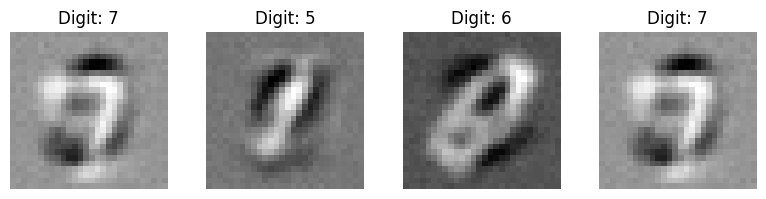

Epoch [7/100], i: 0, Loss: 0.2133
Epoch [7/100], i: 100, Loss: 0.2250
Epoch [7/100], i: 200, Loss: 0.2106
Epoch [7/100], i: 300, Loss: 0.2159
Epoch [7/100], i: 400, Loss: 0.2186
Epoch [8/100], i: 0, Loss: 0.2110
Epoch [8/100], i: 100, Loss: 0.1959
Epoch [8/100], i: 200, Loss: 0.2131
Epoch [8/100], i: 300, Loss: 0.2012
Epoch [8/100], i: 400, Loss: 0.2136
Epoch [9/100], i: 0, Loss: 0.2145
Epoch [9/100], i: 100, Loss: 0.2161
Epoch [9/100], i: 200, Loss: 0.2074
Epoch [9/100], i: 300, Loss: 0.2032
Epoch [9/100], i: 400, Loss: 0.2078
Epoch [10/100], i: 0, Loss: 0.2248
Epoch [10/100], i: 100, Loss: 0.2140
Epoch [10/100], i: 200, Loss: 0.2035
Epoch [10/100], i: 300, Loss: 0.2035
Epoch [10/100], i: 400, Loss: 0.1976
Epoch [11/100], i: 0, Loss: 0.1993
Epoch [11/100], i: 100, Loss: 0.2166
Epoch [11/100], i: 200, Loss: 0.1829
Epoch [11/100], i: 300, Loss: 0.2064
Epoch [11/100], i: 400, Loss: 0.1961


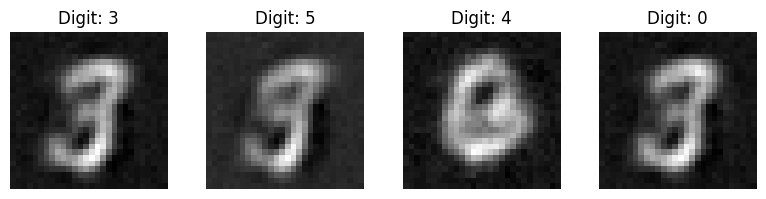

Epoch [12/100], i: 0, Loss: 0.1946
Epoch [12/100], i: 100, Loss: 0.1974
Epoch [12/100], i: 200, Loss: 0.1934
Epoch [12/100], i: 300, Loss: 0.2022
Epoch [12/100], i: 400, Loss: 0.2023
Epoch [13/100], i: 0, Loss: 0.1852
Epoch [13/100], i: 100, Loss: 0.1870
Epoch [13/100], i: 200, Loss: 0.2072
Epoch [13/100], i: 300, Loss: 0.1945
Epoch [13/100], i: 400, Loss: 0.1979
Epoch [14/100], i: 0, Loss: 0.1939
Epoch [14/100], i: 100, Loss: 0.1926
Epoch [14/100], i: 200, Loss: 0.1921
Epoch [14/100], i: 300, Loss: 0.1928
Epoch [14/100], i: 400, Loss: 0.1974
Epoch [15/100], i: 0, Loss: 0.1989
Epoch [15/100], i: 100, Loss: 0.2093
Epoch [15/100], i: 200, Loss: 0.1915
Epoch [15/100], i: 300, Loss: 0.1885
Epoch [15/100], i: 400, Loss: 0.1830
Epoch [16/100], i: 0, Loss: 0.1963
Epoch [16/100], i: 100, Loss: 0.2000
Epoch [16/100], i: 200, Loss: 0.1744
Epoch [16/100], i: 300, Loss: 0.1907
Epoch [16/100], i: 400, Loss: 0.2000


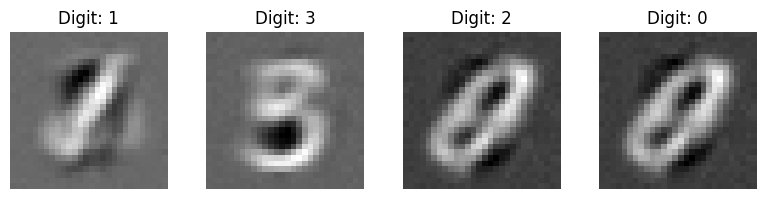

Epoch [17/100], i: 0, Loss: 0.2154
Epoch [17/100], i: 100, Loss: 0.1908
Epoch [17/100], i: 200, Loss: 0.1771
Epoch [17/100], i: 300, Loss: 0.1851
Epoch [17/100], i: 400, Loss: 0.1983
Epoch [18/100], i: 0, Loss: 0.1962
Epoch [18/100], i: 100, Loss: 0.1879
Epoch [18/100], i: 200, Loss: 0.1859
Epoch [18/100], i: 300, Loss: 0.1859
Epoch [18/100], i: 400, Loss: 0.1913
Epoch [19/100], i: 0, Loss: 0.1936
Epoch [19/100], i: 100, Loss: 0.1852
Epoch [19/100], i: 200, Loss: 0.2005
Epoch [19/100], i: 300, Loss: 0.2008
Epoch [19/100], i: 400, Loss: 0.1897
Epoch [20/100], i: 0, Loss: 0.1893
Epoch [20/100], i: 100, Loss: 0.1864
Epoch [20/100], i: 200, Loss: 0.1863
Epoch [20/100], i: 300, Loss: 0.1853
Epoch [20/100], i: 400, Loss: 0.1789
Epoch [21/100], i: 0, Loss: 0.1909
Epoch [21/100], i: 100, Loss: 0.1940
Epoch [21/100], i: 200, Loss: 0.1929
Epoch [21/100], i: 300, Loss: 0.1874
Epoch [21/100], i: 400, Loss: 0.1937


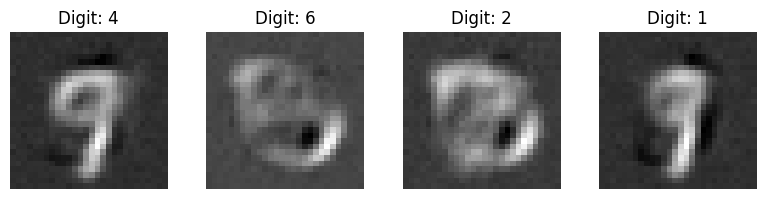

Epoch [22/100], i: 0, Loss: 0.1824
Epoch [22/100], i: 100, Loss: 0.1869
Epoch [22/100], i: 200, Loss: 0.1769
Epoch [22/100], i: 300, Loss: 0.1728
Epoch [22/100], i: 400, Loss: 0.1946
Epoch [23/100], i: 0, Loss: 0.1970
Epoch [23/100], i: 100, Loss: 0.1854
Epoch [23/100], i: 200, Loss: 0.1743
Epoch [23/100], i: 300, Loss: 0.2091
Epoch [23/100], i: 400, Loss: 0.1976
Epoch [24/100], i: 0, Loss: 0.1836
Epoch [24/100], i: 100, Loss: 0.1788
Epoch [24/100], i: 200, Loss: 0.1960
Epoch [24/100], i: 300, Loss: 0.1833
Epoch [24/100], i: 400, Loss: 0.1686
Epoch [25/100], i: 0, Loss: 0.1913
Epoch [25/100], i: 100, Loss: 0.1930
Epoch [25/100], i: 200, Loss: 0.1895
Epoch [25/100], i: 300, Loss: 0.1839
Epoch [25/100], i: 400, Loss: 0.1844
Epoch [26/100], i: 0, Loss: 0.1871
Epoch [26/100], i: 100, Loss: 0.1872
Epoch [26/100], i: 200, Loss: 0.1871
Epoch [26/100], i: 300, Loss: 0.1930
Epoch [26/100], i: 400, Loss: 0.1798


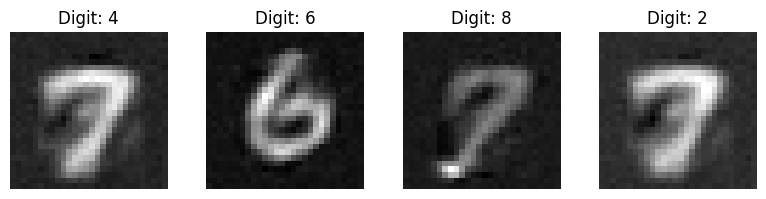

Epoch [27/100], i: 0, Loss: 0.1901
Epoch [27/100], i: 100, Loss: 0.1856
Epoch [27/100], i: 200, Loss: 0.1763
Epoch [27/100], i: 300, Loss: 0.1853
Epoch [27/100], i: 400, Loss: 0.1951
Epoch [28/100], i: 0, Loss: 0.1825
Epoch [28/100], i: 100, Loss: 0.1838
Epoch [28/100], i: 200, Loss: 0.1954
Epoch [28/100], i: 300, Loss: 0.1758
Epoch [28/100], i: 400, Loss: 0.1890
Epoch [29/100], i: 0, Loss: 0.1897
Epoch [29/100], i: 100, Loss: 0.1831
Epoch [29/100], i: 200, Loss: 0.1745
Epoch [29/100], i: 300, Loss: 0.1783
Epoch [29/100], i: 400, Loss: 0.1823
Epoch [30/100], i: 0, Loss: 0.1837
Epoch [30/100], i: 100, Loss: 0.1717
Epoch [30/100], i: 200, Loss: 0.1940
Epoch [30/100], i: 300, Loss: 0.1818
Epoch [30/100], i: 400, Loss: 0.1656
Epoch [31/100], i: 0, Loss: 0.1732
Epoch [31/100], i: 100, Loss: 0.1818
Epoch [31/100], i: 200, Loss: 0.1836
Epoch [31/100], i: 300, Loss: 0.1756
Epoch [31/100], i: 400, Loss: 0.1859


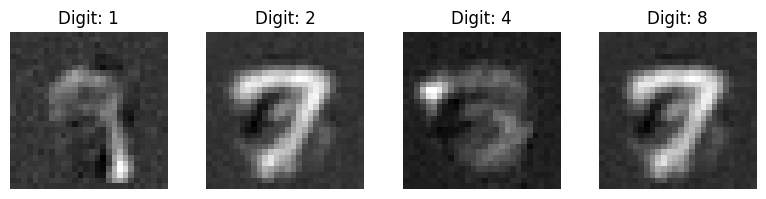

Epoch [32/100], i: 0, Loss: 0.1726
Epoch [32/100], i: 100, Loss: 0.1769
Epoch [32/100], i: 200, Loss: 0.1637
Epoch [32/100], i: 300, Loss: 0.1715
Epoch [32/100], i: 400, Loss: 0.1754
Epoch [33/100], i: 0, Loss: 0.1839
Epoch [33/100], i: 100, Loss: 0.1722
Epoch [33/100], i: 200, Loss: 0.1645
Epoch [33/100], i: 300, Loss: 0.1716
Epoch [33/100], i: 400, Loss: 0.1537
Epoch [34/100], i: 0, Loss: 0.1564
Epoch [34/100], i: 100, Loss: 0.1794
Epoch [34/100], i: 200, Loss: 0.1816
Epoch [34/100], i: 300, Loss: 0.1740
Epoch [34/100], i: 400, Loss: 0.1739
Epoch [35/100], i: 0, Loss: 0.1745
Epoch [35/100], i: 100, Loss: 0.1686
Epoch [35/100], i: 200, Loss: 0.1742
Epoch [35/100], i: 300, Loss: 0.1815
Epoch [35/100], i: 400, Loss: 0.1645
Epoch [36/100], i: 0, Loss: 0.1793
Epoch [36/100], i: 100, Loss: 0.1675
Epoch [36/100], i: 200, Loss: 0.1703
Epoch [36/100], i: 300, Loss: 0.1748
Epoch [36/100], i: 400, Loss: 0.1775


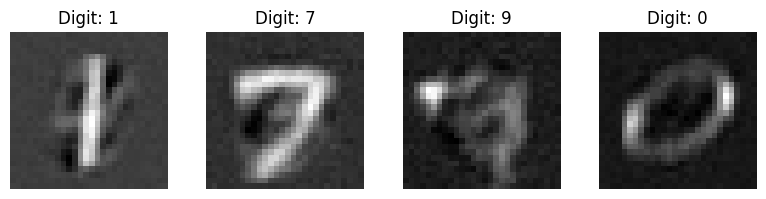

Epoch [37/100], i: 0, Loss: 0.1755
Epoch [37/100], i: 100, Loss: 0.1843
Epoch [37/100], i: 200, Loss: 0.1752
Epoch [37/100], i: 300, Loss: 0.1745
Epoch [37/100], i: 400, Loss: 0.1814
Epoch [38/100], i: 0, Loss: 0.1700
Epoch [38/100], i: 100, Loss: 0.1700
Epoch [38/100], i: 200, Loss: 0.1661
Epoch [38/100], i: 300, Loss: 0.1890
Epoch [38/100], i: 400, Loss: 0.1724
Epoch [39/100], i: 0, Loss: 0.1640
Epoch [39/100], i: 100, Loss: 0.1814
Epoch [39/100], i: 200, Loss: 0.1864
Epoch [39/100], i: 300, Loss: 0.1819
Epoch [39/100], i: 400, Loss: 0.1866
Epoch [40/100], i: 0, Loss: 0.1735
Epoch [40/100], i: 100, Loss: 0.1673
Epoch [40/100], i: 200, Loss: 0.1884
Epoch [40/100], i: 300, Loss: 0.1776
Epoch [40/100], i: 400, Loss: 0.1697
Epoch [41/100], i: 0, Loss: 0.1791
Epoch [41/100], i: 100, Loss: 0.1684
Epoch [41/100], i: 200, Loss: 0.1848
Epoch [41/100], i: 300, Loss: 0.1796
Epoch [41/100], i: 400, Loss: 0.1539


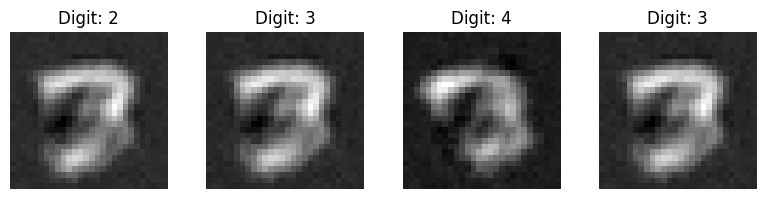

Epoch [42/100], i: 0, Loss: 0.1743
Epoch [42/100], i: 100, Loss: 0.1571
Epoch [42/100], i: 200, Loss: 0.1830
Epoch [42/100], i: 300, Loss: 0.1617
Epoch [42/100], i: 400, Loss: 0.1659
Epoch [43/100], i: 0, Loss: 0.1684
Epoch [43/100], i: 100, Loss: 0.1835
Epoch [43/100], i: 200, Loss: 0.1699
Epoch [43/100], i: 300, Loss: 0.1514
Epoch [43/100], i: 400, Loss: 0.1874
Epoch [44/100], i: 0, Loss: 0.1743
Epoch [44/100], i: 100, Loss: 0.1698
Epoch [44/100], i: 200, Loss: 0.1682
Epoch [44/100], i: 300, Loss: 0.1797
Epoch [44/100], i: 400, Loss: 0.1786
Epoch [45/100], i: 0, Loss: 0.1866
Epoch [45/100], i: 100, Loss: 0.1674
Epoch [45/100], i: 200, Loss: 0.1744
Epoch [45/100], i: 300, Loss: 0.1643
Epoch [45/100], i: 400, Loss: 0.1833
Epoch [46/100], i: 0, Loss: 0.1658
Epoch [46/100], i: 100, Loss: 0.1694
Epoch [46/100], i: 200, Loss: 0.1806
Epoch [46/100], i: 300, Loss: 0.1701
Epoch [46/100], i: 400, Loss: 0.1678


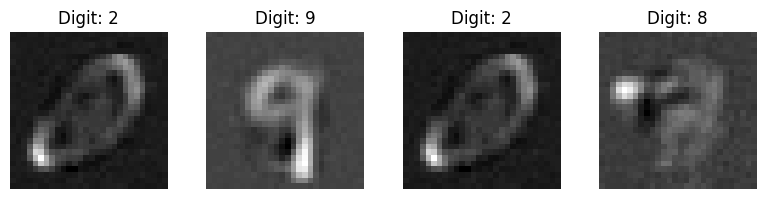

Epoch [47/100], i: 0, Loss: 0.1815
Epoch [47/100], i: 100, Loss: 0.1670
Epoch [47/100], i: 200, Loss: 0.1659
Epoch [47/100], i: 300, Loss: 0.1741
Epoch [47/100], i: 400, Loss: 0.1563
Epoch [48/100], i: 0, Loss: 0.1727
Epoch [48/100], i: 100, Loss: 0.1777
Epoch [48/100], i: 200, Loss: 0.1613
Epoch [48/100], i: 300, Loss: 0.1732
Epoch [48/100], i: 400, Loss: 0.1741
Epoch [49/100], i: 0, Loss: 0.1719
Epoch [49/100], i: 100, Loss: 0.1636
Epoch [49/100], i: 200, Loss: 0.1769
Epoch [49/100], i: 300, Loss: 0.1735
Epoch [49/100], i: 400, Loss: 0.1753
Epoch [50/100], i: 0, Loss: 0.1851
Epoch [50/100], i: 100, Loss: 0.1603
Epoch [50/100], i: 200, Loss: 0.1832
Epoch [50/100], i: 300, Loss: 0.1669
Epoch [50/100], i: 400, Loss: 0.1764
Epoch [51/100], i: 0, Loss: 0.1743
Epoch [51/100], i: 100, Loss: 0.1601
Epoch [51/100], i: 200, Loss: 0.1739
Epoch [51/100], i: 300, Loss: 0.1540
Epoch [51/100], i: 400, Loss: 0.1563


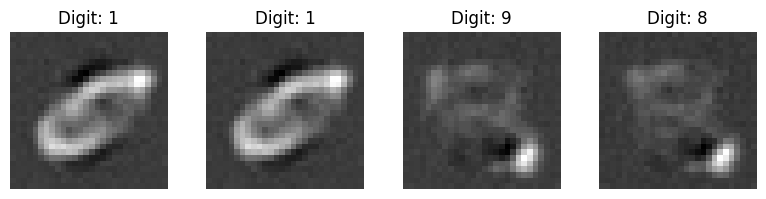

Epoch [52/100], i: 0, Loss: 0.1662
Epoch [52/100], i: 100, Loss: 0.1686
Epoch [52/100], i: 200, Loss: 0.1790
Epoch [52/100], i: 300, Loss: 0.1549
Epoch [52/100], i: 400, Loss: 0.1628
Epoch [53/100], i: 0, Loss: 0.1713
Epoch [53/100], i: 100, Loss: 0.1576
Epoch [53/100], i: 200, Loss: 0.1629
Epoch [53/100], i: 300, Loss: 0.1695
Epoch [53/100], i: 400, Loss: 0.1760
Epoch [54/100], i: 0, Loss: 0.1625
Epoch [54/100], i: 100, Loss: 0.1630
Epoch [54/100], i: 200, Loss: 0.1689
Epoch [54/100], i: 300, Loss: 0.1650
Epoch [54/100], i: 400, Loss: 0.1605
Epoch [55/100], i: 0, Loss: 0.1651
Epoch [55/100], i: 100, Loss: 0.1868
Epoch [55/100], i: 200, Loss: 0.1762
Epoch [55/100], i: 300, Loss: 0.1632
Epoch [55/100], i: 400, Loss: 0.1664
Epoch [56/100], i: 0, Loss: 0.1696
Epoch [56/100], i: 100, Loss: 0.1533
Epoch [56/100], i: 200, Loss: 0.1658
Epoch [56/100], i: 300, Loss: 0.1822
Epoch [56/100], i: 400, Loss: 0.1811


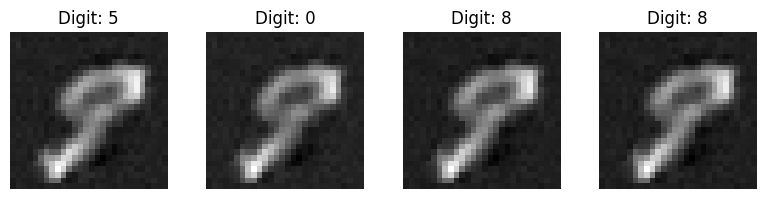

Epoch [57/100], i: 0, Loss: 0.1668
Epoch [57/100], i: 100, Loss: 0.1703
Epoch [57/100], i: 200, Loss: 0.1623
Epoch [57/100], i: 300, Loss: 0.1832
Epoch [57/100], i: 400, Loss: 0.1643
Epoch [58/100], i: 0, Loss: 0.1646
Epoch [58/100], i: 100, Loss: 0.1639
Epoch [58/100], i: 200, Loss: 0.1770
Epoch [58/100], i: 300, Loss: 0.1727
Epoch [58/100], i: 400, Loss: 0.1824
Epoch [59/100], i: 0, Loss: 0.1708
Epoch [59/100], i: 100, Loss: 0.1704
Epoch [59/100], i: 200, Loss: 0.1590
Epoch [59/100], i: 300, Loss: 0.1617
Epoch [59/100], i: 400, Loss: 0.1785
Epoch [60/100], i: 0, Loss: 0.1707
Epoch [60/100], i: 100, Loss: 0.1629
Epoch [60/100], i: 200, Loss: 0.1716
Epoch [60/100], i: 300, Loss: 0.1683
Epoch [60/100], i: 400, Loss: 0.1522
Epoch [61/100], i: 0, Loss: 0.1862
Epoch [61/100], i: 100, Loss: 0.1669
Epoch [61/100], i: 200, Loss: 0.1615
Epoch [61/100], i: 300, Loss: 0.1708
Epoch [61/100], i: 400, Loss: 0.1618


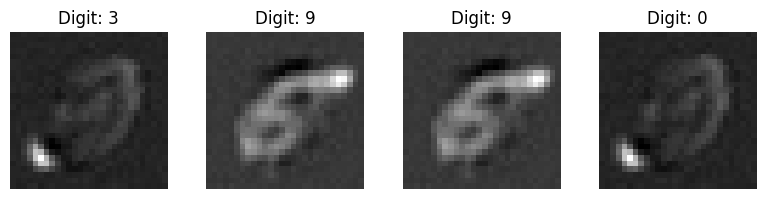

Epoch [62/100], i: 0, Loss: 0.1622
Epoch [62/100], i: 100, Loss: 0.1637
Epoch [62/100], i: 200, Loss: 0.1565
Epoch [62/100], i: 300, Loss: 0.1558
Epoch [62/100], i: 400, Loss: 0.1668
Epoch [63/100], i: 0, Loss: 0.1575
Epoch [63/100], i: 100, Loss: 0.1663
Epoch [63/100], i: 200, Loss: 0.1642
Epoch [63/100], i: 300, Loss: 0.1735
Epoch [63/100], i: 400, Loss: 0.1650
Epoch [64/100], i: 0, Loss: 0.1846
Epoch [64/100], i: 100, Loss: 0.1655
Epoch [64/100], i: 200, Loss: 0.1728
Epoch [64/100], i: 300, Loss: 0.1649
Epoch [64/100], i: 400, Loss: 0.1673
Epoch [65/100], i: 0, Loss: 0.1604
Epoch [65/100], i: 100, Loss: 0.1554
Epoch [65/100], i: 200, Loss: 0.1632
Epoch [65/100], i: 300, Loss: 0.1647
Epoch [65/100], i: 400, Loss: 0.1727
Epoch [66/100], i: 0, Loss: 0.1756
Epoch [66/100], i: 100, Loss: 0.1653
Epoch [66/100], i: 200, Loss: 0.1741
Epoch [66/100], i: 300, Loss: 0.1604
Epoch [66/100], i: 400, Loss: 0.1651


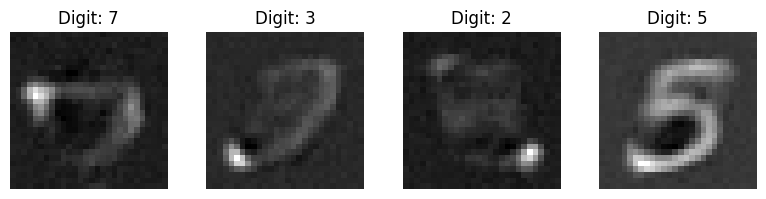

Epoch [67/100], i: 0, Loss: 0.1755
Epoch [67/100], i: 100, Loss: 0.1718
Epoch [67/100], i: 200, Loss: 0.1553
Epoch [67/100], i: 300, Loss: 0.1642
Epoch [67/100], i: 400, Loss: 0.1544
Epoch [68/100], i: 0, Loss: 0.1679
Epoch [68/100], i: 100, Loss: 0.1546
Epoch [68/100], i: 200, Loss: 0.1669
Epoch [68/100], i: 300, Loss: 0.1543
Epoch [68/100], i: 400, Loss: 0.1674
Epoch [69/100], i: 0, Loss: 0.1583
Epoch [69/100], i: 100, Loss: 0.1680
Epoch [69/100], i: 200, Loss: 0.1648
Epoch [69/100], i: 300, Loss: 0.1653
Epoch [69/100], i: 400, Loss: 0.1693
Epoch [70/100], i: 0, Loss: 0.1625
Epoch [70/100], i: 100, Loss: 0.1733
Epoch [70/100], i: 200, Loss: 0.1540
Epoch [70/100], i: 300, Loss: 0.1553
Epoch [70/100], i: 400, Loss: 0.1646
Epoch [71/100], i: 0, Loss: 0.1674
Epoch [71/100], i: 100, Loss: 0.1621
Epoch [71/100], i: 200, Loss: 0.1615
Epoch [71/100], i: 300, Loss: 0.1606
Epoch [71/100], i: 400, Loss: 0.1663


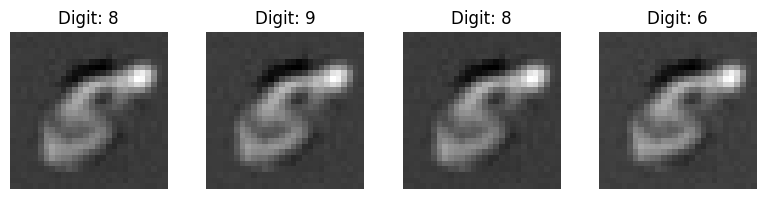

Epoch [72/100], i: 0, Loss: 0.1521
Epoch [72/100], i: 100, Loss: 0.1713
Epoch [72/100], i: 200, Loss: 0.1563
Epoch [72/100], i: 300, Loss: 0.1585
Epoch [72/100], i: 400, Loss: 0.1489
Epoch [73/100], i: 0, Loss: 0.1514
Epoch [73/100], i: 100, Loss: 0.1633
Epoch [73/100], i: 200, Loss: 0.1568
Epoch [73/100], i: 300, Loss: 0.1609
Epoch [73/100], i: 400, Loss: 0.1682
Epoch [74/100], i: 0, Loss: 0.1544
Epoch [74/100], i: 100, Loss: 0.1670
Epoch [74/100], i: 200, Loss: 0.1563
Epoch [74/100], i: 300, Loss: 0.1655
Epoch [74/100], i: 400, Loss: 0.1507
Epoch [75/100], i: 0, Loss: 0.1669
Epoch [75/100], i: 100, Loss: 0.1637
Epoch [75/100], i: 200, Loss: 0.1584
Epoch [75/100], i: 300, Loss: 0.1700
Epoch [75/100], i: 400, Loss: 0.1541
Epoch [76/100], i: 0, Loss: 0.1676
Epoch [76/100], i: 100, Loss: 0.1652
Epoch [76/100], i: 200, Loss: 0.1517
Epoch [76/100], i: 300, Loss: 0.1639
Epoch [76/100], i: 400, Loss: 0.1718


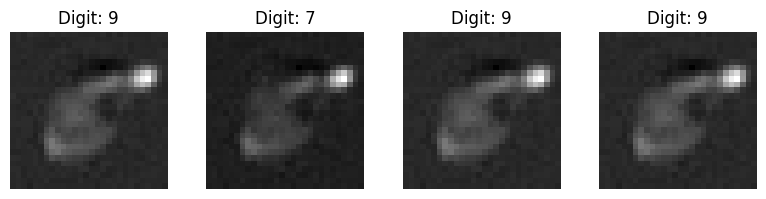

Epoch [77/100], i: 0, Loss: 0.1729
Epoch [77/100], i: 100, Loss: 0.1581
Epoch [77/100], i: 200, Loss: 0.1615
Epoch [77/100], i: 300, Loss: 0.1543
Epoch [77/100], i: 400, Loss: 0.1642
Epoch [78/100], i: 0, Loss: 0.1603
Epoch [78/100], i: 100, Loss: 0.1570
Epoch [78/100], i: 200, Loss: 0.1681
Epoch [78/100], i: 300, Loss: 0.1485
Epoch [78/100], i: 400, Loss: 0.1676
Epoch [79/100], i: 0, Loss: 0.1554
Epoch [79/100], i: 100, Loss: 0.1613
Epoch [79/100], i: 200, Loss: 0.1569
Epoch [79/100], i: 300, Loss: 0.1706
Epoch [79/100], i: 400, Loss: 0.1611
Epoch [80/100], i: 0, Loss: 0.1622
Epoch [80/100], i: 100, Loss: 0.1569
Epoch [80/100], i: 200, Loss: 0.1419
Epoch [80/100], i: 300, Loss: 0.1605
Epoch [80/100], i: 400, Loss: 0.1658
Epoch [81/100], i: 0, Loss: 0.1718
Epoch [81/100], i: 100, Loss: 0.1702
Epoch [81/100], i: 200, Loss: 0.1428
Epoch [81/100], i: 300, Loss: 0.1439
Epoch [81/100], i: 400, Loss: 0.1570


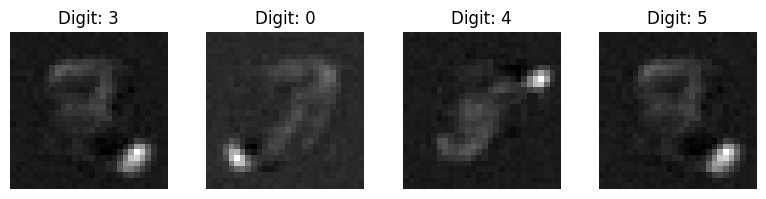

Epoch [82/100], i: 0, Loss: 0.1657
Epoch [82/100], i: 100, Loss: 0.1617
Epoch [82/100], i: 200, Loss: 0.1661
Epoch [82/100], i: 300, Loss: 0.1652
Epoch [82/100], i: 400, Loss: 0.1632
Epoch [83/100], i: 0, Loss: 0.1502
Epoch [83/100], i: 100, Loss: 0.1616
Epoch [83/100], i: 200, Loss: 0.1634
Epoch [83/100], i: 300, Loss: 0.1713
Epoch [83/100], i: 400, Loss: 0.1397
Epoch [84/100], i: 0, Loss: 0.1600
Epoch [84/100], i: 100, Loss: 0.1607
Epoch [84/100], i: 200, Loss: 0.1646
Epoch [84/100], i: 300, Loss: 0.1629
Epoch [84/100], i: 400, Loss: 0.1622
Epoch [85/100], i: 0, Loss: 0.1535
Epoch [85/100], i: 100, Loss: 0.1539
Epoch [85/100], i: 200, Loss: 0.1540
Epoch [85/100], i: 300, Loss: 0.1599
Epoch [85/100], i: 400, Loss: 0.1621
Epoch [86/100], i: 0, Loss: 0.1554
Epoch [86/100], i: 100, Loss: 0.1632
Epoch [86/100], i: 200, Loss: 0.1506
Epoch [86/100], i: 300, Loss: 0.1590
Epoch [86/100], i: 400, Loss: 0.1669


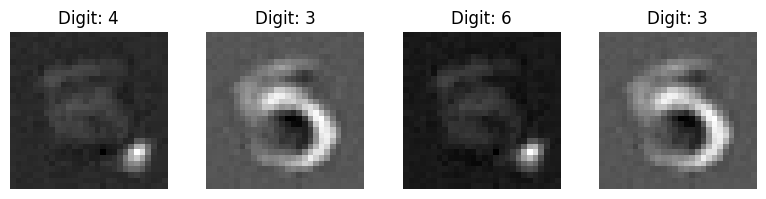

Epoch [87/100], i: 0, Loss: 0.1639
Epoch [87/100], i: 100, Loss: 0.1671
Epoch [87/100], i: 200, Loss: 0.1480
Epoch [87/100], i: 300, Loss: 0.1548
Epoch [87/100], i: 400, Loss: 0.1509
Epoch [88/100], i: 0, Loss: 0.1613
Epoch [88/100], i: 100, Loss: 0.1563
Epoch [88/100], i: 200, Loss: 0.1533
Epoch [88/100], i: 300, Loss: 0.1507
Epoch [88/100], i: 400, Loss: 0.1647
Epoch [89/100], i: 0, Loss: 0.1663
Epoch [89/100], i: 100, Loss: 0.1705
Epoch [89/100], i: 200, Loss: 0.1631
Epoch [89/100], i: 300, Loss: 0.1537
Epoch [89/100], i: 400, Loss: 0.1469
Epoch [90/100], i: 0, Loss: 0.1500
Epoch [90/100], i: 100, Loss: 0.1563
Epoch [90/100], i: 200, Loss: 0.1526
Epoch [90/100], i: 300, Loss: 0.1774
Epoch [90/100], i: 400, Loss: 0.1524
Epoch [91/100], i: 0, Loss: 0.1615
Epoch [91/100], i: 100, Loss: 0.1455
Epoch [91/100], i: 200, Loss: 0.1557
Epoch [91/100], i: 300, Loss: 0.1529
Epoch [91/100], i: 400, Loss: 0.1560


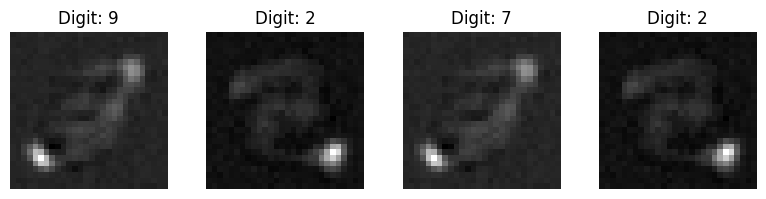

Epoch [92/100], i: 0, Loss: 0.1570
Epoch [92/100], i: 100, Loss: 0.1550
Epoch [92/100], i: 200, Loss: 0.1627
Epoch [92/100], i: 300, Loss: 0.1422
Epoch [92/100], i: 400, Loss: 0.1466
Epoch [93/100], i: 0, Loss: 0.1696
Epoch [93/100], i: 100, Loss: 0.1574
Epoch [93/100], i: 200, Loss: 0.1560
Epoch [93/100], i: 300, Loss: 0.1454
Epoch [93/100], i: 400, Loss: 0.1546
Epoch [94/100], i: 0, Loss: 0.1602
Epoch [94/100], i: 100, Loss: 0.1536
Epoch [94/100], i: 200, Loss: 0.1584
Epoch [94/100], i: 300, Loss: 0.1584
Epoch [94/100], i: 400, Loss: 0.1530
Epoch [95/100], i: 0, Loss: 0.1565
Epoch [95/100], i: 100, Loss: 0.1589
Epoch [95/100], i: 200, Loss: 0.1612
Epoch [95/100], i: 300, Loss: 0.1554
Epoch [95/100], i: 400, Loss: 0.1596
Epoch [96/100], i: 0, Loss: 0.1457
Epoch [96/100], i: 100, Loss: 0.1581
Epoch [96/100], i: 200, Loss: 0.1517
Epoch [96/100], i: 300, Loss: 0.1806
Epoch [96/100], i: 400, Loss: 0.1608


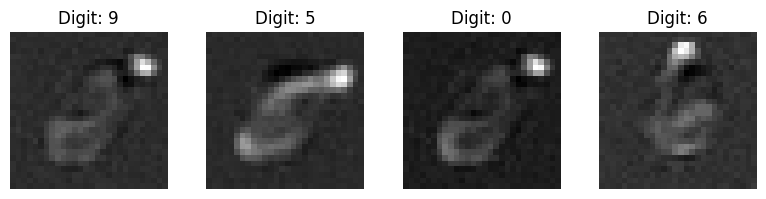

Epoch [97/100], i: 0, Loss: 0.1453
Epoch [97/100], i: 100, Loss: 0.1540
Epoch [97/100], i: 200, Loss: 0.1631
Epoch [97/100], i: 300, Loss: 0.1629
Epoch [97/100], i: 400, Loss: 0.1599
Epoch [98/100], i: 0, Loss: 0.1674
Epoch [98/100], i: 100, Loss: 0.1625
Epoch [98/100], i: 200, Loss: 0.1547
Epoch [98/100], i: 300, Loss: 0.1527
Epoch [98/100], i: 400, Loss: 0.1497
Epoch [99/100], i: 0, Loss: 0.1482
Epoch [99/100], i: 100, Loss: 0.1554
Epoch [99/100], i: 200, Loss: 0.1570
Epoch [99/100], i: 300, Loss: 0.1484
Epoch [99/100], i: 400, Loss: 0.1609
Epoch [100/100], i: 0, Loss: 0.1470
Epoch [100/100], i: 100, Loss: 0.1561
Epoch [100/100], i: 200, Loss: 0.1671
Epoch [100/100], i: 300, Loss: 0.1442
Epoch [100/100], i: 400, Loss: 0.1540


In [171]:
train()

## Need to see if labels are going correctly in sampler

as all generated images look similar

In [177]:
import random
import matplotlib.pyplot as plt
import torch

def sample_image_multiple(num_samples=1, noise_schedule=None):
    with torch.no_grad():
        # Generate initial noisy image with the maximum noise level
        max_noise_level = noise_schedule[-1]
        print("Max noise level: ", max_noise_level)
        x = torch.randn(num_samples, 1, 28, 28).to(device) * max_noise_level
        
        y = torch.randint(0, 10, (num_samples,)).to(device) # Generate random target labels
        print("Noisy image: ", x)
        print(x.shape)

        print("Labels: ",y)
        
        for t in range(len(noise_schedule) - 1, -1, -1):
            noise_level = noise_schedule[t]
            t_tensor = torch.tensor([t]).expand(num_samples).to(device)
            print(t_tensor)
            break
            
            predicted_noise = model(x, t_tensor, y)
            x = x - noise_level * predicted_noise
        
        generated_samples = x.cpu().squeeze().numpy()
    
    fig, axs = plt.subplots(1, num_samples, figsize=(num_samples * 2, 2))
    
    for i in range(num_samples):
        if num_samples == 1:
            axs.imshow(generated_samples[i], cmap="gray")
            axs.set_title(f"Digit: {y[i].item()}")
            axs.axis("off")
        else:
            axs[i].imshow(generated_samples[i], cmap="gray")
            axs[i].set_title(f"Digit: {y[i].item()}")
            axs[i].axis("off")
    
    plt.tight_layout()
    plt.show()

Max noise level:  1.0
Noisy image:  tensor([[[[ 0.1346, -0.1267, -0.5027,  ...,  0.5686, -0.6225, -2.4537],
          [ 2.4617,  1.6915, -0.6218,  ..., -0.8282,  1.1652,  1.7233],
          [ 0.8414, -0.8403, -0.2914,  ..., -2.2971, -0.2380,  1.1181],
          ...,
          [ 1.1990,  0.2188,  0.0166,  ...,  1.1618,  0.3616,  0.4354],
          [ 0.0140, -0.3325,  0.6279,  ...,  1.7964,  1.2232,  1.4794],
          [ 0.7046,  0.6569, -1.9082,  ...,  1.3182,  0.7613,  0.4809]]],


        [[[-1.0604,  0.7427,  0.4701,  ...,  0.6604,  1.6050,  0.5220],
          [-0.1144,  0.1707, -0.7938,  ...,  0.5138, -1.6641, -0.2201],
          [-1.1077, -1.4561,  1.1603,  ..., -0.6012, -0.8396, -0.4537],
          ...,
          [-0.7556,  0.5878, -0.2932,  ..., -1.1111, -0.3914, -0.3934],
          [-0.1293,  0.2367, -0.2379,  ..., -1.7496,  1.2557, -1.6219],
          [ 0.1739,  1.9021,  1.1233,  ..., -0.0262,  1.5457,  1.2049]]],


        [[[-1.8610,  0.6852, -1.7053,  ...,  0.0167, -0.3883, 

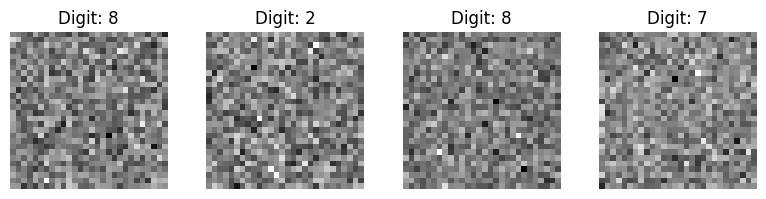

In [178]:
sample_image_multiple(num_samples=4, noise_schedule=noise_schedule_tensor.cpu().numpy())

### Instead of passing timestep (t) to the model that arbitrarily ranges from 0-1000, we should pass noise level which is a scaling factor (0-1)

In [186]:
def sample_image_multiple(num_samples=1, noise_schedule=None):
    with torch.no_grad():
        # Generate initial noisy image with the maximum noise level
        max_noise_level = noise_schedule[-1]
        print("Max noise level: ", max_noise_level)
        
        x = torch.randn(num_samples, 1, 28, 28).to(device) * max_noise_level
        y = torch.randint(0, 10, (num_samples,)).to(device)  # Generate random target labels
        
        print("Noisy image: ", x)
        print(x.shape)
        print("Labels: ", y)
        
        for t in range(len(noise_schedule) - 1, -1, -1):
            noise_level = noise_schedule[t]
            noise_level_tensor = torch.tensor(noise_level).expand(num_samples).to(device)
            
            print("Noise level tensor: ", noise_level_tensor)
            break
            
            predicted_noise = model(x, noise_level_tensor, y)
            x = x - noise_level * predicted_noise
        
        generated_samples = x.cpu().squeeze().numpy()
    
    fig, axs = plt.subplots(1, num_samples, figsize=(num_samples * 2, 2))
    
    for i in range(num_samples):
        if num_samples == 1:
            axs.imshow(generated_samples[i], cmap="gray")
            axs.set_title(f"Digit: {y[i].item()}")
            axs.axis("off")
        else:
            axs[i].imshow(generated_samples[i], cmap="gray")
            axs[i].set_title(f"Digit: {y[i].item()}")
            axs[i].axis("off")
    
    plt.tight_layout()
    plt.show()

Max noise level:  1.0
Noisy image:  tensor([[[[-1.2991,  1.0561, -0.7864,  ...,  1.5489,  0.3065,  0.3125],
          [-0.7763,  0.1506, -0.5908,  ...,  0.2787,  1.2024, -0.0674],
          [-0.0492, -0.1421, -0.1749,  ..., -1.0964, -2.2208, -1.7580],
          ...,
          [ 0.1709,  1.3238, -1.6821,  ...,  1.1283, -0.2611,  0.3231],
          [-0.2536,  0.1068,  0.0717,  ...,  0.1011, -0.3811,  0.2497],
          [ 0.9873, -1.0179,  0.1764,  ...,  2.3024,  0.0033, -0.7250]]],


        [[[ 1.3145, -0.8838,  0.0968,  ...,  1.0310, -0.0679, -1.0043],
          [-1.5747,  0.4056,  0.1273,  ...,  0.3993,  0.7289, -0.9282],
          [ 0.5179, -0.2683,  0.3545,  ..., -0.3301, -0.7914, -1.3860],
          ...,
          [ 0.4252,  0.9228, -0.5742,  ..., -1.0128,  1.7876, -0.3106],
          [ 0.9272,  2.7186, -0.4684,  ...,  0.9349,  2.0501, -1.9340],
          [ 1.0824, -0.9824, -0.3135,  ...,  0.2845, -0.0179, -0.4774]]],


        [[[-0.0091, -2.2141,  0.6321,  ...,  0.5362,  1.5703, 

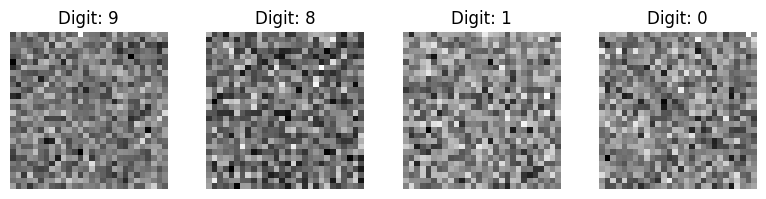

In [187]:
sample_image_multiple(num_samples=4, noise_schedule=noise_schedule_tensor.cpu().numpy())

### Let's train the network again with this change (from t to noise_level as input)

- Also reduce learning rate
- Run for 10x more epochs

In [188]:
def sample_image_multiple(num_samples=1, noise_schedule=None):
    with torch.no_grad():
        # Generate initial noisy image with the maximum noise level
        max_noise_level = noise_schedule[-1]
        
        
        x = torch.randn(num_samples, 1, 28, 28).to(device) * max_noise_level
        y = torch.randint(0, 10, (num_samples,)).to(device)  # Generate random target labels
        
        
        
        for t in range(len(noise_schedule) - 1, -1, -1):
            noise_level = noise_schedule[t]
            noise_level_tensor = torch.tensor(noise_level).expand(num_samples).to(device)
            
            
            predicted_noise = model(x, noise_level_tensor, y)
            x = x - noise_level * predicted_noise
        
        generated_samples = x.cpu().squeeze().numpy()
    
    fig, axs = plt.subplots(1, num_samples, figsize=(num_samples * 2, 2))
    
    for i in range(num_samples):
        if num_samples == 1:
            axs.imshow(generated_samples[i], cmap="gray")
            axs.set_title(f"Digit: {y[i].item()}")
            axs.axis("off")
        else:
            axs[i].imshow(generated_samples[i], cmap="gray")
            axs[i].set_title(f"Digit: {y[i].item()}")
            axs[i].axis("off")
    
    plt.tight_layout()
    plt.show()

In [189]:
def train():
    for epoch in range(1000):
        i = 0
        for data, labels in trainloader:
            ## data here is 128 batch size of each image and labels is 128 batch size of each label
            data, labels = data.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            # Randomly generate timesteps for each example in the batch
            t = torch.randint(0, num_steps, (data.shape[0],), device=device)
            
            # Retrieve the corresponding noise levels for each example in the batch
            noise_levels = noise_schedule_tensor[t]
            
            # generates random noise (mean 0, sd 1) tensor with the same shape as input data
            noise = torch.randn_like(data)
            
            # adds noise to input data based on timesteps. Scales noise by a factor calculated using the timesteps
            noisy_data = data + noise * noise_levels.view(-1, 1, 1, 1)
            
            predicted_noise = model(noisy_data, noise_levels, labels)
            loss = criterion(predicted_noise, noise)
            
            loss.backward()
            optimizer.step()
            
            if (i % 100) == 0:
                print(f"Epoch [{epoch+1}/1000], i: {i}, Loss: {loss.item():.4f}")
            
            i += 1
        
        if epoch % 5 == 0:
            sample_image_multiple(num_samples=4, noise_schedule=noise_schedule_tensor.cpu().numpy())

In [190]:
transform = transforms.Compose([transforms.ToTensor()])
trainset = datasets.MNIST('data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)
model = DiffusionModel(img_size=28, timesteps=1000, num_classes=10).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

Epoch [1/1000], i: 0, Loss: 8.0931
Epoch [1/1000], i: 100, Loss: 0.5818
Epoch [1/1000], i: 200, Loss: 0.5300
Epoch [1/1000], i: 300, Loss: 0.5238
Epoch [1/1000], i: 400, Loss: 0.4803


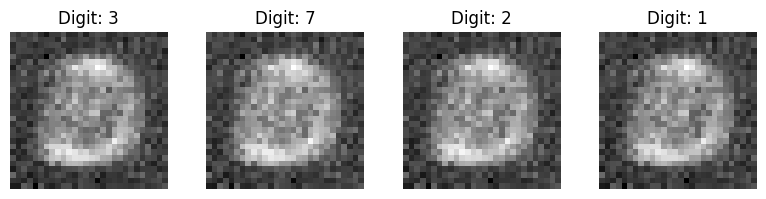

Epoch [2/1000], i: 0, Loss: 0.4648
Epoch [2/1000], i: 100, Loss: 0.4665
Epoch [2/1000], i: 200, Loss: 0.4633
Epoch [2/1000], i: 300, Loss: 0.4635
Epoch [2/1000], i: 400, Loss: 0.4532
Epoch [3/1000], i: 0, Loss: 0.4019
Epoch [3/1000], i: 100, Loss: 0.4290
Epoch [3/1000], i: 200, Loss: 0.3931
Epoch [3/1000], i: 300, Loss: 0.4287
Epoch [3/1000], i: 400, Loss: 0.4079
Epoch [4/1000], i: 0, Loss: 0.4096
Epoch [4/1000], i: 100, Loss: 0.3702
Epoch [4/1000], i: 200, Loss: 0.3898
Epoch [4/1000], i: 300, Loss: 0.3761
Epoch [4/1000], i: 400, Loss: 0.3485
Epoch [5/1000], i: 0, Loss: 0.3257
Epoch [5/1000], i: 100, Loss: 0.3543
Epoch [5/1000], i: 200, Loss: 0.3327
Epoch [5/1000], i: 300, Loss: 0.3447
Epoch [5/1000], i: 400, Loss: 0.3584
Epoch [6/1000], i: 0, Loss: 0.3111
Epoch [6/1000], i: 100, Loss: 0.3200
Epoch [6/1000], i: 200, Loss: 0.2973
Epoch [6/1000], i: 300, Loss: 0.2969
Epoch [6/1000], i: 400, Loss: 0.3028


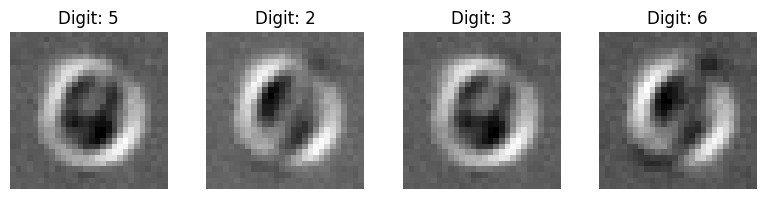

Epoch [7/1000], i: 0, Loss: 0.3205
Epoch [7/1000], i: 100, Loss: 0.2689
Epoch [7/1000], i: 200, Loss: 0.3220
Epoch [7/1000], i: 300, Loss: 0.2992
Epoch [7/1000], i: 400, Loss: 0.2963
Epoch [8/1000], i: 0, Loss: 0.2996
Epoch [8/1000], i: 100, Loss: 0.2729
Epoch [8/1000], i: 200, Loss: 0.2730
Epoch [8/1000], i: 300, Loss: 0.2800
Epoch [8/1000], i: 400, Loss: 0.2890
Epoch [9/1000], i: 0, Loss: 0.2654
Epoch [9/1000], i: 100, Loss: 0.2783
Epoch [9/1000], i: 200, Loss: 0.2826
Epoch [9/1000], i: 300, Loss: 0.2479
Epoch [9/1000], i: 400, Loss: 0.2904
Epoch [10/1000], i: 0, Loss: 0.2529
Epoch [10/1000], i: 100, Loss: 0.2512
Epoch [10/1000], i: 200, Loss: 0.2698
Epoch [10/1000], i: 300, Loss: 0.2556
Epoch [10/1000], i: 400, Loss: 0.2792
Epoch [11/1000], i: 0, Loss: 0.2408
Epoch [11/1000], i: 100, Loss: 0.2477
Epoch [11/1000], i: 200, Loss: 0.2464
Epoch [11/1000], i: 300, Loss: 0.2406
Epoch [11/1000], i: 400, Loss: 0.2469


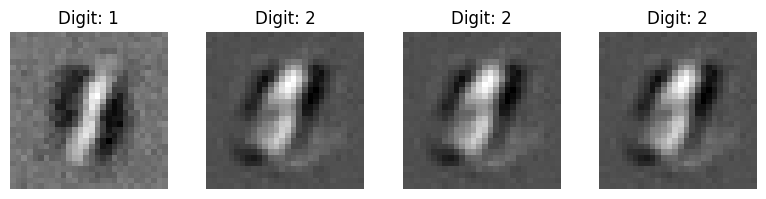

Epoch [12/1000], i: 0, Loss: 0.2491
Epoch [12/1000], i: 100, Loss: 0.2402
Epoch [12/1000], i: 200, Loss: 0.2365
Epoch [12/1000], i: 300, Loss: 0.2387
Epoch [12/1000], i: 400, Loss: 0.2294
Epoch [13/1000], i: 0, Loss: 0.2260
Epoch [13/1000], i: 100, Loss: 0.2456
Epoch [13/1000], i: 200, Loss: 0.2452
Epoch [13/1000], i: 300, Loss: 0.2464
Epoch [13/1000], i: 400, Loss: 0.2353
Epoch [14/1000], i: 0, Loss: 0.2254
Epoch [14/1000], i: 100, Loss: 0.2302
Epoch [14/1000], i: 200, Loss: 0.2342


KeyboardInterrupt: 

In [191]:
train()

## I suspect layernorm might be destroying class information as all generated images look the same (irrespective of label)

So let's remove it

In [192]:
class DiffusionModel(nn.Module):
    def __init__(self, img_size, timesteps, num_classes):
        super().__init__()
        self.img_size = img_size
        self.timesteps = timesteps
        self.num_classes = num_classes
        
        self.encoder = nn.Sequential(
            nn.Linear(img_size * img_size + 1 + num_classes, 1024),
            nn.ReLU()
        )
        
        self.residual_blocks = nn.ModuleList([
            nn.Sequential(
                nn.Linear(1024, 1024),
                nn.ReLU(),
                nn.Linear(1024, 1024),
                nn.ReLU()
            ) for _ in range(10)  # Number of residual blocks (changed to 10)
        ])
        
        self.decoder = nn.Sequential(
            nn.Linear(1024, img_size * img_size)
        )

    def forward(self, x, t, y):
        x_orig = x.view(-1, self.img_size * self.img_size)  # for residual connection
        t = t.unsqueeze(1)
        y = nn.functional.one_hot(y, num_classes=self.num_classes).float()
        
        x = torch.cat([x_orig, t, y], dim=1)
        x = self.encoder(x)
        
        for block in self.residual_blocks:
            residual = x
            x = block(x)
            x = x + residual  # Skip connection within residual blocks
        
        x = self.decoder(x)
        x = x + x_orig  # Residual connection from pixel values
        
        return x.view(-1, 1, self.img_size, self.img_size)

In [193]:
transform = transforms.Compose([transforms.ToTensor()])
trainset = datasets.MNIST('data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)
model = DiffusionModel(img_size=28, timesteps=1000, num_classes=10).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

Epoch [1/1000], i: 0, Loss: 0.6336
Epoch [1/1000], i: 100, Loss: 0.4516
Epoch [1/1000], i: 200, Loss: 0.4439
Epoch [1/1000], i: 300, Loss: 0.4686
Epoch [1/1000], i: 400, Loss: 0.4453


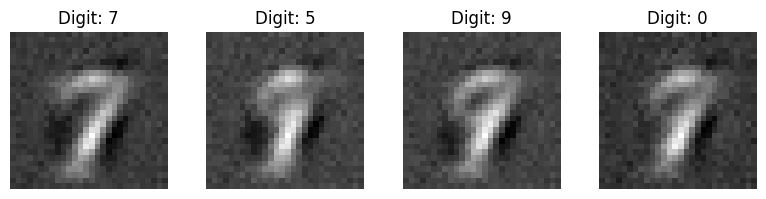

Epoch [2/1000], i: 0, Loss: 0.4281
Epoch [2/1000], i: 100, Loss: 0.4115
Epoch [2/1000], i: 200, Loss: 0.4218
Epoch [2/1000], i: 300, Loss: 0.4514
Epoch [2/1000], i: 400, Loss: 0.4261
Epoch [3/1000], i: 0, Loss: 0.3891
Epoch [3/1000], i: 100, Loss: 0.3671
Epoch [3/1000], i: 200, Loss: 0.3291
Epoch [3/1000], i: 300, Loss: 0.3696
Epoch [3/1000], i: 400, Loss: 0.3511
Epoch [4/1000], i: 0, Loss: 0.3666
Epoch [4/1000], i: 100, Loss: 0.3096
Epoch [4/1000], i: 200, Loss: 0.3124
Epoch [4/1000], i: 300, Loss: 0.3252
Epoch [4/1000], i: 400, Loss: 0.3293
Epoch [5/1000], i: 0, Loss: 0.3197
Epoch [5/1000], i: 100, Loss: 0.2963
Epoch [5/1000], i: 200, Loss: 0.3284
Epoch [5/1000], i: 300, Loss: 0.2691
Epoch [5/1000], i: 400, Loss: 0.3094
Epoch [6/1000], i: 0, Loss: 0.3131
Epoch [6/1000], i: 100, Loss: 0.2913
Epoch [6/1000], i: 200, Loss: 0.3073
Epoch [6/1000], i: 300, Loss: 0.3336
Epoch [6/1000], i: 400, Loss: 0.2824


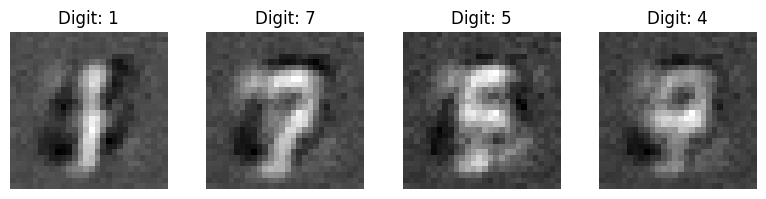

Epoch [7/1000], i: 0, Loss: 0.3037
Epoch [7/1000], i: 100, Loss: 0.2833
Epoch [7/1000], i: 200, Loss: 0.2821
Epoch [7/1000], i: 300, Loss: 0.2760
Epoch [7/1000], i: 400, Loss: 0.2866
Epoch [8/1000], i: 0, Loss: 0.2939
Epoch [8/1000], i: 100, Loss: 0.2931
Epoch [8/1000], i: 200, Loss: 0.2599
Epoch [8/1000], i: 300, Loss: 0.2648
Epoch [8/1000], i: 400, Loss: 0.2690
Epoch [9/1000], i: 0, Loss: 0.2590
Epoch [9/1000], i: 100, Loss: 0.2623
Epoch [9/1000], i: 200, Loss: 0.2652
Epoch [9/1000], i: 300, Loss: 0.2666
Epoch [9/1000], i: 400, Loss: 0.2806
Epoch [10/1000], i: 0, Loss: 0.2451
Epoch [10/1000], i: 100, Loss: 0.2351
Epoch [10/1000], i: 200, Loss: 0.2548
Epoch [10/1000], i: 300, Loss: 0.2454
Epoch [10/1000], i: 400, Loss: 0.2552
Epoch [11/1000], i: 0, Loss: 0.2452
Epoch [11/1000], i: 100, Loss: 0.2320
Epoch [11/1000], i: 200, Loss: 0.2343
Epoch [11/1000], i: 300, Loss: 0.2434
Epoch [11/1000], i: 400, Loss: 0.2367


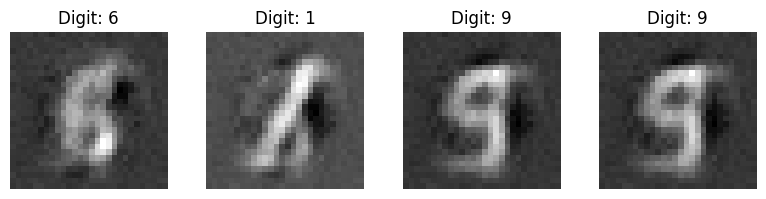

Epoch [12/1000], i: 0, Loss: 0.2480
Epoch [12/1000], i: 100, Loss: 0.2420
Epoch [12/1000], i: 200, Loss: 0.2305
Epoch [12/1000], i: 300, Loss: 0.2141
Epoch [12/1000], i: 400, Loss: 0.2373
Epoch [13/1000], i: 0, Loss: 0.2293
Epoch [13/1000], i: 100, Loss: 0.2238
Epoch [13/1000], i: 200, Loss: 0.2094
Epoch [13/1000], i: 300, Loss: 0.2332
Epoch [13/1000], i: 400, Loss: 0.2440
Epoch [14/1000], i: 0, Loss: 0.2275
Epoch [14/1000], i: 100, Loss: 0.2167
Epoch [14/1000], i: 200, Loss: 0.2356
Epoch [14/1000], i: 300, Loss: 0.2371
Epoch [14/1000], i: 400, Loss: 0.2236
Epoch [15/1000], i: 0, Loss: 0.2317
Epoch [15/1000], i: 100, Loss: 0.2209
Epoch [15/1000], i: 200, Loss: 0.2105
Epoch [15/1000], i: 300, Loss: 0.2311
Epoch [15/1000], i: 400, Loss: 0.2242
Epoch [16/1000], i: 0, Loss: 0.2159
Epoch [16/1000], i: 100, Loss: 0.2377
Epoch [16/1000], i: 200, Loss: 0.2022
Epoch [16/1000], i: 300, Loss: 0.2258
Epoch [16/1000], i: 400, Loss: 0.2294


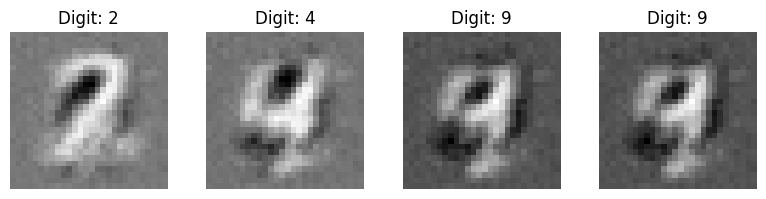

Epoch [17/1000], i: 0, Loss: 0.2092
Epoch [17/1000], i: 100, Loss: 0.2058
Epoch [17/1000], i: 200, Loss: 0.2166
Epoch [17/1000], i: 300, Loss: 0.2142
Epoch [17/1000], i: 400, Loss: 0.2052
Epoch [18/1000], i: 0, Loss: 0.2195
Epoch [18/1000], i: 100, Loss: 0.2215
Epoch [18/1000], i: 200, Loss: 0.2090
Epoch [18/1000], i: 300, Loss: 0.2209
Epoch [18/1000], i: 400, Loss: 0.2106
Epoch [19/1000], i: 0, Loss: 0.1999
Epoch [19/1000], i: 100, Loss: 0.2174
Epoch [19/1000], i: 200, Loss: 0.2033
Epoch [19/1000], i: 300, Loss: 0.2027
Epoch [19/1000], i: 400, Loss: 0.1956
Epoch [20/1000], i: 0, Loss: 0.2032
Epoch [20/1000], i: 100, Loss: 0.2141
Epoch [20/1000], i: 200, Loss: 0.2141
Epoch [20/1000], i: 300, Loss: 0.2139
Epoch [20/1000], i: 400, Loss: 0.2167
Epoch [21/1000], i: 0, Loss: 0.2152
Epoch [21/1000], i: 100, Loss: 0.2152
Epoch [21/1000], i: 200, Loss: 0.2132
Epoch [21/1000], i: 300, Loss: 0.1964
Epoch [21/1000], i: 400, Loss: 0.2001


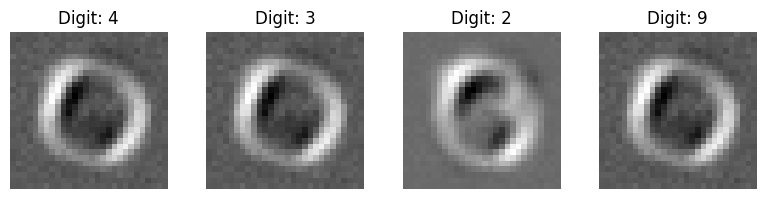

Epoch [22/1000], i: 0, Loss: 0.1878
Epoch [22/1000], i: 100, Loss: 0.2065
Epoch [22/1000], i: 200, Loss: 0.1956
Epoch [22/1000], i: 300, Loss: 0.2012
Epoch [22/1000], i: 400, Loss: 0.1984
Epoch [23/1000], i: 0, Loss: 0.2089
Epoch [23/1000], i: 100, Loss: 0.1949
Epoch [23/1000], i: 200, Loss: 0.1987
Epoch [23/1000], i: 300, Loss: 0.2082
Epoch [23/1000], i: 400, Loss: 0.1916
Epoch [24/1000], i: 0, Loss: 0.2075
Epoch [24/1000], i: 100, Loss: 0.2184
Epoch [24/1000], i: 200, Loss: 0.1973
Epoch [24/1000], i: 300, Loss: 0.1972
Epoch [24/1000], i: 400, Loss: 0.2035
Epoch [25/1000], i: 0, Loss: 0.2012
Epoch [25/1000], i: 100, Loss: 0.1917
Epoch [25/1000], i: 200, Loss: 0.2038
Epoch [25/1000], i: 300, Loss: 0.2191
Epoch [25/1000], i: 400, Loss: 0.1930
Epoch [26/1000], i: 0, Loss: 0.2101
Epoch [26/1000], i: 100, Loss: 0.1822
Epoch [26/1000], i: 200, Loss: 0.1887
Epoch [26/1000], i: 300, Loss: 0.1960
Epoch [26/1000], i: 400, Loss: 0.1961


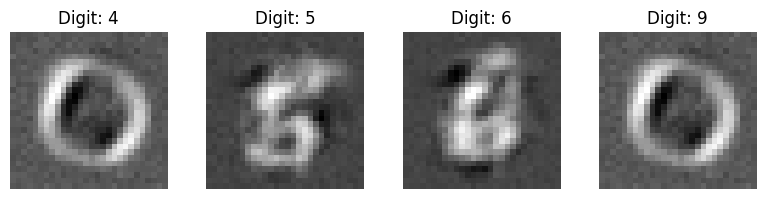

Epoch [27/1000], i: 0, Loss: 0.1933
Epoch [27/1000], i: 100, Loss: 0.1878
Epoch [27/1000], i: 200, Loss: 0.1984
Epoch [27/1000], i: 300, Loss: 0.2071
Epoch [27/1000], i: 400, Loss: 0.1881
Epoch [28/1000], i: 0, Loss: 0.1936
Epoch [28/1000], i: 100, Loss: 0.1940
Epoch [28/1000], i: 200, Loss: 0.1883
Epoch [28/1000], i: 300, Loss: 0.1940
Epoch [28/1000], i: 400, Loss: 0.1968
Epoch [29/1000], i: 0, Loss: 0.1827
Epoch [29/1000], i: 100, Loss: 0.1902
Epoch [29/1000], i: 200, Loss: 0.1811
Epoch [29/1000], i: 300, Loss: 0.1866
Epoch [29/1000], i: 400, Loss: 0.2089
Epoch [30/1000], i: 0, Loss: 0.1785
Epoch [30/1000], i: 100, Loss: 0.1823
Epoch [30/1000], i: 200, Loss: 0.1897
Epoch [30/1000], i: 300, Loss: 0.1857
Epoch [30/1000], i: 400, Loss: 0.1803
Epoch [31/1000], i: 0, Loss: 0.1807
Epoch [31/1000], i: 100, Loss: 0.1818
Epoch [31/1000], i: 200, Loss: 0.1697
Epoch [31/1000], i: 300, Loss: 0.1968
Epoch [31/1000], i: 400, Loss: 0.1781


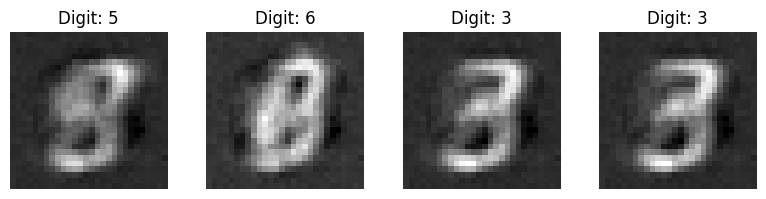

Epoch [32/1000], i: 0, Loss: 0.2012
Epoch [32/1000], i: 100, Loss: 0.1876
Epoch [32/1000], i: 200, Loss: 0.1827
Epoch [32/1000], i: 300, Loss: 0.1910
Epoch [32/1000], i: 400, Loss: 0.1930
Epoch [33/1000], i: 0, Loss: 0.1851
Epoch [33/1000], i: 100, Loss: 0.1740
Epoch [33/1000], i: 200, Loss: 0.1767
Epoch [33/1000], i: 300, Loss: 0.1779
Epoch [33/1000], i: 400, Loss: 0.1816
Epoch [34/1000], i: 0, Loss: 0.1914
Epoch [34/1000], i: 100, Loss: 0.1657
Epoch [34/1000], i: 200, Loss: 0.1894
Epoch [34/1000], i: 300, Loss: 0.1805
Epoch [34/1000], i: 400, Loss: 0.1785
Epoch [35/1000], i: 0, Loss: 0.1877
Epoch [35/1000], i: 100, Loss: 0.1847
Epoch [35/1000], i: 200, Loss: 0.1837
Epoch [35/1000], i: 300, Loss: 0.1825
Epoch [35/1000], i: 400, Loss: 0.1842
Epoch [36/1000], i: 0, Loss: 0.1947
Epoch [36/1000], i: 100, Loss: 0.1855
Epoch [36/1000], i: 200, Loss: 0.1841
Epoch [36/1000], i: 300, Loss: 0.1776
Epoch [36/1000], i: 400, Loss: 0.1839


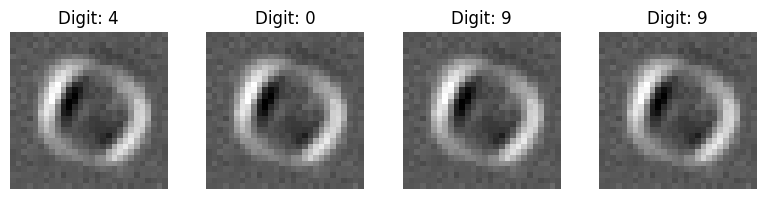

Epoch [37/1000], i: 0, Loss: 0.1756
Epoch [37/1000], i: 100, Loss: 0.1830
Epoch [37/1000], i: 200, Loss: 0.1811
Epoch [37/1000], i: 300, Loss: 0.1719
Epoch [37/1000], i: 400, Loss: 0.1848
Epoch [38/1000], i: 0, Loss: 0.1785
Epoch [38/1000], i: 100, Loss: 0.1749
Epoch [38/1000], i: 200, Loss: 0.1636
Epoch [38/1000], i: 300, Loss: 0.1863
Epoch [38/1000], i: 400, Loss: 0.1742
Epoch [39/1000], i: 0, Loss: 0.1676
Epoch [39/1000], i: 100, Loss: 0.1922
Epoch [39/1000], i: 200, Loss: 0.1899
Epoch [39/1000], i: 300, Loss: 0.1702
Epoch [39/1000], i: 400, Loss: 0.1878
Epoch [40/1000], i: 0, Loss: 0.1810
Epoch [40/1000], i: 100, Loss: 0.1828
Epoch [40/1000], i: 200, Loss: 0.1740
Epoch [40/1000], i: 300, Loss: 0.1691
Epoch [40/1000], i: 400, Loss: 0.1780
Epoch [41/1000], i: 0, Loss: 0.1944
Epoch [41/1000], i: 100, Loss: 0.1862
Epoch [41/1000], i: 200, Loss: 0.1522
Epoch [41/1000], i: 300, Loss: 0.1688
Epoch [41/1000], i: 400, Loss: 0.1716


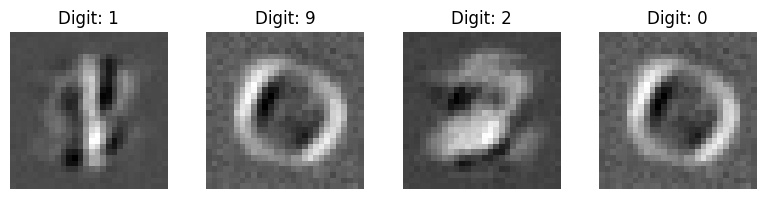

Epoch [42/1000], i: 0, Loss: 0.1708
Epoch [42/1000], i: 100, Loss: 0.1770
Epoch [42/1000], i: 200, Loss: 0.1821
Epoch [42/1000], i: 300, Loss: 0.1882
Epoch [42/1000], i: 400, Loss: 0.1721
Epoch [43/1000], i: 0, Loss: 0.1761
Epoch [43/1000], i: 100, Loss: 0.1883
Epoch [43/1000], i: 200, Loss: 0.1601
Epoch [43/1000], i: 300, Loss: 0.1650
Epoch [43/1000], i: 400, Loss: 0.1762
Epoch [44/1000], i: 0, Loss: 0.1632
Epoch [44/1000], i: 100, Loss: 0.1890
Epoch [44/1000], i: 200, Loss: 0.1770
Epoch [44/1000], i: 300, Loss: 0.1782
Epoch [44/1000], i: 400, Loss: 0.1960
Epoch [45/1000], i: 0, Loss: 0.1792
Epoch [45/1000], i: 100, Loss: 0.1762
Epoch [45/1000], i: 200, Loss: 0.1796
Epoch [45/1000], i: 300, Loss: 0.1744
Epoch [45/1000], i: 400, Loss: 0.1803
Epoch [46/1000], i: 0, Loss: 0.1637
Epoch [46/1000], i: 100, Loss: 0.1622
Epoch [46/1000], i: 200, Loss: 0.1697
Epoch [46/1000], i: 300, Loss: 0.1845
Epoch [46/1000], i: 400, Loss: 0.1734


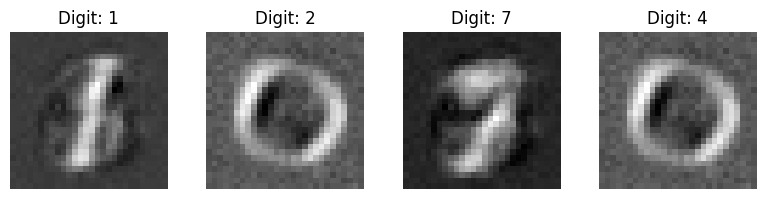

Epoch [47/1000], i: 0, Loss: 0.1772
Epoch [47/1000], i: 100, Loss: 0.1715
Epoch [47/1000], i: 200, Loss: 0.1831
Epoch [47/1000], i: 300, Loss: 0.1827
Epoch [47/1000], i: 400, Loss: 0.1651
Epoch [48/1000], i: 0, Loss: 0.1680
Epoch [48/1000], i: 100, Loss: 0.1695
Epoch [48/1000], i: 200, Loss: 0.1794
Epoch [48/1000], i: 300, Loss: 0.1766
Epoch [48/1000], i: 400, Loss: 0.1780
Epoch [49/1000], i: 0, Loss: 0.1775
Epoch [49/1000], i: 100, Loss: 0.1796
Epoch [49/1000], i: 200, Loss: 0.1628
Epoch [49/1000], i: 300, Loss: 0.1818
Epoch [49/1000], i: 400, Loss: 0.1727
Epoch [50/1000], i: 0, Loss: 0.1650
Epoch [50/1000], i: 100, Loss: 0.1868
Epoch [50/1000], i: 200, Loss: 0.1637
Epoch [50/1000], i: 300, Loss: 0.1894
Epoch [50/1000], i: 400, Loss: 0.1566
Epoch [51/1000], i: 0, Loss: 0.1702
Epoch [51/1000], i: 100, Loss: 0.1793
Epoch [51/1000], i: 200, Loss: 0.1718
Epoch [51/1000], i: 300, Loss: 0.1735
Epoch [51/1000], i: 400, Loss: 0.1515


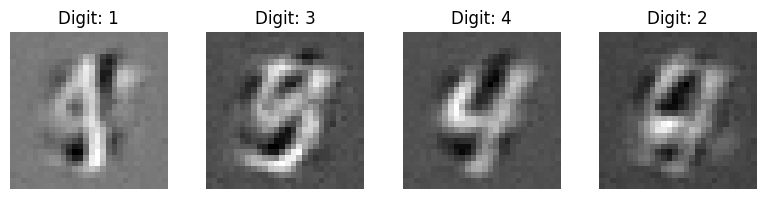

Epoch [52/1000], i: 0, Loss: 0.1886
Epoch [52/1000], i: 100, Loss: 0.1783
Epoch [52/1000], i: 200, Loss: 0.1760
Epoch [52/1000], i: 300, Loss: 0.1863
Epoch [52/1000], i: 400, Loss: 0.1726
Epoch [53/1000], i: 0, Loss: 0.1711
Epoch [53/1000], i: 100, Loss: 0.1636
Epoch [53/1000], i: 200, Loss: 0.1757
Epoch [53/1000], i: 300, Loss: 0.1782
Epoch [53/1000], i: 400, Loss: 0.1764
Epoch [54/1000], i: 0, Loss: 0.1829
Epoch [54/1000], i: 100, Loss: 0.1611
Epoch [54/1000], i: 200, Loss: 0.1710
Epoch [54/1000], i: 300, Loss: 0.1696
Epoch [54/1000], i: 400, Loss: 0.1686
Epoch [55/1000], i: 0, Loss: 0.1879
Epoch [55/1000], i: 100, Loss: 0.1704
Epoch [55/1000], i: 200, Loss: 0.1708
Epoch [55/1000], i: 300, Loss: 0.1615
Epoch [55/1000], i: 400, Loss: 0.1749
Epoch [56/1000], i: 0, Loss: 0.1830
Epoch [56/1000], i: 100, Loss: 0.1776
Epoch [56/1000], i: 200, Loss: 0.1767
Epoch [56/1000], i: 300, Loss: 0.1626
Epoch [56/1000], i: 400, Loss: 0.1684


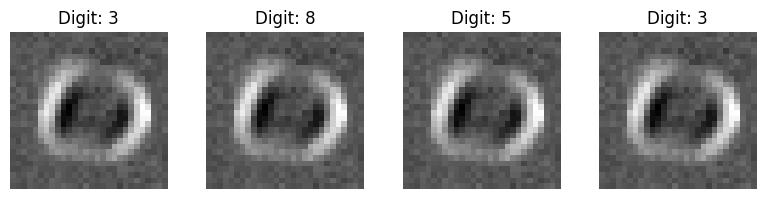

Epoch [57/1000], i: 0, Loss: 0.1822
Epoch [57/1000], i: 100, Loss: 0.1573
Epoch [57/1000], i: 200, Loss: 0.1610
Epoch [57/1000], i: 300, Loss: 0.1754
Epoch [57/1000], i: 400, Loss: 0.1556
Epoch [58/1000], i: 0, Loss: 0.1583
Epoch [58/1000], i: 100, Loss: 0.1757
Epoch [58/1000], i: 200, Loss: 0.1689
Epoch [58/1000], i: 300, Loss: 0.1690
Epoch [58/1000], i: 400, Loss: 0.1850
Epoch [59/1000], i: 0, Loss: 0.1661
Epoch [59/1000], i: 100, Loss: 0.1738
Epoch [59/1000], i: 200, Loss: 0.1567
Epoch [59/1000], i: 300, Loss: 0.1656
Epoch [59/1000], i: 400, Loss: 0.1658
Epoch [60/1000], i: 0, Loss: 0.1786
Epoch [60/1000], i: 100, Loss: 0.1493
Epoch [60/1000], i: 200, Loss: 0.1912
Epoch [60/1000], i: 300, Loss: 0.1607
Epoch [60/1000], i: 400, Loss: 0.1714
Epoch [61/1000], i: 0, Loss: 0.1591
Epoch [61/1000], i: 100, Loss: 0.1935
Epoch [61/1000], i: 200, Loss: 0.1738
Epoch [61/1000], i: 300, Loss: 0.1691
Epoch [61/1000], i: 400, Loss: 0.1682


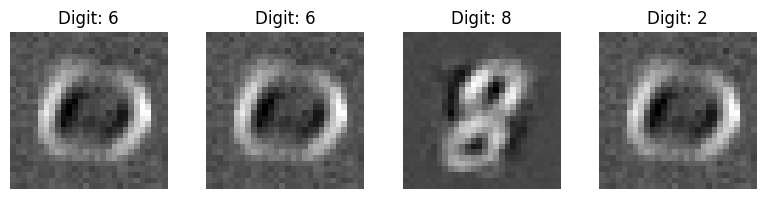

Epoch [62/1000], i: 0, Loss: 0.1671
Epoch [62/1000], i: 100, Loss: 0.1700
Epoch [62/1000], i: 200, Loss: 0.1671
Epoch [62/1000], i: 300, Loss: 0.1726
Epoch [62/1000], i: 400, Loss: 0.1792
Epoch [63/1000], i: 0, Loss: 0.1696
Epoch [63/1000], i: 100, Loss: 0.1836
Epoch [63/1000], i: 200, Loss: 0.1606
Epoch [63/1000], i: 300, Loss: 0.1849
Epoch [63/1000], i: 400, Loss: 0.1653
Epoch [64/1000], i: 0, Loss: 0.1762
Epoch [64/1000], i: 100, Loss: 0.1727
Epoch [64/1000], i: 200, Loss: 0.1603
Epoch [64/1000], i: 300, Loss: 0.1580
Epoch [64/1000], i: 400, Loss: 0.1754
Epoch [65/1000], i: 0, Loss: 0.1760
Epoch [65/1000], i: 100, Loss: 0.1784
Epoch [65/1000], i: 200, Loss: 0.1573
Epoch [65/1000], i: 300, Loss: 0.1645
Epoch [65/1000], i: 400, Loss: 0.1509
Epoch [66/1000], i: 0, Loss: 0.1777
Epoch [66/1000], i: 100, Loss: 0.1734
Epoch [66/1000], i: 200, Loss: 0.1697
Epoch [66/1000], i: 300, Loss: 0.1710
Epoch [66/1000], i: 400, Loss: 0.1792


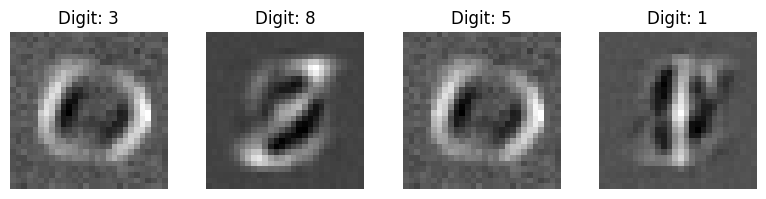

Epoch [67/1000], i: 0, Loss: 0.1473
Epoch [67/1000], i: 100, Loss: 0.1638
Epoch [67/1000], i: 200, Loss: 0.1752
Epoch [67/1000], i: 300, Loss: 0.1661
Epoch [67/1000], i: 400, Loss: 0.1641
Epoch [68/1000], i: 0, Loss: 0.1639
Epoch [68/1000], i: 100, Loss: 0.1708
Epoch [68/1000], i: 200, Loss: 0.1692
Epoch [68/1000], i: 300, Loss: 0.1779
Epoch [68/1000], i: 400, Loss: 0.1601
Epoch [69/1000], i: 0, Loss: 0.1629
Epoch [69/1000], i: 100, Loss: 0.1716
Epoch [69/1000], i: 200, Loss: 0.1634
Epoch [69/1000], i: 300, Loss: 0.1598
Epoch [69/1000], i: 400, Loss: 0.1632
Epoch [70/1000], i: 0, Loss: 0.1519
Epoch [70/1000], i: 100, Loss: 0.1642
Epoch [70/1000], i: 200, Loss: 0.1712
Epoch [70/1000], i: 300, Loss: 0.1650
Epoch [70/1000], i: 400, Loss: 0.1655
Epoch [71/1000], i: 0, Loss: 0.1710
Epoch [71/1000], i: 100, Loss: 0.1723
Epoch [71/1000], i: 200, Loss: 0.1652
Epoch [71/1000], i: 300, Loss: 0.1791
Epoch [71/1000], i: 400, Loss: 0.1654


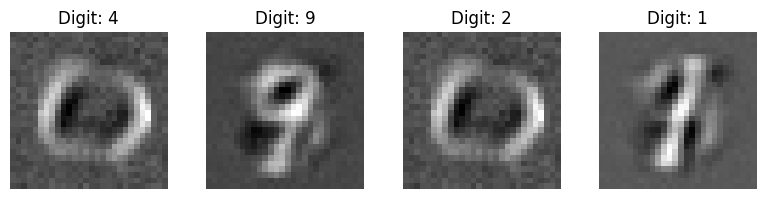

Epoch [72/1000], i: 0, Loss: 0.1698
Epoch [72/1000], i: 100, Loss: 0.1749
Epoch [72/1000], i: 200, Loss: 0.1621
Epoch [72/1000], i: 300, Loss: 0.1795
Epoch [72/1000], i: 400, Loss: 0.1782
Epoch [73/1000], i: 0, Loss: 0.1726
Epoch [73/1000], i: 100, Loss: 0.1637
Epoch [73/1000], i: 200, Loss: 0.1611
Epoch [73/1000], i: 300, Loss: 0.1766
Epoch [73/1000], i: 400, Loss: 0.1605
Epoch [74/1000], i: 0, Loss: 0.1674
Epoch [74/1000], i: 100, Loss: 0.1711
Epoch [74/1000], i: 200, Loss: 0.1589
Epoch [74/1000], i: 300, Loss: 0.1607
Epoch [74/1000], i: 400, Loss: 0.1602
Epoch [75/1000], i: 0, Loss: 0.1643
Epoch [75/1000], i: 100, Loss: 0.1536
Epoch [75/1000], i: 200, Loss: 0.1655
Epoch [75/1000], i: 300, Loss: 0.1781
Epoch [75/1000], i: 400, Loss: 0.1837
Epoch [76/1000], i: 0, Loss: 0.1693
Epoch [76/1000], i: 100, Loss: 0.1790
Epoch [76/1000], i: 200, Loss: 0.1631
Epoch [76/1000], i: 300, Loss: 0.1674
Epoch [76/1000], i: 400, Loss: 0.1656


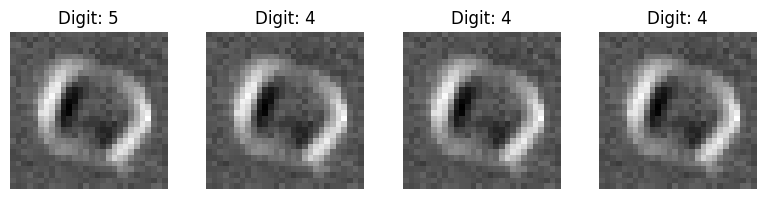

Epoch [77/1000], i: 0, Loss: 0.1717
Epoch [77/1000], i: 100, Loss: 0.1549
Epoch [77/1000], i: 200, Loss: 0.1623
Epoch [77/1000], i: 300, Loss: 0.1651
Epoch [77/1000], i: 400, Loss: 0.1711
Epoch [78/1000], i: 0, Loss: 0.1544
Epoch [78/1000], i: 100, Loss: 0.1664
Epoch [78/1000], i: 200, Loss: 0.1515
Epoch [78/1000], i: 300, Loss: 0.1618
Epoch [78/1000], i: 400, Loss: 0.1780
Epoch [79/1000], i: 0, Loss: 0.1630
Epoch [79/1000], i: 100, Loss: 0.1614
Epoch [79/1000], i: 200, Loss: 0.1648
Epoch [79/1000], i: 300, Loss: 0.1671
Epoch [79/1000], i: 400, Loss: 0.1610
Epoch [80/1000], i: 0, Loss: 0.1492
Epoch [80/1000], i: 100, Loss: 0.1698
Epoch [80/1000], i: 200, Loss: 0.1657
Epoch [80/1000], i: 300, Loss: 0.1559
Epoch [80/1000], i: 400, Loss: 0.1665
Epoch [81/1000], i: 0, Loss: 0.1633
Epoch [81/1000], i: 100, Loss: 0.1716
Epoch [81/1000], i: 200, Loss: 0.1596
Epoch [81/1000], i: 300, Loss: 0.1662
Epoch [81/1000], i: 400, Loss: 0.1941


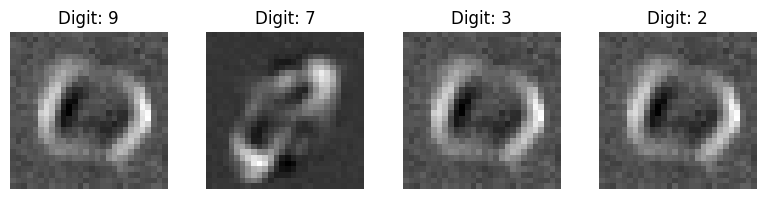

Epoch [82/1000], i: 0, Loss: 0.1519
Epoch [82/1000], i: 100, Loss: 0.1609
Epoch [82/1000], i: 200, Loss: 0.1603
Epoch [82/1000], i: 300, Loss: 0.1584
Epoch [82/1000], i: 400, Loss: 0.1594
Epoch [83/1000], i: 0, Loss: 0.1600
Epoch [83/1000], i: 100, Loss: 0.1714
Epoch [83/1000], i: 200, Loss: 0.1604
Epoch [83/1000], i: 300, Loss: 0.1580
Epoch [83/1000], i: 400, Loss: 0.1565
Epoch [84/1000], i: 0, Loss: 0.1684
Epoch [84/1000], i: 100, Loss: 0.1657
Epoch [84/1000], i: 200, Loss: 0.1533
Epoch [84/1000], i: 300, Loss: 0.1558
Epoch [84/1000], i: 400, Loss: 0.1719
Epoch [85/1000], i: 0, Loss: 0.1667
Epoch [85/1000], i: 100, Loss: 0.1707
Epoch [85/1000], i: 200, Loss: 0.1730
Epoch [85/1000], i: 300, Loss: 0.1639
Epoch [85/1000], i: 400, Loss: 0.1576
Epoch [86/1000], i: 0, Loss: 0.1645
Epoch [86/1000], i: 100, Loss: 0.1654
Epoch [86/1000], i: 200, Loss: 0.1649
Epoch [86/1000], i: 300, Loss: 0.1667
Epoch [86/1000], i: 400, Loss: 0.1694


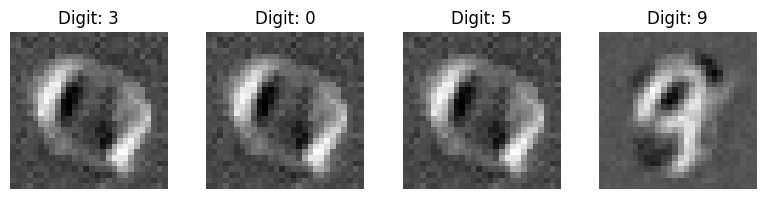

Epoch [87/1000], i: 0, Loss: 0.1531
Epoch [87/1000], i: 100, Loss: 0.1516
Epoch [87/1000], i: 200, Loss: 0.1514
Epoch [87/1000], i: 300, Loss: 0.1550
Epoch [87/1000], i: 400, Loss: 0.1712
Epoch [88/1000], i: 0, Loss: 0.1565
Epoch [88/1000], i: 100, Loss: 0.1685
Epoch [88/1000], i: 200, Loss: 0.1638
Epoch [88/1000], i: 300, Loss: 0.1653
Epoch [88/1000], i: 400, Loss: 0.1614
Epoch [89/1000], i: 0, Loss: 0.1833
Epoch [89/1000], i: 100, Loss: 0.1623
Epoch [89/1000], i: 200, Loss: 0.1711
Epoch [89/1000], i: 300, Loss: 0.1552
Epoch [89/1000], i: 400, Loss: 0.1639
Epoch [90/1000], i: 0, Loss: 0.1662
Epoch [90/1000], i: 100, Loss: 0.1552
Epoch [90/1000], i: 200, Loss: 0.1604
Epoch [90/1000], i: 300, Loss: 0.1681
Epoch [90/1000], i: 400, Loss: 0.1626
Epoch [91/1000], i: 0, Loss: 0.1688
Epoch [91/1000], i: 100, Loss: 0.1696
Epoch [91/1000], i: 200, Loss: 0.1645
Epoch [91/1000], i: 300, Loss: 0.1690
Epoch [91/1000], i: 400, Loss: 0.1658


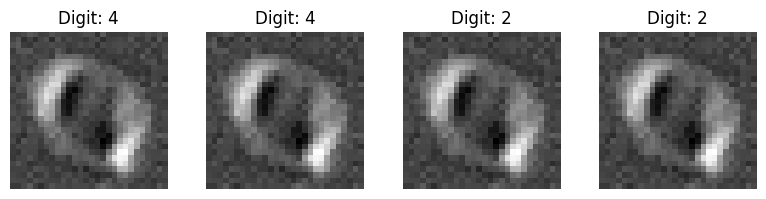

Epoch [92/1000], i: 0, Loss: 0.1618
Epoch [92/1000], i: 100, Loss: 0.1535
Epoch [92/1000], i: 200, Loss: 0.1595
Epoch [92/1000], i: 300, Loss: 0.1623
Epoch [92/1000], i: 400, Loss: 0.1659
Epoch [93/1000], i: 0, Loss: 0.1428
Epoch [93/1000], i: 100, Loss: 0.1496
Epoch [93/1000], i: 200, Loss: 0.1547
Epoch [93/1000], i: 300, Loss: 0.1595
Epoch [93/1000], i: 400, Loss: 0.1547
Epoch [94/1000], i: 0, Loss: 0.1570
Epoch [94/1000], i: 100, Loss: 0.1502
Epoch [94/1000], i: 200, Loss: 0.1612
Epoch [94/1000], i: 300, Loss: 0.1561
Epoch [94/1000], i: 400, Loss: 0.1710
Epoch [95/1000], i: 0, Loss: 0.1713
Epoch [95/1000], i: 100, Loss: 0.1526
Epoch [95/1000], i: 200, Loss: 0.1729
Epoch [95/1000], i: 300, Loss: 0.1572
Epoch [95/1000], i: 400, Loss: 0.1550
Epoch [96/1000], i: 0, Loss: 0.1601
Epoch [96/1000], i: 100, Loss: 0.1572
Epoch [96/1000], i: 200, Loss: 0.1538
Epoch [96/1000], i: 300, Loss: 0.1726
Epoch [96/1000], i: 400, Loss: 0.1551


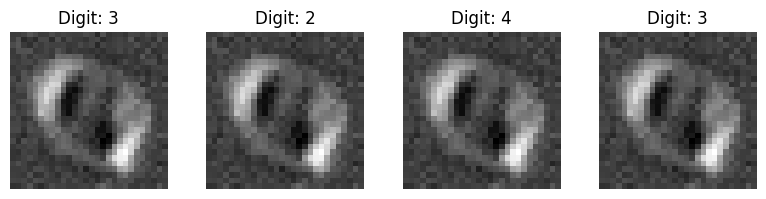

Epoch [97/1000], i: 0, Loss: 0.1453
Epoch [97/1000], i: 100, Loss: 0.1543
Epoch [97/1000], i: 200, Loss: 0.1466
Epoch [97/1000], i: 300, Loss: 0.1605
Epoch [97/1000], i: 400, Loss: 0.1640
Epoch [98/1000], i: 0, Loss: 0.1616
Epoch [98/1000], i: 100, Loss: 0.1672
Epoch [98/1000], i: 200, Loss: 0.1631
Epoch [98/1000], i: 300, Loss: 0.1478
Epoch [98/1000], i: 400, Loss: 0.1661
Epoch [99/1000], i: 0, Loss: 0.1567
Epoch [99/1000], i: 100, Loss: 0.1554
Epoch [99/1000], i: 200, Loss: 0.1604
Epoch [99/1000], i: 300, Loss: 0.1609
Epoch [99/1000], i: 400, Loss: 0.1615
Epoch [100/1000], i: 0, Loss: 0.1599
Epoch [100/1000], i: 100, Loss: 0.1466
Epoch [100/1000], i: 200, Loss: 0.1637
Epoch [100/1000], i: 300, Loss: 0.1658
Epoch [100/1000], i: 400, Loss: 0.1529
Epoch [101/1000], i: 0, Loss: 0.1771
Epoch [101/1000], i: 100, Loss: 0.1714
Epoch [101/1000], i: 200, Loss: 0.1437
Epoch [101/1000], i: 300, Loss: 0.1569
Epoch [101/1000], i: 400, Loss: 0.1665


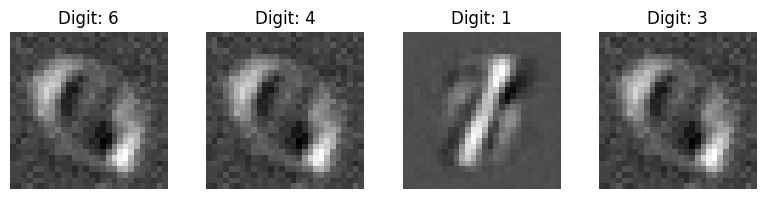

Epoch [102/1000], i: 0, Loss: 0.1662
Epoch [102/1000], i: 100, Loss: 0.1430
Epoch [102/1000], i: 200, Loss: 0.1678
Epoch [102/1000], i: 300, Loss: 0.1568
Epoch [102/1000], i: 400, Loss: 0.1411
Epoch [103/1000], i: 0, Loss: 0.1525
Epoch [103/1000], i: 100, Loss: 0.1618
Epoch [103/1000], i: 200, Loss: 0.1770
Epoch [103/1000], i: 300, Loss: 0.1618
Epoch [103/1000], i: 400, Loss: 0.1581
Epoch [104/1000], i: 0, Loss: 0.1557
Epoch [104/1000], i: 100, Loss: 0.1720
Epoch [104/1000], i: 200, Loss: 0.1792
Epoch [104/1000], i: 300, Loss: 0.1482
Epoch [104/1000], i: 400, Loss: 0.1709
Epoch [105/1000], i: 0, Loss: 0.1610
Epoch [105/1000], i: 100, Loss: 0.1607
Epoch [105/1000], i: 200, Loss: 0.1522
Epoch [105/1000], i: 300, Loss: 0.1661
Epoch [105/1000], i: 400, Loss: 0.1700
Epoch [106/1000], i: 0, Loss: 0.1605
Epoch [106/1000], i: 100, Loss: 0.1486
Epoch [106/1000], i: 200, Loss: 0.1609
Epoch [106/1000], i: 300, Loss: 0.1491
Epoch [106/1000], i: 400, Loss: 0.1574


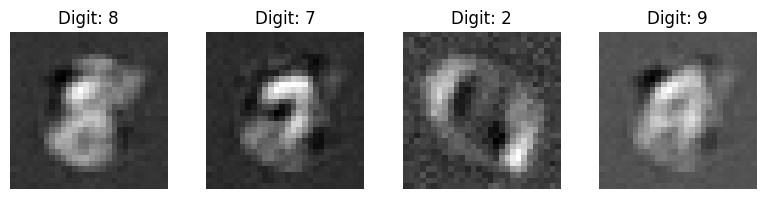

Epoch [107/1000], i: 0, Loss: 0.1583
Epoch [107/1000], i: 100, Loss: 0.1473
Epoch [107/1000], i: 200, Loss: 0.1511
Epoch [107/1000], i: 300, Loss: 0.1503
Epoch [107/1000], i: 400, Loss: 0.1503
Epoch [108/1000], i: 0, Loss: 0.1570
Epoch [108/1000], i: 100, Loss: 0.1627
Epoch [108/1000], i: 200, Loss: 0.1515
Epoch [108/1000], i: 300, Loss: 0.1529
Epoch [108/1000], i: 400, Loss: 0.1512
Epoch [109/1000], i: 0, Loss: 0.1640
Epoch [109/1000], i: 100, Loss: 0.1592
Epoch [109/1000], i: 200, Loss: 0.1606
Epoch [109/1000], i: 300, Loss: 0.1531
Epoch [109/1000], i: 400, Loss: 0.1578
Epoch [110/1000], i: 0, Loss: 0.1582
Epoch [110/1000], i: 100, Loss: 0.1567
Epoch [110/1000], i: 200, Loss: 0.1539
Epoch [110/1000], i: 300, Loss: 0.1433
Epoch [110/1000], i: 400, Loss: 0.1653
Epoch [111/1000], i: 0, Loss: 0.1680
Epoch [111/1000], i: 100, Loss: 0.1434
Epoch [111/1000], i: 200, Loss: 0.1661
Epoch [111/1000], i: 300, Loss: 0.1519
Epoch [111/1000], i: 400, Loss: 0.1630


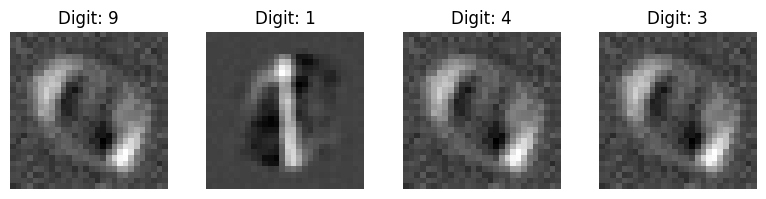

Epoch [112/1000], i: 0, Loss: 0.1652
Epoch [112/1000], i: 100, Loss: 0.1699
Epoch [112/1000], i: 200, Loss: 0.1528
Epoch [112/1000], i: 300, Loss: 0.1431
Epoch [112/1000], i: 400, Loss: 0.1529
Epoch [113/1000], i: 0, Loss: 0.1591
Epoch [113/1000], i: 100, Loss: 0.1609
Epoch [113/1000], i: 200, Loss: 0.1636
Epoch [113/1000], i: 300, Loss: 0.1521
Epoch [113/1000], i: 400, Loss: 0.1720
Epoch [114/1000], i: 0, Loss: 0.1637
Epoch [114/1000], i: 100, Loss: 0.1539
Epoch [114/1000], i: 200, Loss: 0.1550
Epoch [114/1000], i: 300, Loss: 0.1564
Epoch [114/1000], i: 400, Loss: 0.1427
Epoch [115/1000], i: 0, Loss: 0.1639
Epoch [115/1000], i: 100, Loss: 0.1458
Epoch [115/1000], i: 200, Loss: 0.1473
Epoch [115/1000], i: 300, Loss: 0.1621
Epoch [115/1000], i: 400, Loss: 0.1606
Epoch [116/1000], i: 0, Loss: 0.1531
Epoch [116/1000], i: 100, Loss: 0.1516
Epoch [116/1000], i: 200, Loss: 0.1584
Epoch [116/1000], i: 300, Loss: 0.1633
Epoch [116/1000], i: 400, Loss: 0.1529


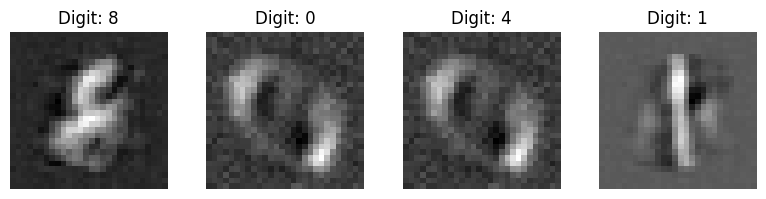

Epoch [117/1000], i: 0, Loss: 0.1452
Epoch [117/1000], i: 100, Loss: 0.1562
Epoch [117/1000], i: 200, Loss: 0.1573
Epoch [117/1000], i: 300, Loss: 0.1683
Epoch [117/1000], i: 400, Loss: 0.1501
Epoch [118/1000], i: 0, Loss: 0.1503
Epoch [118/1000], i: 100, Loss: 0.1668
Epoch [118/1000], i: 200, Loss: 0.1625
Epoch [118/1000], i: 300, Loss: 0.1525
Epoch [118/1000], i: 400, Loss: 0.1672
Epoch [119/1000], i: 0, Loss: 0.1514
Epoch [119/1000], i: 100, Loss: 0.1674
Epoch [119/1000], i: 200, Loss: 0.1536
Epoch [119/1000], i: 300, Loss: 0.1812
Epoch [119/1000], i: 400, Loss: 0.1694
Epoch [120/1000], i: 0, Loss: 0.1616
Epoch [120/1000], i: 100, Loss: 0.1704
Epoch [120/1000], i: 200, Loss: 0.1495
Epoch [120/1000], i: 300, Loss: 0.1605
Epoch [120/1000], i: 400, Loss: 0.1558
Epoch [121/1000], i: 0, Loss: 0.1522
Epoch [121/1000], i: 100, Loss: 0.1593
Epoch [121/1000], i: 200, Loss: 0.1430
Epoch [121/1000], i: 300, Loss: 0.1631
Epoch [121/1000], i: 400, Loss: 0.1388


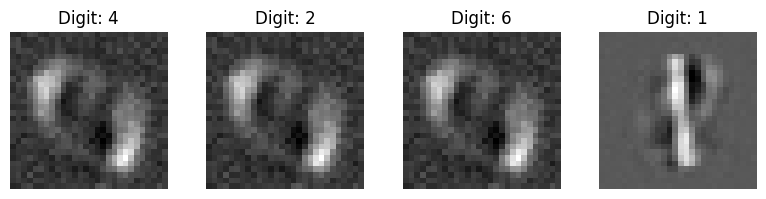

Epoch [122/1000], i: 0, Loss: 0.1573
Epoch [122/1000], i: 100, Loss: 0.1648
Epoch [122/1000], i: 200, Loss: 0.1521
Epoch [122/1000], i: 300, Loss: 0.1510
Epoch [122/1000], i: 400, Loss: 0.1435
Epoch [123/1000], i: 0, Loss: 0.1632
Epoch [123/1000], i: 100, Loss: 0.1638
Epoch [123/1000], i: 200, Loss: 0.1539
Epoch [123/1000], i: 300, Loss: 0.1474
Epoch [123/1000], i: 400, Loss: 0.1600
Epoch [124/1000], i: 0, Loss: 0.1531
Epoch [124/1000], i: 100, Loss: 0.1469
Epoch [124/1000], i: 200, Loss: 0.1525
Epoch [124/1000], i: 300, Loss: 0.1612
Epoch [124/1000], i: 400, Loss: 0.1349
Epoch [125/1000], i: 0, Loss: 0.1558
Epoch [125/1000], i: 100, Loss: 0.1464
Epoch [125/1000], i: 200, Loss: 0.1508
Epoch [125/1000], i: 300, Loss: 0.1471
Epoch [125/1000], i: 400, Loss: 0.1490
Epoch [126/1000], i: 0, Loss: 0.1558
Epoch [126/1000], i: 100, Loss: 0.1500
Epoch [126/1000], i: 200, Loss: 0.1574
Epoch [126/1000], i: 300, Loss: 0.1518
Epoch [126/1000], i: 400, Loss: 0.1483


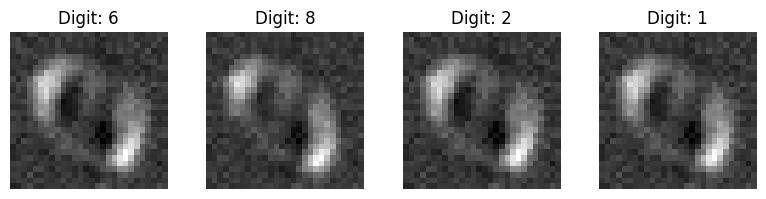

Epoch [127/1000], i: 0, Loss: 0.1651
Epoch [127/1000], i: 100, Loss: 0.1401
Epoch [127/1000], i: 200, Loss: 0.1536
Epoch [127/1000], i: 300, Loss: 0.1385
Epoch [127/1000], i: 400, Loss: 0.1634
Epoch [128/1000], i: 0, Loss: 0.1467
Epoch [128/1000], i: 100, Loss: 0.1441
Epoch [128/1000], i: 200, Loss: 0.1667
Epoch [128/1000], i: 300, Loss: 0.1573
Epoch [128/1000], i: 400, Loss: 0.1483
Epoch [129/1000], i: 0, Loss: 0.1522
Epoch [129/1000], i: 100, Loss: 0.1716
Epoch [129/1000], i: 200, Loss: 0.1447
Epoch [129/1000], i: 300, Loss: 0.1401
Epoch [129/1000], i: 400, Loss: 0.1460
Epoch [130/1000], i: 0, Loss: 0.1622
Epoch [130/1000], i: 100, Loss: 0.1531
Epoch [130/1000], i: 200, Loss: 0.1665
Epoch [130/1000], i: 300, Loss: 0.1457
Epoch [130/1000], i: 400, Loss: 0.1454
Epoch [131/1000], i: 0, Loss: 0.1509
Epoch [131/1000], i: 100, Loss: 0.1475
Epoch [131/1000], i: 200, Loss: 0.1574
Epoch [131/1000], i: 300, Loss: 0.1557
Epoch [131/1000], i: 400, Loss: 0.1538


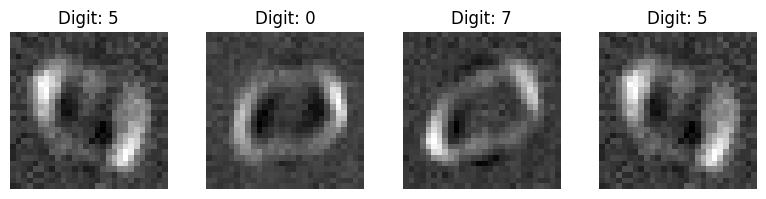

Epoch [132/1000], i: 0, Loss: 0.1484
Epoch [132/1000], i: 100, Loss: 0.1464
Epoch [132/1000], i: 200, Loss: 0.1548
Epoch [132/1000], i: 300, Loss: 0.1537
Epoch [132/1000], i: 400, Loss: 0.1446
Epoch [133/1000], i: 0, Loss: 0.1458
Epoch [133/1000], i: 100, Loss: 0.1611
Epoch [133/1000], i: 200, Loss: 0.1510
Epoch [133/1000], i: 300, Loss: 0.1595
Epoch [133/1000], i: 400, Loss: 0.1487
Epoch [134/1000], i: 0, Loss: 0.1730
Epoch [134/1000], i: 100, Loss: 0.1484
Epoch [134/1000], i: 200, Loss: 0.1548
Epoch [134/1000], i: 300, Loss: 0.1510
Epoch [134/1000], i: 400, Loss: 0.1471
Epoch [135/1000], i: 0, Loss: 0.1507
Epoch [135/1000], i: 100, Loss: 0.1618
Epoch [135/1000], i: 200, Loss: 0.1542
Epoch [135/1000], i: 300, Loss: 0.1522
Epoch [135/1000], i: 400, Loss: 0.1434
Epoch [136/1000], i: 0, Loss: 0.1454
Epoch [136/1000], i: 100, Loss: 0.1404
Epoch [136/1000], i: 200, Loss: 0.1597
Epoch [136/1000], i: 300, Loss: 0.1441
Epoch [136/1000], i: 400, Loss: 0.1503


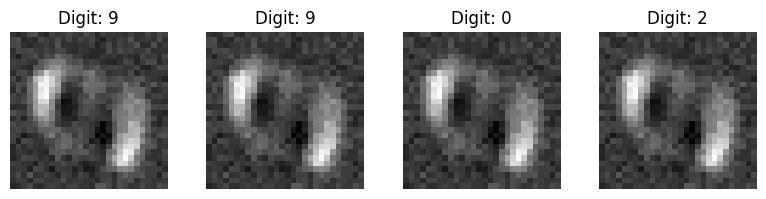

Epoch [137/1000], i: 0, Loss: 0.1587
Epoch [137/1000], i: 100, Loss: 0.1590
Epoch [137/1000], i: 200, Loss: 0.1427
Epoch [137/1000], i: 300, Loss: 0.1636


KeyboardInterrupt: 

In [194]:
train()

## let's try to make the network double in size

In [195]:
class DiffusionModel(nn.Module):
    def __init__(self, img_size, timesteps, num_classes):
        super().__init__()
        self.img_size = img_size
        self.timesteps = timesteps
        self.num_classes = num_classes
        
        self.encoder = nn.Sequential(
            nn.Linear(img_size * img_size + 1 + num_classes, 1024),
            nn.ReLU()
        )
        
        self.residual_blocks = nn.ModuleList([
            nn.Sequential(
                nn.Linear(1024, 1024),
                nn.ReLU(),
                nn.Linear(1024, 1024),
                nn.ReLU()
            ) for _ in range(20)  # Number of residual blocks (changed to 10)
        ])
        
        self.decoder = nn.Sequential(
            nn.Linear(1024, img_size * img_size)
        )

    def forward(self, x, t, y):
        x_orig = x.view(-1, self.img_size * self.img_size)  # for residual connection
        t = t.unsqueeze(1)
        y = nn.functional.one_hot(y, num_classes=self.num_classes).float()
        
        x = torch.cat([x_orig, t, y], dim=1)
        x = self.encoder(x)
        
        for block in self.residual_blocks:
            residual = x
            x = block(x)
            x = x + residual  # Skip connection within residual blocks
        
        x = self.decoder(x)
        x = x + x_orig  # Residual connection from pixel values
        
        return x.view(-1, 1, self.img_size, self.img_size)

In [196]:
transform = transforms.Compose([transforms.ToTensor()])
trainset = datasets.MNIST('data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)
model = DiffusionModel(img_size=28, timesteps=1000, num_classes=10).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

Epoch [1/1000], i: 0, Loss: 1.1043
Epoch [1/1000], i: 100, Loss: 0.5016
Epoch [1/1000], i: 200, Loss: 0.4713
Epoch [1/1000], i: 300, Loss: 0.4379
Epoch [1/1000], i: 400, Loss: 0.4018


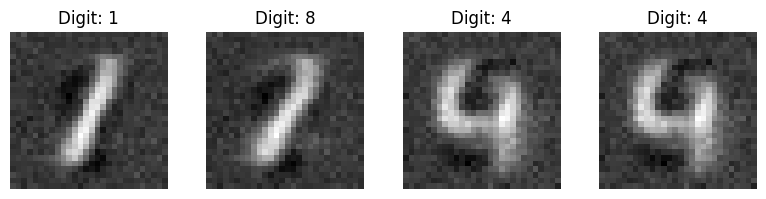

Epoch [2/1000], i: 0, Loss: 0.4471
Epoch [2/1000], i: 100, Loss: 0.4010
Epoch [2/1000], i: 200, Loss: 0.4443
Epoch [2/1000], i: 300, Loss: 0.4281
Epoch [2/1000], i: 400, Loss: 0.4307
Epoch [3/1000], i: 0, Loss: 0.3869
Epoch [3/1000], i: 100, Loss: 0.3881
Epoch [3/1000], i: 200, Loss: 0.4154
Epoch [3/1000], i: 300, Loss: 0.3750
Epoch [3/1000], i: 400, Loss: 0.3979
Epoch [4/1000], i: 0, Loss: 0.3475
Epoch [4/1000], i: 100, Loss: 0.3480
Epoch [4/1000], i: 200, Loss: 0.3573
Epoch [4/1000], i: 300, Loss: 0.3293
Epoch [4/1000], i: 400, Loss: 0.3410
Epoch [5/1000], i: 0, Loss: 0.3715
Epoch [5/1000], i: 100, Loss: 0.3084
Epoch [5/1000], i: 200, Loss: 0.3330
Epoch [5/1000], i: 300, Loss: 0.3113
Epoch [5/1000], i: 400, Loss: 0.3015
Epoch [6/1000], i: 0, Loss: 0.3110
Epoch [6/1000], i: 100, Loss: 0.3285
Epoch [6/1000], i: 200, Loss: 0.2902
Epoch [6/1000], i: 300, Loss: 0.3253
Epoch [6/1000], i: 400, Loss: 0.2662


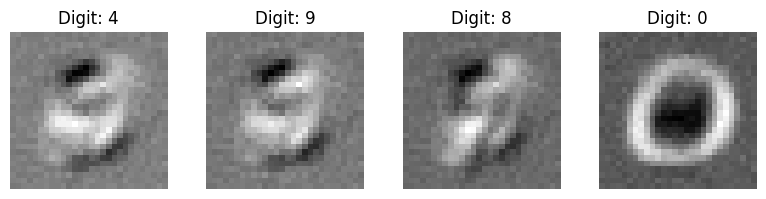

Epoch [7/1000], i: 0, Loss: 0.3077
Epoch [7/1000], i: 100, Loss: 0.3241
Epoch [7/1000], i: 200, Loss: 0.2911
Epoch [7/1000], i: 300, Loss: 0.2555
Epoch [7/1000], i: 400, Loss: 0.2749
Epoch [8/1000], i: 0, Loss: 0.3012
Epoch [8/1000], i: 100, Loss: 0.2773
Epoch [8/1000], i: 200, Loss: 0.2774
Epoch [8/1000], i: 300, Loss: 0.2660
Epoch [8/1000], i: 400, Loss: 0.2636
Epoch [9/1000], i: 0, Loss: 0.2672
Epoch [9/1000], i: 100, Loss: 0.2482
Epoch [9/1000], i: 200, Loss: 0.2922
Epoch [9/1000], i: 300, Loss: 0.2713
Epoch [9/1000], i: 400, Loss: 0.2762
Epoch [10/1000], i: 0, Loss: 0.2429
Epoch [10/1000], i: 100, Loss: 0.2389
Epoch [10/1000], i: 200, Loss: 0.2634
Epoch [10/1000], i: 300, Loss: 0.2574
Epoch [10/1000], i: 400, Loss: 0.2455
Epoch [11/1000], i: 0, Loss: 0.2574
Epoch [11/1000], i: 100, Loss: 0.2201
Epoch [11/1000], i: 200, Loss: 0.2447
Epoch [11/1000], i: 300, Loss: 0.2724
Epoch [11/1000], i: 400, Loss: 0.2492


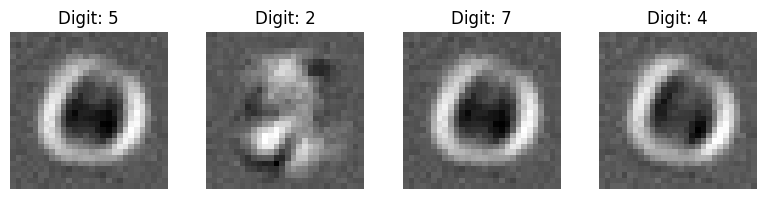

Epoch [12/1000], i: 0, Loss: 0.2531
Epoch [12/1000], i: 100, Loss: 0.2375
Epoch [12/1000], i: 200, Loss: 0.2317
Epoch [12/1000], i: 300, Loss: 0.2497
Epoch [12/1000], i: 400, Loss: 0.2517
Epoch [13/1000], i: 0, Loss: 0.2416
Epoch [13/1000], i: 100, Loss: 0.2459
Epoch [13/1000], i: 200, Loss: 0.2483
Epoch [13/1000], i: 300, Loss: 0.2353
Epoch [13/1000], i: 400, Loss: 0.2478
Epoch [14/1000], i: 0, Loss: 0.2441
Epoch [14/1000], i: 100, Loss: 0.2349
Epoch [14/1000], i: 200, Loss: 0.2464
Epoch [14/1000], i: 300, Loss: 0.2295
Epoch [14/1000], i: 400, Loss: 0.2346
Epoch [15/1000], i: 0, Loss: 0.2400
Epoch [15/1000], i: 100, Loss: 0.2268
Epoch [15/1000], i: 200, Loss: 0.2379
Epoch [15/1000], i: 300, Loss: 0.2125
Epoch [15/1000], i: 400, Loss: 0.2255
Epoch [16/1000], i: 0, Loss: 0.2314
Epoch [16/1000], i: 100, Loss: 0.2255
Epoch [16/1000], i: 200, Loss: 0.2432
Epoch [16/1000], i: 300, Loss: 0.2284
Epoch [16/1000], i: 400, Loss: 0.2190


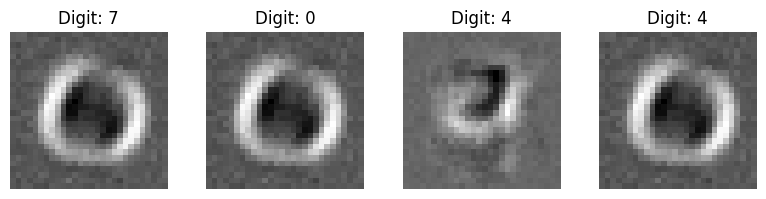

Epoch [17/1000], i: 0, Loss: 0.2314
Epoch [17/1000], i: 100, Loss: 0.2150
Epoch [17/1000], i: 200, Loss: 0.2122
Epoch [17/1000], i: 300, Loss: 0.2359
Epoch [17/1000], i: 400, Loss: 0.2340
Epoch [18/1000], i: 0, Loss: 0.2248
Epoch [18/1000], i: 100, Loss: 0.2108
Epoch [18/1000], i: 200, Loss: 0.2168
Epoch [18/1000], i: 300, Loss: 0.2032
Epoch [18/1000], i: 400, Loss: 0.2263
Epoch [19/1000], i: 0, Loss: 0.2220
Epoch [19/1000], i: 100, Loss: 0.2133
Epoch [19/1000], i: 200, Loss: 0.2214
Epoch [19/1000], i: 300, Loss: 0.2103
Epoch [19/1000], i: 400, Loss: 0.1989
Epoch [20/1000], i: 0, Loss: 0.2107
Epoch [20/1000], i: 100, Loss: 0.2150
Epoch [20/1000], i: 200, Loss: 0.2084
Epoch [20/1000], i: 300, Loss: 0.2411
Epoch [20/1000], i: 400, Loss: 0.2210
Epoch [21/1000], i: 0, Loss: 0.2194
Epoch [21/1000], i: 100, Loss: 0.2124
Epoch [21/1000], i: 200, Loss: 0.2009
Epoch [21/1000], i: 300, Loss: 0.1916
Epoch [21/1000], i: 400, Loss: 0.2134


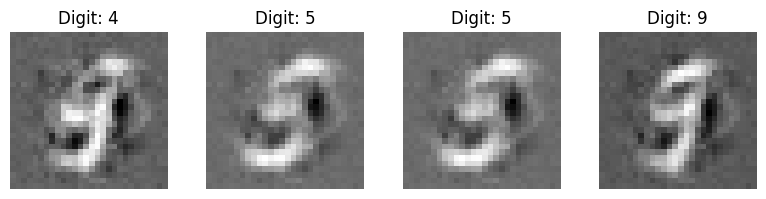

Epoch [22/1000], i: 0, Loss: 0.2094
Epoch [22/1000], i: 100, Loss: 0.2048
Epoch [22/1000], i: 200, Loss: 0.1942
Epoch [22/1000], i: 300, Loss: 0.1902
Epoch [22/1000], i: 400, Loss: 0.1983
Epoch [23/1000], i: 0, Loss: 0.1905
Epoch [23/1000], i: 100, Loss: 0.1906
Epoch [23/1000], i: 200, Loss: 0.2121
Epoch [23/1000], i: 300, Loss: 0.2119
Epoch [23/1000], i: 400, Loss: 0.1843
Epoch [24/1000], i: 0, Loss: 0.2076
Epoch [24/1000], i: 100, Loss: 0.1936


KeyboardInterrupt: 

In [197]:
train()

## Doesn't seem to be working

will have to read tutorials
